# SCH-MGMT 661 - Final Group Project
# Airbnb Broward County Analysis & Machine Learning

---

**Team Members:**
*   Aishwarya Anandan
*   Puneeth Rao Gunuganti
*   Varshini Kuppusami
*   Vipin Kumar Karthikeyan


**Project Objective:** Build a machine learning model to predict Airbnb listing prices in Broward County, Florida

---

## Table of Contents
1. Data Loading and Initial Setup
2. Data Cleaning and Preprocessing
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Model Building
6. Model Evaluation
7. Business Implications
8. What we did different?

---

# Data Loading and Initial Setup

In [10]:
# Install necesarry packages if not already installed
!pip install langdetect googletrans==4.0.0-rc1
!pip install vaderSentiment

In [11]:
# Core data & utilities
import pandas as pd
import numpy as np
import json
import re
from pprint import pprint
from bs4 import BeautifulSoup
import unicodedata
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats

# Sklearn – preprocessing, modeling, evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD, PCA

# NLP Tools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from langdetect import detect
from googletrans import Translator

# Wordcloud
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline

# Deep Learning (if used)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Progress bar
from tqdm import tqdm

# Confusion matrix (if used)
from sklearn.metrics import confusion_matrix

In [12]:

# import datasets
listings_url = 'https://data.insideairbnb.com/united-states/fl/broward-county/2025-06-24/data/listings.csv.gz'
calendar_url = 'https://data.insideairbnb.com/united-states/fl/broward-county/2025-06-24/data/calendar.csv.gz'
reviews_url = 'https://data.insideairbnb.com/united-states/fl/broward-county/2025-06-24/data/reviews.csv.gz'

# Load the datasets into DataFrames
listings_df = pd.read_csv(listings_url, compression='gzip')
calendar_df = pd.read_csv(calendar_url, compression='gzip')
reviews_df = pd.read_csv(reviews_url, compression='gzip')



In [13]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647226 entries, 0 to 647225
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     647226 non-null  int64 
 1   id             647226 non-null  int64 
 2   date           647226 non-null  object
 3   reviewer_id    647226 non-null  int64 
 4   reviewer_name  647224 non-null  object
 5   comments       646992 non-null  object
dtypes: int64(3), object(3)
memory usage: 29.6+ MB


In [14]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17150 entries, 0 to 17149
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            17150 non-null  int64  
 1   listing_url                                   17150 non-null  object 
 2   scrape_id                                     17150 non-null  int64  
 3   last_scraped                                  17150 non-null  object 
 4   source                                        17150 non-null  object 
 5   name                                          17150 non-null  object 
 6   description                                   16853 non-null  object 
 7   neighborhood_overview                         9254 non-null   object 
 8   picture_url                                   17150 non-null  object 
 9   host_id                                       17150 non-null 

# Data Cleaning

**Column typing and coercion**

Parse types up front.

• Currency strings: price comes as text with a dollar sign. Strip symbols and commas and cast to numeric. The dollar sign is an export artifact per the data dictionary.

• Percent strings: host_response_rate, host_acceptance_rate are like "97%". Strip the percent and divide by 100.

• Booleans: host_is_superhost, host_has_profile_pic, host_identity_verified, instant_bookable, has_availability use t or f. Map to True or False.

• Dates: last_scraped, calendar_last_scraped, host_since, first_review, last_review to datetimes.


In [15]:
# Function to convert currency strings to numeric
def convert_currency(price_str):
    if isinstance(price_str, str):
        return float(price_str.replace('$', '').replace(',', ''))
    return np.nan

# Apply currency conversion to 'price' column
listings_df['price'] = listings_df['price'].apply(convert_currency)

# Function to convert percentage strings to float
def convert_percentage(percent_str):
    if isinstance(percent_str, str):
        return float(percent_str.replace('%', '')) / 100
    return np.nan

# Apply percentage conversion to 'host_response_rate' and 'host_acceptance_rate'
listings_df['host_response_rate'] = listings_df['host_response_rate'].apply(convert_percentage)
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].apply(convert_percentage)

# Map 't' and 'f' to True and False for boolean columns
boolean_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'has_availability']
for col in boolean_cols:
    listings_df[col] = listings_df[col].map({'t': True, 'f': False})

# Convert date columns to datetime objects
date_cols = ['last_scraped', 'calendar_last_scraped', 'host_since', 'first_review', 'last_review']
for col in date_cols:
    listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')

display(listings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17150 entries, 0 to 17149
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            17150 non-null  int64         
 1   listing_url                                   17150 non-null  object        
 2   scrape_id                                     17150 non-null  int64         
 3   last_scraped                                  17150 non-null  datetime64[ns]
 4   source                                        17150 non-null  object        
 5   name                                          17150 non-null  object        
 6   description                                   16853 non-null  object        
 7   neighborhood_overview                         9254 non-null   object        
 8   picture_url                                   17150 non-null  obje

None

**Target definition and sanity checks**

• Use price as nightly price in local currency. Broward is USD but still normalize formatting.

• Drop rows with missing or zero price. Clip extreme values using local robust bounds such as the 1st to 99th percentile, then log transform for modeling stability.



In [16]:
# Drop rows with missing or zero price
listings_df.dropna(subset=['price'], inplace=True)
listings_df = listings_df[listings_df['price'] > 0]

# Clip extreme values using 1st and 99th percentiles
lower_bound = listings_df['price'].quantile(0.01)
upper_bound = listings_df['price'].quantile(0.99)
listings_df['price'] = listings_df['price'].clip(lower=lower_bound, upper=upper_bound)

# Log transform the price for modeling stability
listings_df['price'] = np.log1p(listings_df['price'])

display(listings_df[['price']].describe())

price
count  11944.000000
mean       4.932175
std        0.665727
min        3.610918
25%        4.442651
50%        4.875197
75%        5.342334
max        7.162723

**Amenities normalizer**

• amenities is a JSON-like list. Parse safely, lower case, trim, and unify synonyms (e.g., “Wifi” and “Wi-Fi”).


> Create indicator columns for high-signal amenities such as pool, waterfront, parking, kitchen, washer, AC. Also compute amenity_count.




In [17]:
# Function to parse and normalize amenities
def parse_and_normalize_amenities(amenities_str):
    try:
        # Remove leading/trailing brackets and split by comma
        amenities_list = json.loads(amenities_str)
        # Lowercase, strip whitespace, and unify synonyms
        normalized_amenities = [amenity.lower().strip().replace('-', '') for amenity in amenities_list]
        # Unify "wifi" and "wi-fi"
        normalized_amenities = ['wifi' if 'wifi' in amenity else amenity for amenity in normalized_amenities]
        return normalized_amenities
    except json.JSONDecodeError:
        return []

# Apply the function to create a new column with normalized amenities
listings_df['normalized_amenities'] = listings_df['amenities'].apply(parse_and_normalize_amenities)

# Create indicator columns for high-signal amenities
high_signal_amenities = ['pool', 'waterfront', 'parking', 'kitchen', 'washer', 'air conditioning']
for amenity in high_signal_amenities:
    listings_df[amenity.replace(' ', '_')] = listings_df['normalized_amenities'].apply(lambda x: amenity in x)

# Compute amenity_count
listings_df['amenity_count'] = listings_df['normalized_amenities'].apply(len)

# Drop the intermediate column
listings_df.drop(columns=['normalized_amenities'], inplace=True)

display(listings_df[['amenity_count'] + [amenity.replace(' ', '_') for amenity in high_signal_amenities]].head())

amenity_count   pool  waterfront  parking  kitchen  washer  \
1             20   True       False    False     True    True   
3             30  False       False    False     True    True   
4             20  False       False    False     True    True   
6             16   True       False    False     True    True   
8             55  False       False    False     True   False   

   air_conditioning  
1              True  
3              True  
4              True  
6              True  
8             False

**Bedrooms, beds, accommodates reconciliation**

• Fix obvious inconsistencies: if beds is missing but accommodates is present, set beds = max(beds, accommodates) when beds is clearly underreported like 0 with accommodates ≥ 1.


In [18]:
# Fix inconsistencies: if beds is missing and accommodates is present and >= 1, set beds to accommodates
listings_df.loc[(listings_df['beds'].isna()) & (listings_df['accommodates'] >= 1), 'beds'] = listings_df['accommodates']

display(listings_df[['beds', 'accommodates']].head())

beds  accommodates
1   4.0             6
3   3.0             5
4   2.0             4
6   3.0             5
8   2.0             4

** Host fields clean up**

• Coerce host_listings_count and host_total_listings_count to numeric but prefer calculated_host_listings_count family for modeling since those are computed on the current scrape.

• Engineer host_tenure_days = last_scraped − host_since. Flag new hosts where tenure is short or dates are missing.


In [19]:
# Coerce host_listings_count and host_total_listings_count to numeric
listings_df['host_listings_count'] = pd.to_numeric(listings_df['host_listings_count'], errors='coerce')
listings_df['host_total_listings_count'] = pd.to_numeric(listings_df['host_total_listings_count'], errors='coerce')

# Engineer host_tenure_days
listings_df['host_tenure_days'] = (listings_df['last_scraped'] - listings_df['host_since']).dt.days

# Flag new hosts (e.g., tenure less than 90 days or missing host_since date)
listings_df['is_new_host'] = ((listings_df['host_tenure_days'] < 90) | (listings_df['host_since'].isna()))

display(listings_df[['host_listings_count', 'host_total_listings_count', 'host_tenure_days', 'is_new_host']].head())

host_listings_count  host_total_listings_count  host_tenure_days  \
1                  4.0                        5.0            5274.0   
3                  8.0                       19.0            5148.0   
4                  2.0                        3.0            5079.0   
6                  8.0                       19.0            5143.0   
8                  7.0                       10.0            5003.0   

   is_new_host  
1        False  
3        False  
4        False  
6        False  
8        False

**Review signals hygiene**

• number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d to integers.

• reviews_per_month is a calculated field; keep it and add days_since_last_review from last_review.

• Review sub-scores may be missing for new listings. Do not mean-impute; instead add “missing review score” indicators and optionally median-impute within room type and neighborhood.



In [20]:
# Convert review count columns to integers
review_count_cols = ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d']
for col in review_count_cols:
    listings_df[col] = listings_df[col].fillna(0).astype(int)

# Calculate days since last review
# Ensure 'last_scraped' and 'last_review' are datetime objects (already done in a previous step)
listings_df['days_since_last_review'] = (listings_df['last_scraped'] - listings_df['last_review']).dt.days

# Handle missing review sub-scores
review_score_cols = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

for col in review_score_cols:
    # Create indicator for missing review score
    listings_df[f'{col}_missing'] = listings_df[col].isna()
    # Option 1: Median impute within room type and neighborhood (more complex, could be done later)
    # For now, we'll just fill missing values with a placeholder (e.g., -1 or median of non-missing)
    # Here, we'll fill with the median of the non-missing values for simplicity
    median_score = listings_df[col].median()
    listings_df[col] = listings_df[col].fillna(median_score)


display(listings_df[['number_of_reviews', 'reviews_per_month', 'days_since_last_review'] + review_score_cols + [f'{col}_missing' for col in review_score_cols]].head())

number_of_reviews  reviews_per_month  days_since_last_review  \
1                  4               0.08                   754.0   
3                 28               0.17                   474.0   
4                 25               0.15                  2062.0   
6                 18               0.11                  2656.0   
8                292               1.78                    26.0   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
1                  4.00                    4.50                       4.00   
3                  4.32                    4.44                       4.27   
4                  4.25                    4.39                       4.46   
6                  4.93                    4.88                       4.81   
8                  4.85                    4.89                       4.89   

   review_scores_checkin  review_scores_communication  review_scores_location  \
1                   4.75                         4.75                    5.00   
3                   4.46                         4.35                    4.56   
4                   4.83                         4.87                    4.87   
6                   5.00                         5.00                    4.88   
8                   4.92                         4.92                    4.67   

   review_scores_value  review_scores_rating_missing  \
1                 4.50                         False   
3                 4.12                         False   
4                 4.43                         False   
6                 4.81                         False   
8                 4.80                         False   

   review_scores_accuracy_missing  review_scores_cleanliness_missing  \
1                           False                              False   
3                           False                              False   
4                           False                              False   
6                           False                              False   
8                           False                              False   

   review_scores_checkin_missing  review_scores_communication_missing  \
1                          False                                False   
3                          False                                False   
4                          False                                False   
6                          False                                False   
8                          False                                False   

   review_scores_location_missing  review_scores_value_missing  
1                           False                        False  
3                           False                        False  
4                           False                        False  
6                           False                        False  
8                           False                        False

In [21]:
display(listings_df.isnull().sum())

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
source                                 0
                                      ..
review_scores_cleanliness_missing      0
review_scores_checkin_missing          0
review_scores_communication_missing    0
review_scores_location_missing         0
review_scores_value_missing            0
Length: 96, dtype: int64

In [22]:
missing_values = listings_df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
display(columns_with_missing_values)

description                       183
neighborhood_overview            5577
host_name                         396
host_since                        407
host_location                    3122
host_about                       5420
host_response_time               1248
host_response_rate               1248
host_acceptance_rate              940
host_is_superhost                 457
host_thumbnail_url                407
host_picture_url                  407
host_neighbourhood               4305
host_listings_count               407
host_total_listings_count         407
host_verifications                407
host_has_profile_pic              407
host_identity_verified            407
neighbourhood                    5577
neighbourhood_group_cleansed    11944
bathrooms                          20
bathrooms_text                     22
bedrooms                           93
minimum_minimum_nights              1
maximum_minimum_nights              1
minimum_maximum_nights              1
maximum_maximum_nights              1
calendar_updated                11944
has_availability                   67
first_review                     1529
last_review                      1529
license                         11944
reviews_per_month                1529
host_tenure_days                  407
days_since_last_review           1529
dtype: int64

# Feature Missing Coincidence check across rows:

In [23]:
host_cols_with_missing = [
    'host_total_listings_count',
    'host_verifications',
    'host_has_profile_pic',
    'host_identity_verified',
    'host_listings_count',
    'host_thumbnail_url',
    'host_picture_url',
    'host_since'
]

# Check the number of rows where ALL specified columns are missing
all_missing_count = listings_df[host_cols_with_missing].isnull().all(axis=1).sum()

# Check the number of rows where ANY of the specified columns are missing
any_missing_count = listings_df[host_cols_with_missing].isnull().any(axis=1).sum()

print(f"Number of rows where all specified host columns are missing: {all_missing_count}")
print(f"Number of rows where any of the specified host columns are missing: {any_missing_count}")

# You can also check if the sum of missing values for each column is the same
missing_counts = listings_df[host_cols_with_missing].isnull().sum()
display(missing_counts)

Number of rows where all specified host columns are missing: 407
Number of rows where any of the specified host columns are missing: 407


host_total_listings_count    407
host_verifications           407
host_has_profile_pic         407
host_identity_verified       407
host_listings_count          407
host_thumbnail_url           407
host_picture_url             407
host_since                   407
dtype: int64

In [24]:
missing_values = listings_df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
display(columns_with_missing_values)

description                       183
neighborhood_overview            5577
host_name                         396
host_since                        407
host_location                    3122
host_about                       5420
host_response_time               1248
host_response_rate               1248
host_acceptance_rate              940
host_is_superhost                 457
host_thumbnail_url                407
host_picture_url                  407
host_neighbourhood               4305
host_listings_count               407
host_total_listings_count         407
host_verifications                407
host_has_profile_pic              407
host_identity_verified            407
neighbourhood                    5577
neighbourhood_group_cleansed    11944
bathrooms                          20
bathrooms_text                     22
bedrooms                           93
minimum_minimum_nights              1
maximum_minimum_nights              1
minimum_maximum_nights              1
maximum_maximum_nights              1
calendar_updated                11944
has_availability                   67
first_review                     1529
last_review                      1529
license                         11944
reviews_per_month                1529
host_tenure_days                  407
days_since_last_review           1529
dtype: int64

**Room and property taxonomies**

• Normalize room_type and property_type strings and collapse ultra-rare categories into “Other” to avoid high cardinality drift. Verify room_type aligns to the standard set.

In [25]:
# Normalize room_type and property_type strings
listings_df['room_type'] = listings_df['room_type'].str.lower().str.strip()
listings_df['property_type'] = listings_df['property_type'].str.lower().str.strip()

# Define a threshold for rare categories (e.g., categories appearing less than 1% of the time)
rare_threshold_room = len(listings_df) * 0.01
rare_threshold_property = len(listings_df) * 0.01

# Collapse ultra-rare room_type categories into "Other"
room_type_counts = listings_df['room_type'].value_counts()
rare_room_types = room_type_counts[room_type_counts < rare_threshold_room].index
listings_df['room_type'] = listings_df['room_type'].replace(rare_room_types, 'other')

# Collapse ultra-rare property_type categories into "Other"
property_type_counts = listings_df['property_type'].value_counts()
rare_property_types = property_type_counts[property_type_counts < rare_threshold_property].index
listings_df['property_type'] = listings_df['property_type'].replace(rare_property_types, 'other')


# Verify room_type aligns to the standard set (assuming standard are 'entire home/apt', 'private room', 'shared room', 'hotel room')
standard_room_types = ['entire home/apt', 'private room', 'shared room', 'hotel room', 'other']
print("Unique room types after normalization and collapsing:")
print(listings_df['room_type'].unique())

print("\nUnique property types after normalization and collapsing:")
print(listings_df['property_type'].unique())

Unique room types after normalization and collapsing:
['entire home/apt' 'private room' 'other']

Unique property types after normalization and collapsing:
['entire condo' 'entire rental unit' 'entire home' 'other'
 'private room in rental unit' 'private room in home' 'entire guesthouse'
 'entire villa' 'entire guest suite' 'entire serviced apartment'
 'room in hotel']


**Neighborhood fields**

• Prefer neighbourhood_cleansed over free text neighbourhood. If neighbourhood_group_cleansed exists, use it as a coarse region feature. Fill missing cleansed values using a spatial join fallback if needed.



> Use the unique neighbourhood_cleansed value belopw for further analysis



In [26]:
# Display unique values in neighbourhood_cleansed to understand the granularity
print("Unique values in neighbourhood_cleansed:")
display(listings_df['neighbourhood_cleansed'].unique())

# You might want to perform one-hot encoding or other feature engineering
# on 'neighbourhood_cleansed' later for modeling.

Unique values in neighbourhood_cleansed:


array(['Hallandale Beach', 'Hollywood', 'Deerfield Beach', 'Miramar',
       'Fort Lauderdale', 'Dania Beach', 'Lauderhill', 'North Lauderdale',
       'Lauderdale By The Sea', 'Pompano Beach', 'Oakland Park',
       'Pembroke Pines', 'Tamarac', 'Margate', 'Parkland',
       'Coral Springs', 'Davie', 'Wilton Manors', 'Plantation', 'Sunrise',
       'Lighthouse Point', 'Southwest Ranches', 'Weston', 'West Park',
       'Coconut Creek', 'Lauderdale Lakes', 'Cooper City',
       'Hillsboro Beach', 'Unincorporated', 'Pembroke Park',
       'Sea Ranch Lakes', 'Tribal Land', 'County Regional Facility'],
      dtype=object)

**Text fields scrub**

• For name, description, neighborhood_overview: strip HTML, normalize whitespace and unicode, remove repeated punctuation, and optionally create compact NLP features such as TF flags for “beach”, “ocean”, “Las Olas”, “FLL”, “parking”, “pool”, “newly renovated”.

In [27]:
def clean_text(text):
    if pd.isna(text):
        return ""
    # Strip HTML
    text = BeautifulSoup(text, 'html.parser').get_text()
    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    # Normalize whitespace and remove repeated punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'([.,!?;:])\1+', r'\1', text)
    return text

# Apply cleaning to specified text columns
text_cols_to_clean = ['name', 'description', 'neighborhood_overview']
for col in text_cols_to_clean:
    listings_df[col] = listings_df[col].apply(clean_text)

# Create TF flags for high-signal keywords
keywords = ['beach', 'ocean', 'las olas', 'fll', 'parking', 'pool', 'newly renovated']
for keyword in keywords:
    listings_df[f'has_{keyword.replace(" ", "_")}'] = listings_df['description'].str.lower().str.contains(keyword, na=False) | \
                                                        listings_df['neighborhood_overview'].str.lower().str.contains(keyword, na=False)


display(listings_df[[f'has_{keyword.replace(" ", "_")}' for keyword in keywords]].head())

has_beach  has_ocean  has_las_olas  has_fll  has_parking  has_pool  \
1      False      False         False    False        False     False   
3       True       True         False    False        False     False   
4       True       True         False    False        False     False   
6      False      False         False    False        False     False   
8       True      False         False    False        False     False   

   has_newly_renovated  
1                False  
3                False  
4                False  
6                False  
8                False

**Duplicates and identity checks**

• Enforce uniqueness on id at the row level for a single scrape. If you union multiple snapshots, de-duplicate on id keeping the most recent last_scraped.

• Remove exact duplicates and near-duplicates that differ only by transient scrape fields.

In [28]:
# Enforce uniqueness on 'id' at the row level for a single scrape.
# In a single scrape, 'id' should already be unique. We can verify this.
print(f"Number of rows before checking for duplicates: {listings_df.shape[0]}")
print(f"Number of unique listing IDs: {listings_df['id'].nunique()}")

# Check for and remove exact duplicates
initial_rows = listings_df.shape[0]
listings_df.drop_duplicates(inplace=True)
rows_after_exact_duplicates = listings_df.shape[0]
print(f"Number of exact duplicate rows removed: {initial_rows - rows_after_exact_duplicates}")

# For near-duplicates that differ only by transient scrape fields,
# based on a subset of columns excluding the transient ones, keeping the most recent.

print(f"Number of rows after removing exact duplicates: {listings_df.shape[0]}")

Number of rows before checking for duplicates: 11944
Number of unique listing IDs: 11944
Number of exact duplicate rows removed: 0
Number of rows after removing exact duplicates: 11944


**NA strategy by class**

• Numerical counts such as bedrooms, beds, accommodates: median within room_type × neighbourhood_cleansed and add NA flags.

• Percent rates: leave as missing with NA flags or impute from host cohort medians.

• Dates: keep missing as a signal via tenure equals zero and is_new_host = 1.

In [29]:
# NA strategy by class

# Numerical counts (bedrooms, beds, accommodates): median within room_type × neighbourhood_cleansed and add NA flags.
numerical_cols_to_impute = ['bedrooms', 'beds', 'accommodates']

for col in numerical_cols_to_impute:
    # Create NA flag
    listings_df[f'{col}_missing'] = listings_df[col].isna()

    # Impute missing values with median within room_type and neighbourhood_cleansed
    listings_df[col] = listings_df.groupby(['room_type', 'neighbourhood_cleansed'])[col].transform(lambda x: x.fillna(x.median()))


# Display the updated columns and the new NA flags
display(listings_df[numerical_cols_to_impute + [f'{col}_missing' for col in numerical_cols_to_impute]].head())

bedrooms  beds  accommodates  bedrooms_missing  beds_missing  \
1       2.0   4.0             6             False         False   
3       1.0   3.0             5             False         False   
4       1.0   2.0             4             False         False   
6       1.0   3.0             5             False         False   
8       2.0   2.0             4             False         False   

   accommodates_missing  
1                 False  
3                 False  
4                 False  
6                 False  
8                 False

**Outlier policies beyond price**

• Drop listings with nonsensical counts like accommodates = 0 or bathrooms > 10 for an apartment.

• Cap counts using realistic city limits or percentile caps within room type.

# Final missing value check

In [30]:
missing_values = listings_df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
display(columns_with_missing_values)

host_name                         396
host_since                        407
host_location                    3122
host_about                       5420
host_response_time               1248
host_response_rate               1248
host_acceptance_rate              940
host_is_superhost                 457
host_thumbnail_url                407
host_picture_url                  407
host_neighbourhood               4305
host_listings_count               407
host_total_listings_count         407
host_verifications                407
host_has_profile_pic              407
host_identity_verified            407
neighbourhood                    5577
neighbourhood_group_cleansed    11944
bathrooms                          20
bathrooms_text                     22
bedrooms                            3
minimum_minimum_nights              1
maximum_minimum_nights              1
minimum_maximum_nights              1
maximum_maximum_nights              1
calendar_updated                11944
has_availability                   67
first_review                     1529
last_review                      1529
license                         11944
reviews_per_month                1529
host_tenure_days                  407
days_since_last_review           1529
dtype: int64

# Final Imputations:

Dropping columns:

license	11535
neighbourhood_group_cleansed	11535
neighbourhood_group_cleansed	11535


In [31]:
# Dropping columns with a high number of missing values
cols_to_drop = ['license', 'neighbourhood_group_cleansed', 'calendar_updated']
listings_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

display(listings_df.isnull().sum())

id                      0
listing_url             0
scrape_id               0
last_scraped            0
source                  0
                       ..
has_pool                0
has_newly_renovated     0
bedrooms_missing        0
beds_missing            0
accommodates_missing    0
Length: 103, dtype: int64

**bathrooms_text (22):** Parse to numeric bathrooms + flags.
• If bathrooms missing, extract float from text; create bath_is_private (1 if “private”), bath_is_shared (1 if “shared”).
• If parsing fails, impute median by room_type × neighbourhood_cleansed and add bathrooms_na=1.

**bedrooms (3):**
• If missing or 0 but beds/accommodates present, impute: bedrooms = ceil(beds/2) capped by accommodates.
• Else median by room_type × neighbourhood_cleansed. Add bedrooms_na=1 when imputed.

**neighbourhood (5367)** / neighbourhood_group_cleansed (11535): **bold text**
• Prefer neighbourhood_cleansed if you have it.
• If not available, bin lat/lon into coarse geo buckets (e.g., H3 or a k-means cluster on coordinates) and use those as neighborhoods. Add neigh_missing=1 for rows where original neighborhood text is missing.
• neighbourhood_group_cleansed is fully/mostly missing for this city, so drop it.

In [32]:


# bathrooms_text (22): Parse to numeric bathrooms + flags.
def parse_bathrooms_text(bathroom_text):
    if pd.isna(bathroom_text):
        return np.nan, np.nan, np.nan # Return nan for value and flags if text is missing

    text = str(bathroom_text).lower()
    bath_value = np.nan
    bath_is_private = 0
    bath_is_shared = 0

    # Check for private or shared
    if 'private' in text:
        bath_is_private = 1
    if 'shared' in text:
        bath_is_shared = 1

    # Extract the number of bathrooms
    match = re.search(r'\d+(\.\d+)?', text)
    if match:
        try:
            bath_value = float(match.group(0))
            # Handle "half" bathrooms explicitly if not captured by regex
            if 'half' in text and '.' not in match.group(0):
                 bath_value += 0.5
        except ValueError:
            pass # Keep as nan if conversion fails

    return bath_value, bath_is_private, bath_is_shared

# Apply the parsing function
listings_df[['parsed_bathrooms', 'bath_is_private', 'bath_is_shared']] = listings_df['bathrooms_text'].apply(parse_bathrooms_text).apply(pd.Series)

# If 'bathrooms' (the float column) is missing, use the parsed value
listings_df['bathrooms'] = listings_df['bathrooms'].fillna(listings_df['parsed_bathrooms'])

# If parsing also failed or original 'bathrooms' was missing, impute median by room_type × neighbourhood_cleansed
listings_df['bathrooms_na'] = listings_df['bathrooms'].isna() # Create NA flag for bathrooms
listings_df['bathrooms'] = listings_df.groupby(['room_type', 'neighbourhood_cleansed'])['bathrooms'].transform(lambda x: x.fillna(x.median()))

# Drop the intermediate parsed column
listings_df.drop(columns=['parsed_bathrooms'], inplace=True)

# Create a boolean mask for rows where bedrooms is missing or 0
bedroom_missing_or_zero = (listings_df['bedrooms'].isna()) | (listings_df['bedrooms'] == 0)

# Create a boolean mask for rows where beds and accommodates are present and >= 1
beds_accommodates_present = (listings_df['beds'].notna()) & (listings_df['accommodates'].notna()) & (listings_df['beds'] >= 1) & (listings_df['accommodates'] >= 1)

# Condition to apply the ceil(beds/2) imputation: bedrooms missing/zero AND beds/accommodates present
condition_impute_ceil = bedroom_missing_or_zero & beds_accommodates_present

# Apply the ceil(beds/2) imputation, capped by accommodates
listings_df.loc[condition_impute_ceil, 'bedrooms'] = np.ceil(listings_df.loc[condition_impute_ceil, 'beds'] / 2)
listings_df.loc[condition_impute_ceil, 'bedrooms'] = listings_df.loc[condition_impute_ceil, 'bedrooms'].clip(upper=listings_df.loc[condition_impute_ceil, 'accommodates'])

# Create NA flag for bedrooms before the final median imputation
listings_df['bedrooms_na'] = listings_df['bedrooms'].isna()

# Impute remaining missing bedrooms with median by room_type × neighbourhood_cleansed
listings_df['bedrooms'] = listings_df.groupby(['room_type', 'neighbourhood_cleansed'])['bedrooms'].transform(lambda x: x.fillna(x.median()))

# Ensure bedrooms is not 0 after imputation if accommodates is >= 1
listings_df.loc[(listings_df['bedrooms'] == 0) & (listings_df['accommodates'] >= 1), 'bedrooms'] = 1



# 'neighbourhood_cleansed' is the preferred column and has no missing values.
# The original 'neighbourhood' column has many missing values.
# We will create a flag for missing original 'neighbourhood' text.
listings_df['neigh_missing'] = listings_df['neighbourhood'].isna()


# Display a sample of the updated columns and new flags
display(listings_df[['bathrooms', 'bath_is_private', 'bath_is_shared', 'bathrooms_na', 'bedrooms', 'bedrooms_na', 'neigh_missing']].head())

bathrooms  bath_is_private  bath_is_shared  bathrooms_na  bedrooms  \
1        2.0              0.0             0.0         False       2.0   
3        1.5              0.0             0.0         False       1.0   
4        1.0              0.0             0.0         False       1.0   
6        1.5              0.0             0.0         False       1.0   
8        1.0              0.0             0.0         False       2.0   

   bedrooms_na  neigh_missing  
1        False           True  
3        False           True  
4        False           True  
6        False           True  
8        False           True

# Host behavior / trust signals
host_is_superhost (446):
• Impute False (0) and add superhost_na=1. Superhost is stable and useful.

host_response_time (841):
• Categorical. Impute mode within host cohort (e.g., by calculated_host_listings_count bucket or superhost). Add hrt_na=1.

host_response_rate (841), host_acceptance_rate (533):
• Convert “97%” → 0.97.
• Impute median within host cohort (superhost, calculated_host_listings_count bins, or room_type). Add hrr_na=1, har_na=1.

host_location (2715):
• If coordinates are present, derive host_same_state or host_in_FL by matching state name in host_location when it exists; otherwise leave missing. Add host_loc_na=1. Don’t try to free-text impute.

host_about (5012), host_neighbourhood (3898):
• Treat as low signal text; don’t impute. Add binary indicators (host_about_present, host_neighbourhood_present). Optionally use len(host_about) as a numeric feature.

In [33]:
# Host behavior / trust signals

# host_is_superhost (446):
# Impute False (0) and add superhost_na=1.
listings_df['superhost_na'] = listings_df['host_is_superhost'].isna()
# Convert 't'/'f' to boolean first if not already done (it was done in a previous step, but good to be safe)
# listings_df['host_is_superhost'] = listings_df['host_is_superhost'].map({'t': True, 'f': False, True: True, False: False}) # Ensure boolean type
listings_df['host_is_superhost'] = listings_df['host_is_superhost'].fillna(False)


# host_response_time (841):
# Categorical. Impute mode within host cohort (e.g., by calculated_host_listings_count bucket or superhost). Add hrt_na=1.
listings_df['hrt_na'] = listings_df['host_response_time'].isna()

# Create a simple host cohort based on 'host_is_superhost' for imputation
# If superhost is True, impute with the mode of superhosts, otherwise impute with the mode of non-superhosts
superhost_mode = listings_df[listings_df['host_is_superhost'] == True]['host_response_time'].mode()
non_superhost_mode = listings_df[listings_df['host_is_superhost'] == False]['host_response_time'].mode()

# Impute missing values based on superhost status
listings_df.loc[listings_df['host_response_time'].isna() & (listings_df['host_is_superhost'] == True), 'host_response_time'] = superhost_mode[0] if not superhost_mode.empty else np.nan
listings_df.loc[listings_df['host_response_time'].isna() & (listings_df['host_is_superhost'] == False), 'host_response_time'] = non_superhost_mode[0] if not non_superhost_mode.empty else np.nan

# If there are still missing values after cohort imputation, fill with the overall mode or a placeholder
if listings_df['host_response_time'].isna().sum() > 0:
    overall_mode = listings_df['host_response_time'].mode()
    listings_df['host_response_time'] = listings_df['host_response_time'].fillna(overall_mode[0] if not overall_mode.empty else 'Unknown')


# Impute median within host cohort (superhost, calculated_host_listings_count bins, or room_type). Add hrr_na=1, har_na=1.

# Create NA flags
listings_df['hrr_na'] = listings_df['host_response_rate'].isna()
listings_df['har_na'] = listings_df['host_acceptance_rate'].isna()

# Impute median within 'host_is_superhost' groups
listings_df['host_response_rate'] = listings_df.groupby('host_is_superhost')['host_response_rate'].transform(lambda x: x.fillna(x.median()))
listings_df['host_acceptance_rate'] = listings_df.groupby('host_is_superhost')['host_acceptance_rate'].transform(lambda x: x.fillna(x.median()))


# host_location (2715):
# If coordinates are present, derive host_same_state or host_in_FL by matching state name in host_location when it exists; otherwise leave missing. Add host_loc_na=1.
listings_df['host_loc_na'] = listings_df['host_location'].isna()

# Function to check if host location is in Florida
def is_in_florida(location):
    if pd.isna(location):
        return False
    # Simple check for 'FL' or 'Florida' in the string (case-insensitive)
    return bool(re.search(r'\b(FL|Florida)\b', str(location), re.IGNORECASE))

listings_df['host_in_FL'] = listings_df['host_location'].apply(is_in_florida)


# host_about (5012), host_neighbourhood (3898):
# Treat as low signal text; don’t impute. Add binary indicators (host_about_present, host_neighbourhood_present). Optionally use len(host_about) as a numeric feature.

listings_df['host_about_present'] = listings_df['host_about'].notna()
listings_df['host_neighbourhood_present'] = listings_df['host_neighbourhood'].notna()

# Optional: Add length of host_about as a numeric feature
listings_df['host_about_len'] = listings_df['host_about'].str.len().fillna(0).astype(int)


# Display a sample of the updated columns and new flags
display(listings_df[['host_is_superhost', 'superhost_na',
                     'host_response_time', 'hrt_na',
                     'host_response_rate', 'hrr_na',
                     'host_acceptance_rate', 'har_na',
                     'host_location', 'host_loc_na', 'host_in_FL',
                     'host_about_present', 'host_neighbourhood_present', 'host_about_len']].head())

/tmp/ipython-input-1518683837.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  listings_df['host_is_superhost'] = listings_df['host_is_superhost'].fillna(False)


host_is_superhost  superhost_na host_response_time  hrt_na  \
1              False         False       within a day   False   
3              False         False     within an hour   False   
4              False         False     within an hour    True   
6              False         False     within an hour   False   
8              False          True     within an hour   False   

   host_response_rate  hrr_na  host_acceptance_rate  har_na  \
1                 0.5   False                  0.00   False   
3                 1.0   False                  0.31   False   
4                 1.0    True                  0.00   False   
6                 1.0   False                  0.31   False   
8                 1.0   False                  0.98   False   

             host_location  host_loc_na  host_in_FL  host_about_present  \
1                Aldie, VA        False       False               False   
3  Buenos Aires, Argentina        False       False                True   
4      Fort Lauderdale, FL        False        True                True   
6  Buenos Aires, Argentina        False       False                True   
8            Hollywood, FL        False        True               False   

   host_neighbourhood_present  host_about_len  
1                       False               0  
3                        True             184  
4                       False             291  
6                        True             184  
8                       False               0

# Availability / policy

has_availability (62):
• If missing and availability_365 exists, set has_availability = (availability_365 > 0). Add has_avail_na=1 for safety.

minimum_minimum_nights (1), maximum_minimum_nights (1), minimum_maximum_nights (1), maximum_maximum_nights (1):
• Cast to int. For the few missing values, copy reasonable neighbors (e.g., minimum_minimum_nights ← minimum_nights; maximum_maximum_nights ← maximum_nights). If still missing, impute median by room_type. Add flags (minmin_na, etc.) since policies correlate with price.

In [34]:
# has_availability (62):
# If missing and availability_365 exists, set has_availability = (availability_365 > 0). Add has_avail_na=1.
listings_df['has_avail_na'] = listings_df['has_availability'].isna()
listings_df.loc[listings_df['has_availability'].isna() & listings_df['availability_365'].notna(), 'has_availability'] = (listings_df['availability_365'] > 0)
# Fill any remaining NaNs in has_availability with False (assuming False if availability_365 is also missing)
listings_df['has_availability'] = listings_df['has_availability'].fillna(False)


# minimum_minimum_nights (1), maximum_minimum_nights (1), minimum_maximum_nights (1), maximum_maximum_nights (1):
# Cast to int. Handle missing values by copying from neighbors or imputing median. Add flags.
night_policy_cols = ['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights']
neighbor_cols = ['minimum_nights', 'maximum_nights', 'minimum_nights', 'maximum_nights'] # Corresponding columns to copy from

for col, neighbor_col in zip(night_policy_cols, neighbor_cols):
    # Create NA flag
    listings_df[f'{col}_na'] = listings_df[col].isna()

    # Copy from neighbor column if missing
    listings_df[col] = listings_df[col].fillna(listings_df[neighbor_col])

    # If still missing, impute median by room_type
    listings_df[col] = listings_df.groupby('room_type')[col].transform(lambda x: x.fillna(x.median()))

    # Cast to int after imputation (handle potential NaNs if imputation failed)
    # Fill remaining NaNs with a default value (e.g., 0) before casting to int
    listings_df[col] = listings_df[col].fillna(0).astype(int)


# Display a sample of the updated columns and new flags
display(listings_df[['has_availability', 'has_avail_na'] + night_policy_cols + [f'{col}_na' for col in night_policy_cols]].head())

/tmp/ipython-input-448602169.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  listings_df['has_availability'] = listings_df['has_availability'].fillna(False)


has_availability  has_avail_na  minimum_minimum_nights  \
1              True         False                      30   
3              True         False                      10   
4              True         False                       2   
6              True         False                      10   
8              True         False                       2   

   maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
1                      30                     365                     365   
3                      10                     365                     365   
4                       2                     180                     180   
6                      10                     365                     365   
8                       2                     365                     365   

   minimum_minimum_nights_na  maximum_minimum_nights_na  \
1                      False                      False   
3                      False                      False   
4                      False                      False   
6                      False                      False   
8                      False                      False   

   minimum_maximum_nights_na  maximum_maximum_nights_na  
1                      False                      False  
3                      False                      False  
4                      False                      False  
6                      False                      False  
8                      False                      False

# Reviews (new-listing logic)

first_review (1485), last_review (1485):
• These are missing for new or unrated listings. Keep as NaT and add no_reviews=1.
• Create days_since_last_review: if missing, set to a large sentinel (e.g., 9999) and add dsrl_na=1.

reviews_per_month (1485):
• Set to 0 when there are no reviews; add rpm_na=1 if you prefer to distinguish true zero from unknown.

In [35]:
# first_review, last_review: Keep as NaT and add no_reviews=1.
listings_df['no_reviews'] = (listings_df['first_review'].isna()) & (listings_df['last_review'].isna())
listings_df['dsrl_na'] = listings_df['days_since_last_review'].isna()
sentinel_value = 9999
listings_df['days_since_last_review'] = listings_df['days_since_last_review'].fillna(sentinel_value)

# reviews_per_month: Set to 0 when there are no reviews; add rpm_na=1.
listings_df['rpm_na'] = listings_df['reviews_per_month'].isna()
listings_df['reviews_per_month'] = listings_df['reviews_per_month'].fillna(0)


# Display a sample of the updated columns and new flags
display(listings_df[['first_review', 'last_review', 'no_reviews',
                     'days_since_last_review', 'dsrl_na',
                     'reviews_per_month', 'rpm_na']].head())

first_review last_review  no_reviews  days_since_last_review  dsrl_na  \
1   2021-03-27  2023-06-03       False                   754.0    False   
3   2011-08-23  2024-03-14       False                   474.0    False   
4   2012-01-04  2019-11-08       False                  2062.0    False   
6   2011-11-21  2018-03-19       False                  2656.0    False   
8   2012-01-02  2025-06-02       False                    26.0    False   

   reviews_per_month  rpm_na  
1               0.08   False  
3               0.17   False  
4               0.15   False  
6               0.11   False  
8               1.78   False

In [36]:
listings_df.shape

(11944, 125)

In [37]:
missing_values = listings_df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
display(columns_with_missing_values)

host_name                     396
host_since                    407
host_location                3122
host_about                   5420
host_thumbnail_url            407
host_picture_url              407
host_neighbourhood           4305
host_listings_count           407
host_total_listings_count     407
host_verifications            407
host_has_profile_pic          407
host_identity_verified        407
neighbourhood                5577
bathrooms_text                 22
first_review                 1529
last_review                  1529
host_tenure_days              407
bath_is_private                22
bath_is_shared                 22
dtype: int64

In [38]:
# Select the columns to check correlation for.
# Filter for numerical columns as correlation is a numerical measure.
columns_for_correlation = ['bath_is_private', 'bath_is_shared']

# Add the target variable 'price'
columns_for_correlation.append('price')

# Calculate the correlation matrix
correlation_matrix = listings_df[columns_for_correlation].corr()

# Display the correlation of the selected columns with 'price'
display(correlation_matrix[['price']].drop('price'))

price
bath_is_private -0.211515
bath_is_shared  -0.297576

In [39]:
cols_to_drop = ['bath_is_private', 'bath_is_shared']
listings_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
listings_df.head()

id                          listing_url       scrape_id last_scraped  \
1   69824   https://www.airbnb.com/rooms/69824  20250624191927   2025-06-26   
3  129099  https://www.airbnb.com/rooms/129099  20250624191927   2025-07-01   
4  191160  https://www.airbnb.com/rooms/191160  20250624191927   2025-07-01   
6  217990  https://www.airbnb.com/rooms/217990  20250624191927   2025-06-26   
8  256386  https://www.airbnb.com/rooms/256386  20250624191927   2025-06-28   

        source                                 name  \
1  city scrape            2 bd/2ba Oceanfront Condo   
3  city scrape  MIAMI - AMAZING APARTMENT OCEANVIEW   
4  city scrape   Tropical Beach Paradise Awaits You   
6  city scrape              COSY APT OVER THE BEACH   
8  city scrape              Country Living for Four   

                                         description neighborhood_overview  \
1                                                                            
3  Modern oceanview apartment over the beachhas a...                         
4  Imagine being one block from the ocean in an a...                         
6                                                                            
8  What a great place to stay, close to shopping,...                         

                                         picture_url  host_id  ...  \
1  https://a0.muscache.com/pictures/443102/f6b94e...   351303  ...   
3  https://a0.muscache.com/pictures/828393/baabb6...   637272  ...   
4  https://a0.muscache.com/pictures/1251401/83004...   924482  ...   
6  https://a0.muscache.com/pictures/1941966/2ea1b...   637272  ...   
8  https://a0.muscache.com/pictures/miso/Hosting-...  1304156  ...   

  host_neighbourhood_present host_about_len has_avail_na  \
1                      False              0        False   
3                       True            184        False   
4                      False            291        False   
6                       True            184        False   
8                      False              0        False   

  minimum_minimum_nights_na maximum_minimum_nights_na  \
1                     False                     False   
3                     False                     False   
4                     False                     False   
6                     False                     False   
8                     False                     False   

  minimum_maximum_nights_na  maximum_maximum_nights_na  no_reviews  dsrl_na  \
1                     False                      False       False    False   
3                     False                      False       False    False   
4                     False                      False       False    False   
6                     False                      False       False    False   
8                     False                      False       False    False   

  rpm_na  
1  False  
3  False  
4  False  
6  False  
8  False  

[5 rows x 123 columns]

In [40]:
# Select boolean columns
boolean_cols = listings_df.select_dtypes(include='bool').columns

# Convert boolean columns to integer (True to 1, False to 0)
for col in boolean_cols:
    listings_df[col] = listings_df[col].astype(int)

print("Boolean columns converted to integer type.")
display(listings_df[boolean_cols].head())

Boolean columns converted to integer type.


host_is_superhost  has_availability  instant_bookable  pool  waterfront  \
1                  0                 1                 0     1           0   
3                  0                 1                 0     0           0   
4                  0                 1                 0     0           0   
6                  0                 1                 0     1           0   
8                  0                 1                 0     0           0   

   parking  kitchen  washer  air_conditioning  is_new_host  ...  \
1        0        1       1                 1            0  ...   
3        0        1       1                 1            0  ...   
4        0        1       1                 1            0  ...   
6        0        1       1                 1            0  ...   
8        0        1       0                 0            0  ...   

   host_about_present  host_neighbourhood_present  has_avail_na  \
1                   0                           0             0   
3                   1                           1             0   
4                   1                           0             0   
6                   1                           1             0   
8                   0                           0             0   

   minimum_minimum_nights_na  maximum_minimum_nights_na  \
1                          0                          0   
3                          0                          0   
4                          0                          0   
6                          0                          0   
8                          0                          0   

   minimum_maximum_nights_na  maximum_maximum_nights_na  no_reviews  dsrl_na  \
1                          0                          0           0        0   
3                          0                          0           0        0   
4                          0                          0           0        0   
6                          0                          0           0        0   
8                          0                          0           0        0   

   rpm_na  
1       0  
3       0  
4       0  
6       0  
8       0  

[5 rows x 46 columns]

In [41]:
listings_df.head()

id                          listing_url       scrape_id last_scraped  \
1   69824   https://www.airbnb.com/rooms/69824  20250624191927   2025-06-26   
3  129099  https://www.airbnb.com/rooms/129099  20250624191927   2025-07-01   
4  191160  https://www.airbnb.com/rooms/191160  20250624191927   2025-07-01   
6  217990  https://www.airbnb.com/rooms/217990  20250624191927   2025-06-26   
8  256386  https://www.airbnb.com/rooms/256386  20250624191927   2025-06-28   

        source                                 name  \
1  city scrape            2 bd/2ba Oceanfront Condo   
3  city scrape  MIAMI - AMAZING APARTMENT OCEANVIEW   
4  city scrape   Tropical Beach Paradise Awaits You   
6  city scrape              COSY APT OVER THE BEACH   
8  city scrape              Country Living for Four   

                                         description neighborhood_overview  \
1                                                                            
3  Modern oceanview apartment over the beachhas a...                         
4  Imagine being one block from the ocean in an a...                         
6                                                                            
8  What a great place to stay, close to shopping,...                         

                                         picture_url  host_id  ...  \
1  https://a0.muscache.com/pictures/443102/f6b94e...   351303  ...   
3  https://a0.muscache.com/pictures/828393/baabb6...   637272  ...   
4  https://a0.muscache.com/pictures/1251401/83004...   924482  ...   
6  https://a0.muscache.com/pictures/1941966/2ea1b...   637272  ...   
8  https://a0.muscache.com/pictures/miso/Hosting-...  1304156  ...   

  host_neighbourhood_present host_about_len has_avail_na  \
1                          0              0            0   
3                          1            184            0   
4                          0            291            0   
6                          1            184            0   
8                          0              0            0   

  minimum_minimum_nights_na maximum_minimum_nights_na  \
1                         0                         0   
3                         0                         0   
4                         0                         0   
6                         0                         0   
8                         0                         0   

  minimum_maximum_nights_na  maximum_maximum_nights_na  no_reviews  dsrl_na  \
1                         0                          0           0        0   
3                         0                          0           0        0   
4                         0                          0           0        0   
6                         0                          0           0        0   
8                         0                          0           0        0   

  rpm_na  
1      0  
3      0  
4      0  
6      0  
8      0  

[5 rows x 123 columns]

In [42]:
listings_df.shape

(11944, 123)

In [43]:
# Save cleaned data for EDA section
listings_df.to_csv('listings_cleaned.csv', index=False)
print(f"Cleaned data saved: {listings_df.shape[0]:,} rows, {listings_df.shape[1]} columns")
print(f"File saved as: listings_cleaned.csv")

Cleaned data saved: 11,944 rows, 123 columns
File saved as: listings_cleaned.csv



---
---
---

# PART 2: EXPLORATORY DATA ANALYSIS (EDA)

---
---
---

Now that we have cleaned the data, we will perform comprehensive exploratory data analysis to understand patterns, relationships, and insights in the Airbnb listing data.

In [44]:
# EDA libraries and visualization setup
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Data is already loaded from the cleaning section above
print(f"\n{'='*80}")
print("STARTING EXPLORATORY DATA ANALYSIS")
print(f"{'='*80}")
print(f"Dataset: {listings_df.shape[0]:,} rows, {listings_df.shape[1]} columns")
print(f"Memory usage: {listings_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


STARTING EXPLORATORY DATA ANALYSIS
Dataset: 11,944 rows, 123 columns
Memory usage: 47.58 MB


---
## 1. Data Overview and Summary Statistics

In [45]:
# Display basic information
print("="*80)
print("DATASET OVERVIEW")
print("="*80)

print("\nData Types:")
print(listings_df.dtypes.value_counts())

print("\nFirst few rows:")
display(listings_df.head())

DATASET OVERVIEW

Data Types:
int64             72
object            23
float64           23
datetime64[ns]     5
Name: count, dtype: int64

First few rows:


id                          listing_url       scrape_id last_scraped  \
1   69824   https://www.airbnb.com/rooms/69824  20250624191927   2025-06-26   
3  129099  https://www.airbnb.com/rooms/129099  20250624191927   2025-07-01   
4  191160  https://www.airbnb.com/rooms/191160  20250624191927   2025-07-01   
6  217990  https://www.airbnb.com/rooms/217990  20250624191927   2025-06-26   
8  256386  https://www.airbnb.com/rooms/256386  20250624191927   2025-06-28   

        source                                 name  \
1  city scrape            2 bd/2ba Oceanfront Condo   
3  city scrape  MIAMI - AMAZING APARTMENT OCEANVIEW   
4  city scrape   Tropical Beach Paradise Awaits You   
6  city scrape              COSY APT OVER THE BEACH   
8  city scrape              Country Living for Four   

                                         description neighborhood_overview  \
1                                                                            
3  Modern oceanview apartment over the beachhas a...                         
4  Imagine being one block from the ocean in an a...                         
6                                                                            
8  What a great place to stay, close to shopping,...                         

                                         picture_url  host_id  ...  \
1  https://a0.muscache.com/pictures/443102/f6b94e...   351303  ...   
3  https://a0.muscache.com/pictures/828393/baabb6...   637272  ...   
4  https://a0.muscache.com/pictures/1251401/83004...   924482  ...   
6  https://a0.muscache.com/pictures/1941966/2ea1b...   637272  ...   
8  https://a0.muscache.com/pictures/miso/Hosting-...  1304156  ...   

  host_neighbourhood_present host_about_len has_avail_na  \
1                          0              0            0   
3                          1            184            0   
4                          0            291            0   
6                          1            184            0   
8                          0              0            0   

  minimum_minimum_nights_na maximum_minimum_nights_na  \
1                         0                         0   
3                         0                         0   
4                         0                         0   
6                         0                         0   
8                         0                         0   

  minimum_maximum_nights_na  maximum_maximum_nights_na  no_reviews  dsrl_na  \
1                         0                          0           0        0   
3                         0                          0           0        0   
4                         0                          0           0        0   
6                         0                          0           0        0   
8                         0                          0           0        0   

  rpm_na  
1      0  
3      0  
4      0  
6      0  
8      0  

[5 rows x 123 columns]

In [46]:
# Summary statistics for numeric columns
print("\n" + "="*80)
print("SUMMARY STATISTICS - KEY NUMERIC FEATURES")
print("="*80)

key_numeric = ['price', 'accommodates', 'bedrooms', 'bathrooms', 'beds',
               'minimum_nights', 'maximum_nights', 'number_of_reviews',
               'review_scores_rating', 'availability_365']

display(listings_df[key_numeric].describe())

print("\n📊 Key Observations:")
print(f"  • Price range (log-transformed): {listings_df['price'].min():.2f} to {listings_df['price'].max():.2f}")
print(f"  • Average accommodates: {listings_df['accommodates'].mean():.1f} guests")
print(f"  • Average bedrooms: {listings_df['bedrooms'].mean():.1f}")
print(f"  • Average review score: {listings_df['review_scores_rating'].mean():.2f} / 5.00")
print(f"  • Median number of reviews: {listings_df['number_of_reviews'].median():.0f}")


SUMMARY STATISTICS - KEY NUMERIC FEATURES


price  accommodates      bedrooms     bathrooms          beds  \
count  11944.000000  11944.000000  11944.000000  11944.000000  11944.000000   
mean       4.932175      4.570998      1.768963      1.525871      2.580877   
std        0.665727      2.812244      1.147543      0.869800      1.899904   
min        3.610918      1.000000      0.500000      0.000000      0.000000   
25%        4.442651      2.000000      1.000000      1.000000      1.000000   
50%        4.875197      4.000000      1.000000      1.000000      2.000000   
75%        5.342334      6.000000      2.000000      2.000000      3.000000   
max        7.162723     16.000000     15.000000     18.000000     25.000000   

       minimum_nights  maximum_nights  number_of_reviews  \
count    11944.000000    11944.000000        11944.00000   
mean         5.247405      437.933523           44.58925   
std         21.377588      375.167050           77.21697   
min          1.000000        1.000000            0.00000   
25%          1.000000      128.750000            3.00000   
50%          2.000000      365.000000           18.00000   
75%          3.000000      365.000000           54.00000   
max        999.000000     3650.000000         1920.00000   

       review_scores_rating  availability_365  
count          11944.000000      11944.000000  
mean               4.752735        251.618302  
std                0.366727        107.062677  
min                1.000000          0.000000  
25%                4.700000        173.000000  
50%                4.840000        282.000000  
75%                4.950000        346.000000  
max                5.000000        365.000000


📊 Key Observations:
  • Price range (log-transformed): 3.61 to 7.16
  • Average accommodates: 4.6 guests
  • Average bedrooms: 1.8
  • Average review score: 4.75 / 5.00
  • Median number of reviews: 18


---
## 2. Target Variable Analysis: Price

**Methodology:** Since price is log-transformed, we'll analyze both the transformed and actual price distributions.

In [47]:
# Convert log price back to actual price for analysis
listings_df['actual_price'] = np.expm1(listings_df['price'])

print("="*80)
print("PRICE DISTRIBUTION ANALYSIS")
print("="*80)

print("\nActual Price Statistics:")
print(f"  Mean: ${listings_df['actual_price'].mean():.2f}")
print(f"  Median: ${listings_df['actual_price'].median():.2f}")
print(f"  Std Dev: ${listings_df['actual_price'].std():.2f}")
print(f"  Min: ${listings_df['actual_price'].min():.2f}")
print(f"  Max: ${listings_df['actual_price'].max():.2f}")
print(f"  25th percentile: ${listings_df['actual_price'].quantile(0.25):.2f}")
print(f"  75th percentile: ${listings_df['actual_price'].quantile(0.75):.2f}")

PRICE DISTRIBUTION ANALYSIS

Actual Price Statistics:
  Mean: $178.83
  Median: $130.00
  Std Dev: $176.16
  Min: $36.00
  Max: $1289.42
  25th percentile: $84.00
  75th percentile: $208.00


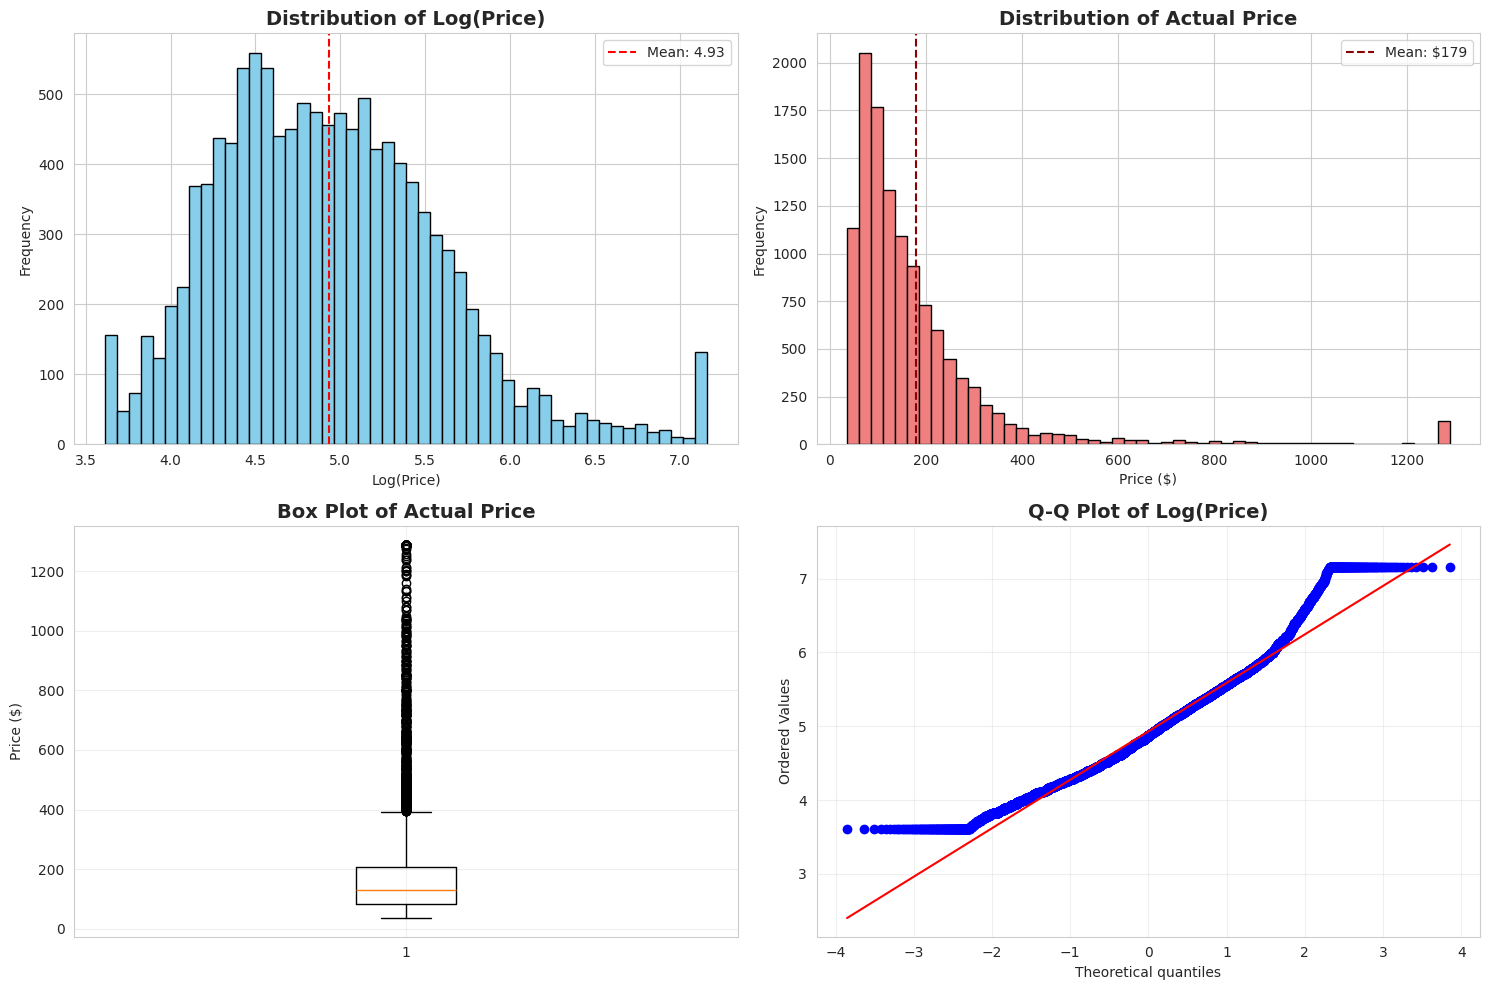


📊 Interpretation:
  • Log transformation successfully normalized the price distribution
  • Q-Q plot shows prices follow approximately normal distribution after log transform
  • This validates our choice to use log-transformed price for modeling
  • Box plot reveals some high-end outliers (luxury properties) which were capped


In [48]:
# Visualize price distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Log-transformed price distribution
axes[0, 0].hist(listings_df['price'], bins=50, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Distribution of Log(Price)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Log(Price)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(listings_df['price'].mean(), color='red', linestyle='--', label=f'Mean: {listings_df["price"].mean():.2f}')
axes[0, 0].legend()

# Actual price distribution
axes[0, 1].hist(listings_df['actual_price'], bins=50, edgecolor='black', color='lightcoral')
axes[0, 1].set_title('Distribution of Actual Price', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Price ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(listings_df['actual_price'].mean(), color='darkred', linestyle='--', label=f'Mean: ${listings_df["actual_price"].mean():.0f}')
axes[0, 1].legend()

# Box plot for actual price
axes[1, 0].boxplot(listings_df['actual_price'], vert=True)
axes[1, 0].set_title('Box Plot of Actual Price', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot for normality check
stats.probplot(listings_df['price'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Log(Price)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Log transformation successfully normalized the price distribution")
print("  • Q-Q plot shows prices follow approximately normal distribution after log transform")
print("  • This validates our choice to use log-transformed price for modeling")
print("  • Box plot reveals some high-end outliers (luxury properties) which were capped")

---
## 3. Categorical Variables Analysis

In [49]:
# Analyze key categorical variables
print("="*80)
print("CATEGORICAL VARIABLES DISTRIBUTION")
print("="*80)

categorical_cols = ['room_type', 'property_type', 'neighbourhood_cleansed']

for col in categorical_cols:
    if col in listings_df.columns:
        print(f"\n{col.upper()}:")
        print(listings_df[col].value_counts())
        print(f"\nPercentage distribution:")
        print((listings_df[col].value_counts(normalize=True) * 100).round(2))

CATEGORICAL VARIABLES DISTRIBUTION

ROOM_TYPE:
room_type
entire home/apt    9989
private room       1856
other                99
Name: count, dtype: int64

Percentage distribution:
room_type
entire home/apt    83.63
private room       15.54
other               0.83
Name: proportion, dtype: float64

PROPERTY_TYPE:
property_type
entire rental unit             4427
entire home                    2725
entire condo                   1691
private room in home           1023
other                           865
private room in rental unit     246
entire villa                    226
entire serviced apartment       209
entire guest suite              187
entire guesthouse               182
room in hotel                   163
Name: count, dtype: int64

Percentage distribution:
property_type
entire rental unit             37.06
entire home                    22.81
entire condo                   14.16
private room in home            8.56
other                           7.24
private room in rental u

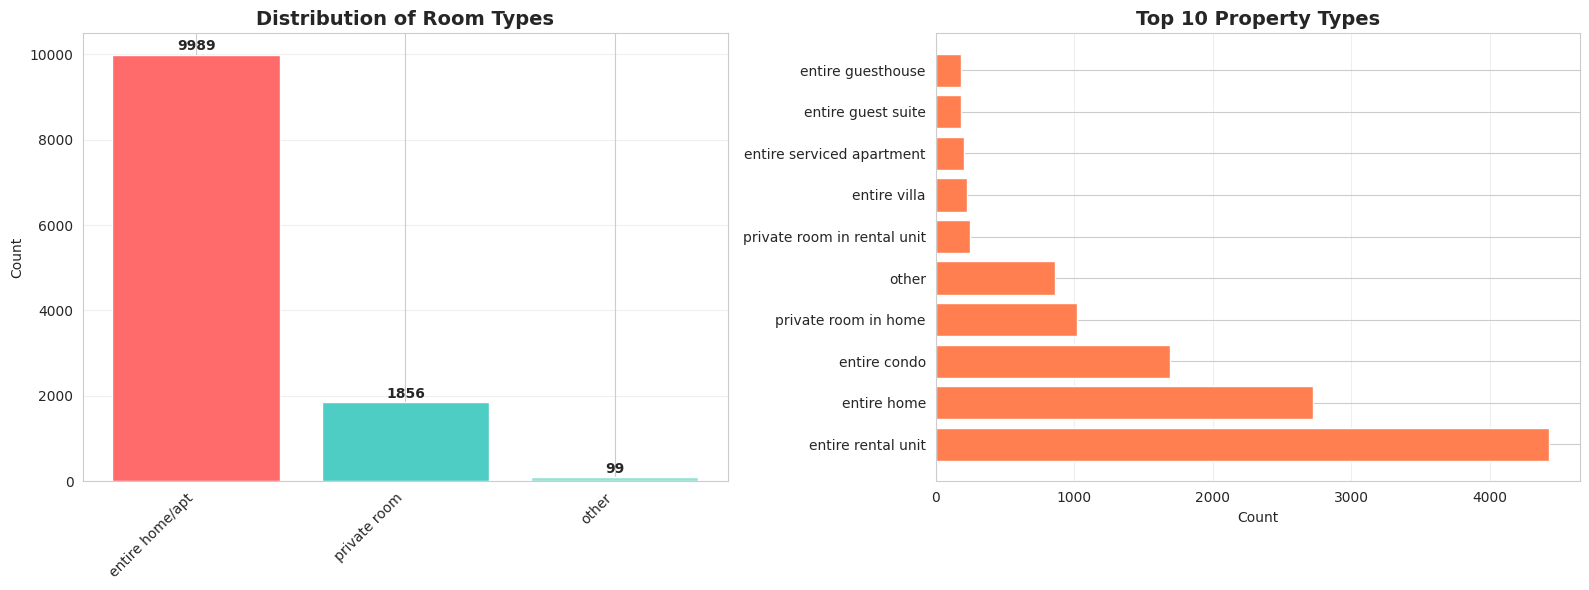


📊 Interpretation:
  • Entire home/apt dominates the market - this will be our baseline for comparison
  • Limited 'shared room' listings suggest Broward market prefers privacy
  • Property types are diverse, with condos and rental units being most common
  • This diversity requires careful encoding for modeling


In [50]:
# Visualize categorical distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Room type distribution
room_type_counts = listings_df['room_type'].value_counts()
axes[0].bar(range(len(room_type_counts)), room_type_counts.values, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[0].set_xticks(range(len(room_type_counts)))
axes[0].set_xticklabels(room_type_counts.index, rotation=45, ha='right')
axes[0].set_title('Distribution of Room Types', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(room_type_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Property type distribution (top 10)
property_type_counts = listings_df['property_type'].value_counts().head(10)
axes[1].barh(range(len(property_type_counts)), property_type_counts.values, color='coral')
axes[1].set_yticks(range(len(property_type_counts)))
axes[1].set_yticklabels(property_type_counts.index)
axes[1].set_title('Top 10 Property Types', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Count')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Entire home/apt dominates the market - this will be our baseline for comparison")
print("  • Limited 'shared room' listings suggest Broward market prefers privacy")
print("  • Property types are diverse, with condos and rental units being most common")
print("  • This diversity requires careful encoding for modeling")

---
## 4. Numerical Features Distribution

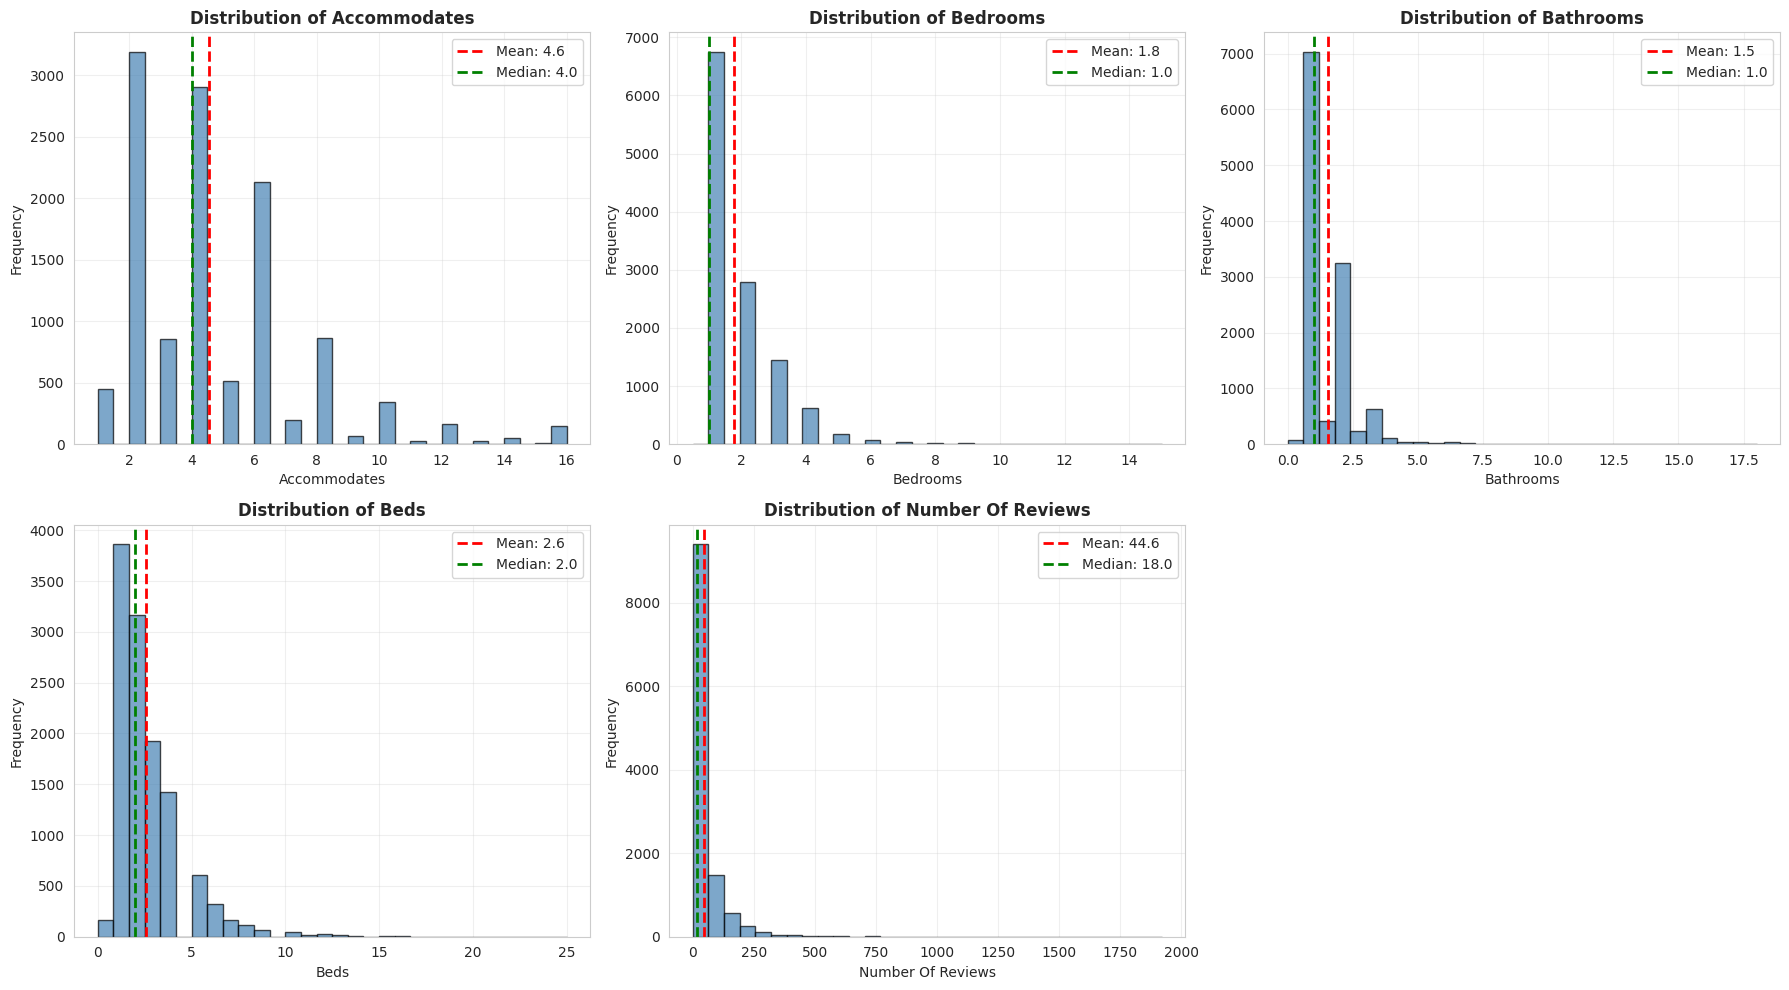


📊 Interpretation:
  • Most properties accommodate 2-4 guests (typical for Broward County)
  • Bedroom/bathroom distributions are right-skewed - most properties are small to medium
  • Number of reviews shows high variance - established vs. new listings
  • These distributions suggest need for robust scaling in modeling


In [51]:
# Visualize distributions of key numerical features
numerical_features = ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'number_of_reviews']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    axes[idx].hist(listings_df[col], bins=30, edgecolor='black', color='steelblue', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}', fontweight='bold')
    axes[idx].set_xlabel(col.replace('_', ' ').title())
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(listings_df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {listings_df[col].mean():.1f}')
    axes[idx].axvline(listings_df[col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {listings_df[col].median():.1f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Most properties accommodate 2-4 guests (typical for Broward County)")
print("  • Bedroom/bathroom distributions are right-skewed - most properties are small to medium")
print("  • Number of reviews shows high variance - established vs. new listings")
print("  • These distributions suggest need for robust scaling in modeling")

---
## 5. Bivariate Analysis: Price vs. Key Features

**Methodology:** We examine how different features correlate with listing price to understand key price drivers.

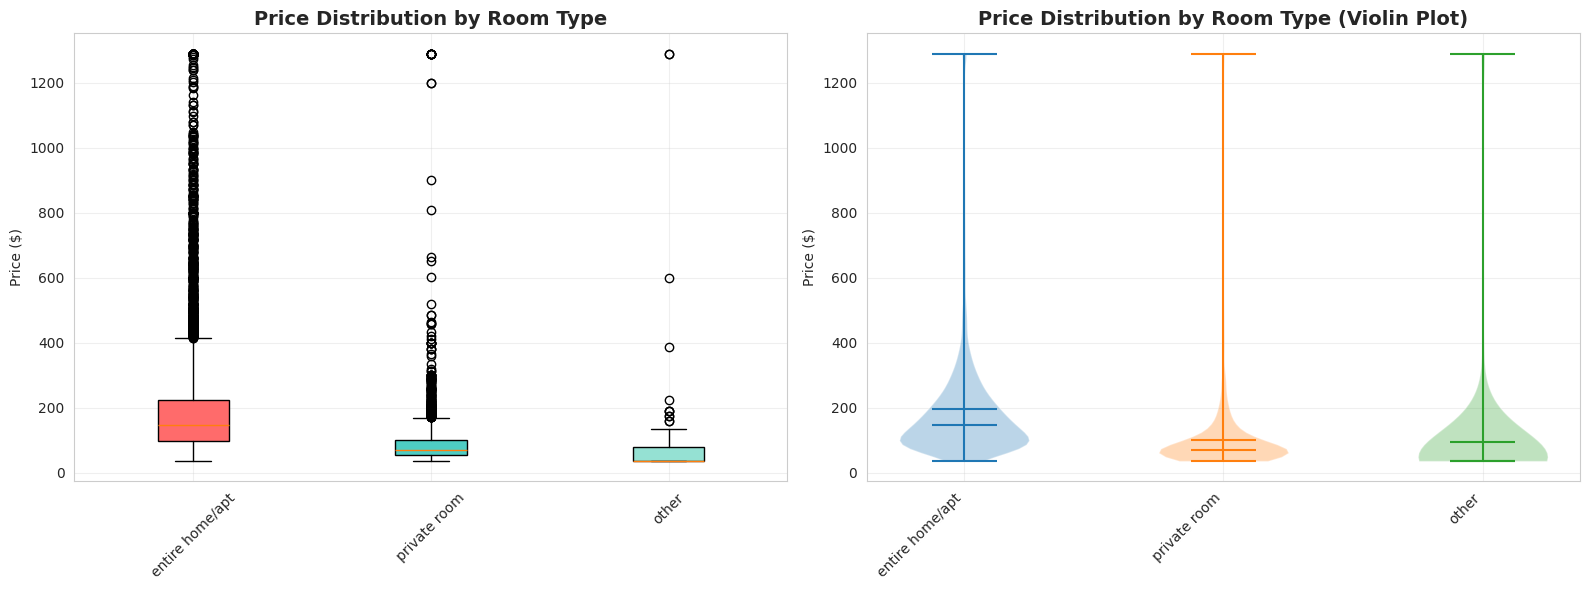


Price Statistics by Room Type:
                  count        mean         std   min   25%    50%    75%  \
room_type                                                                   
entire home/apt  9989.0  194.297764  180.828822  36.0  96.0  145.0  223.0   
other              99.0   94.887273  189.121897  36.0  36.0   36.0   80.0   
private room     1856.0  100.037284  118.185864  36.0  55.0   70.0  101.0   

                     max  
room_type                 
entire home/apt  1289.42  
other            1289.42  
private room     1289.42  

📊 Interpretation:
  • Entire home/apt commands significantly higher prices (as expected)
  • Private rooms offer mid-range pricing
  • Clear price stratification suggests room_type is a strong predictor
  • Wider variance in entire home/apt prices indicates other factors at play


In [52]:
# Price by Room Type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
room_types = listings_df['room_type'].unique()
price_by_room = [listings_df[listings_df['room_type'] == rt]['actual_price'].values for rt in room_types]

bp = axes[0].boxplot(price_by_room, labels=room_types, patch_artist=True)
for patch, color in zip(bp['boxes'], ['#FF6B6B', '#4ECDC4', '#95E1D3']):
    patch.set_facecolor(color)
axes[0].set_title('Price Distribution by Room Type', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Violin plot
for i, rt in enumerate(room_types):
    data = listings_df[listings_df['room_type'] == rt]['actual_price']
    parts = axes[1].violinplot([data], positions=[i], showmeans=True, showmedians=True)

axes[1].set_xticks(range(len(room_types)))
axes[1].set_xticklabels(room_types, rotation=45, ha='right')
axes[1].set_title('Price Distribution by Room Type (Violin Plot)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print("\nPrice Statistics by Room Type:")
print(listings_df.groupby('room_type')['actual_price'].describe())

print("\n📊 Interpretation:")
print("  • Entire home/apt commands significantly higher prices (as expected)")
print("  • Private rooms offer mid-range pricing")
print("  • Clear price stratification suggests room_type is a strong predictor")
print("  • Wider variance in entire home/apt prices indicates other factors at play")

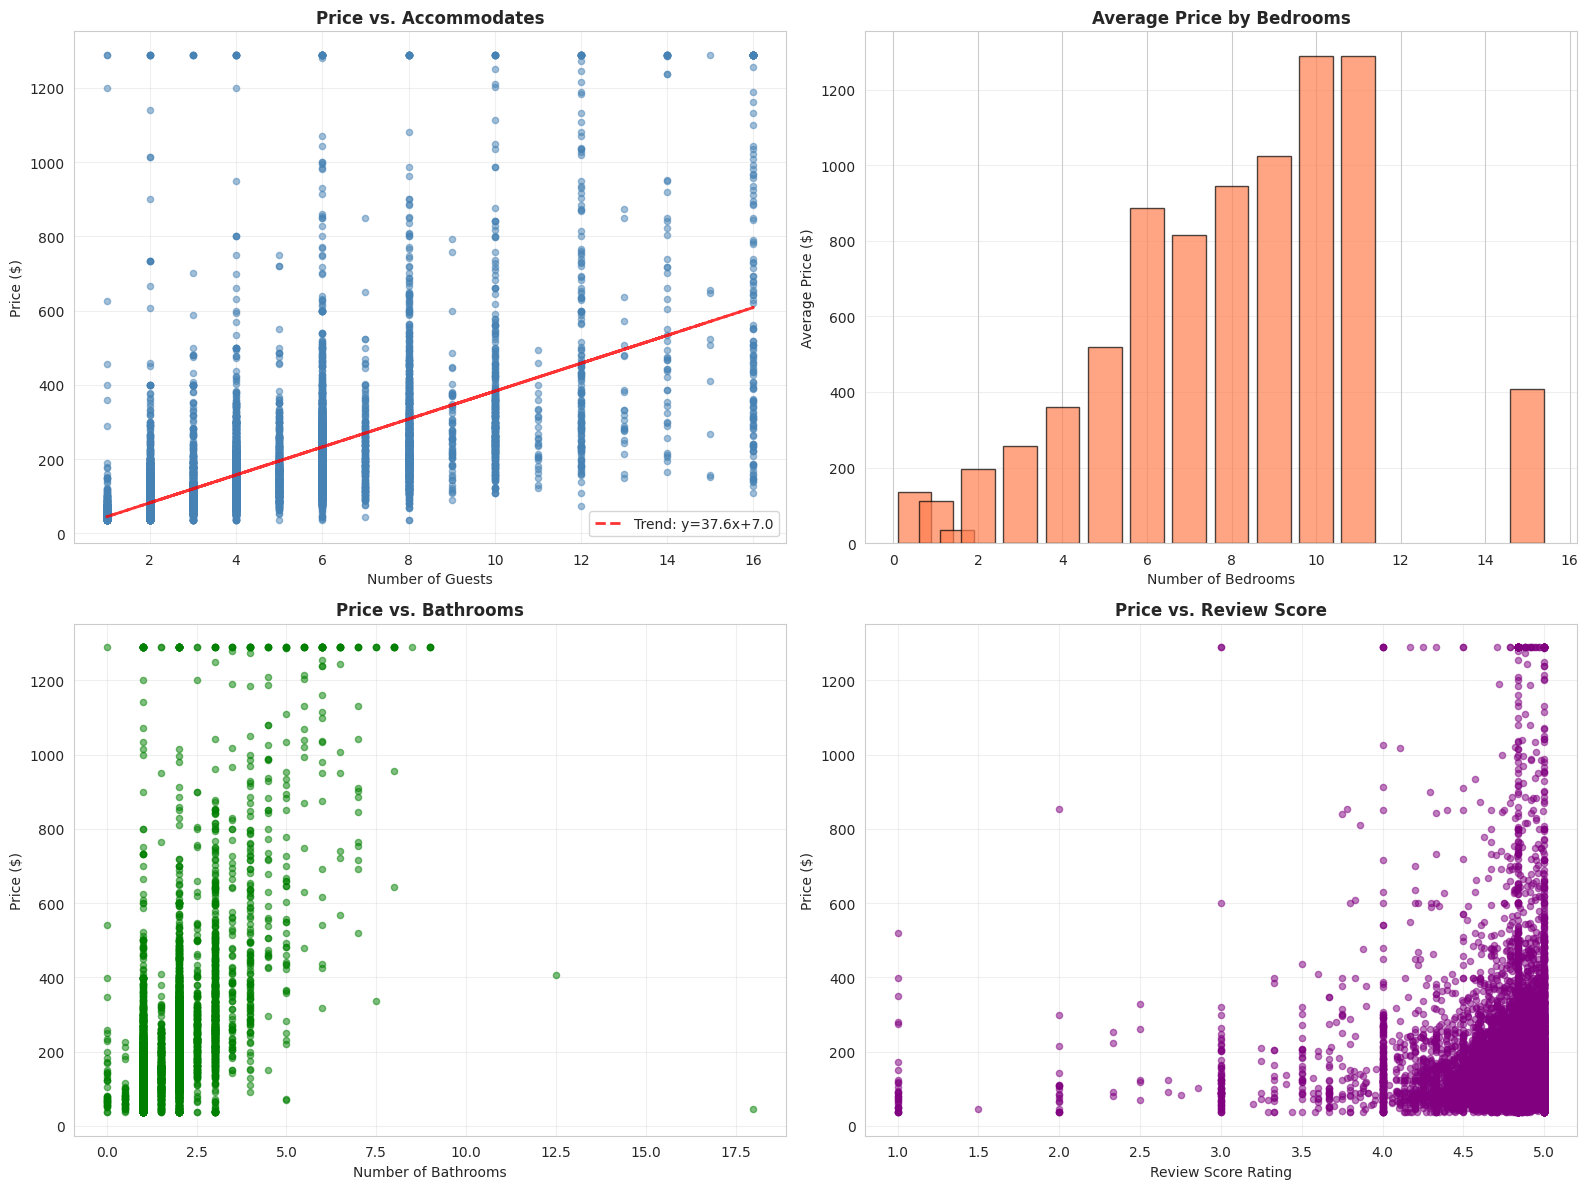


📊 Interpretation:
  • Strong positive correlation between accommodates and price
  • Linear relationship with bedrooms - each bedroom adds value
  • Bathrooms also show positive correlation
  • Review scores show weak correlation - quality matters but isn't everything


In [53]:
# Price vs. Accommodates, Bedrooms, Bathrooms
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Price vs. Accommodates
axes[0, 0].scatter(listings_df['accommodates'], listings_df['actual_price'], alpha=0.5, s=20, color='steelblue')
axes[0, 0].set_xlabel('Number of Guests')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].set_title('Price vs. Accommodates', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(listings_df['accommodates'], listings_df['actual_price'], 1)
p = np.poly1d(z)
axes[0, 0].plot(listings_df['accommodates'].unique(), p(listings_df['accommodates'].unique()),
                "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.1f}x+{z[1]:.1f}')
axes[0, 0].legend()

# Price vs. Bedrooms
bedroom_prices = listings_df.groupby('bedrooms')['actual_price'].mean().sort_index()
axes[0, 1].bar(bedroom_prices.index, bedroom_prices.values, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Number of Bedrooms')
axes[0, 1].set_ylabel('Average Price ($)')
axes[0, 1].set_title('Average Price by Bedrooms', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Price vs. Bathrooms
axes[1, 0].scatter(listings_df['bathrooms'], listings_df['actual_price'], alpha=0.5, s=20, color='green')
axes[1, 0].set_xlabel('Number of Bathrooms')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].set_title('Price vs. Bathrooms', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Price vs. Review Score
# Remove NaN values for this plot
review_data = listings_df[listings_df['review_scores_rating'].notna()]
axes[1, 1].scatter(review_data['review_scores_rating'], review_data['actual_price'], alpha=0.5, s=20, color='purple')
axes[1, 1].set_xlabel('Review Score Rating')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].set_title('Price vs. Review Score', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Strong positive correlation between accommodates and price")
print("  • Linear relationship with bedrooms - each bedroom adds value")
print("  • Bathrooms also show positive correlation")
print("  • Review scores show weak correlation - quality matters but isn't everything")

---
## 6. Correlation Analysis

In [54]:
# Select numeric columns for correlation
numeric_cols = listings_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns and other non-predictive features
exclude_cols = ['id', 'host_id', 'scrape_id', 'latitude', 'longitude', 'actual_price']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

# Calculate correlation matrix
correlation_matrix = listings_df[numeric_cols].corr()

# Find correlations with price
price_correlations = correlation_matrix['price'].sort_values(ascending=False)

print("="*80)
print("TOP 20 FEATURES CORRELATED WITH PRICE")
print("="*80)
print(price_correlations.head(20))

print("\n" + "="*80)
print("BOTTOM 10 FEATURES (NEGATIVE CORRELATION)")
print("="*80)
print(price_correlations.tail(10))

TOP 20 FEATURES CORRELATED WITH PRICE
price                         1.000000
accommodates                  0.696067
bedrooms                      0.668930
bathrooms                     0.640774
beds                          0.618740
amenity_count                 0.300494
waterfront                    0.289082
estimated_revenue_l365d       0.284885
kitchen                       0.283994
has_pool                      0.242838
pool                          0.182411
washer                        0.164762
has_ocean                     0.157129
review_scores_location        0.127000
maximum_nights                0.115726
has_beach                     0.103842
host_total_listings_count     0.103045
host_neighbourhood_present    0.098561
review_scores_rating          0.096001
review_scores_accuracy        0.082658
Name: price, dtype: float64

BOTTOM 10 FEATURES (NEGATIVE CORRELATION)
number_of_reviews                              -0.112146
has_parking                                    -0.1188

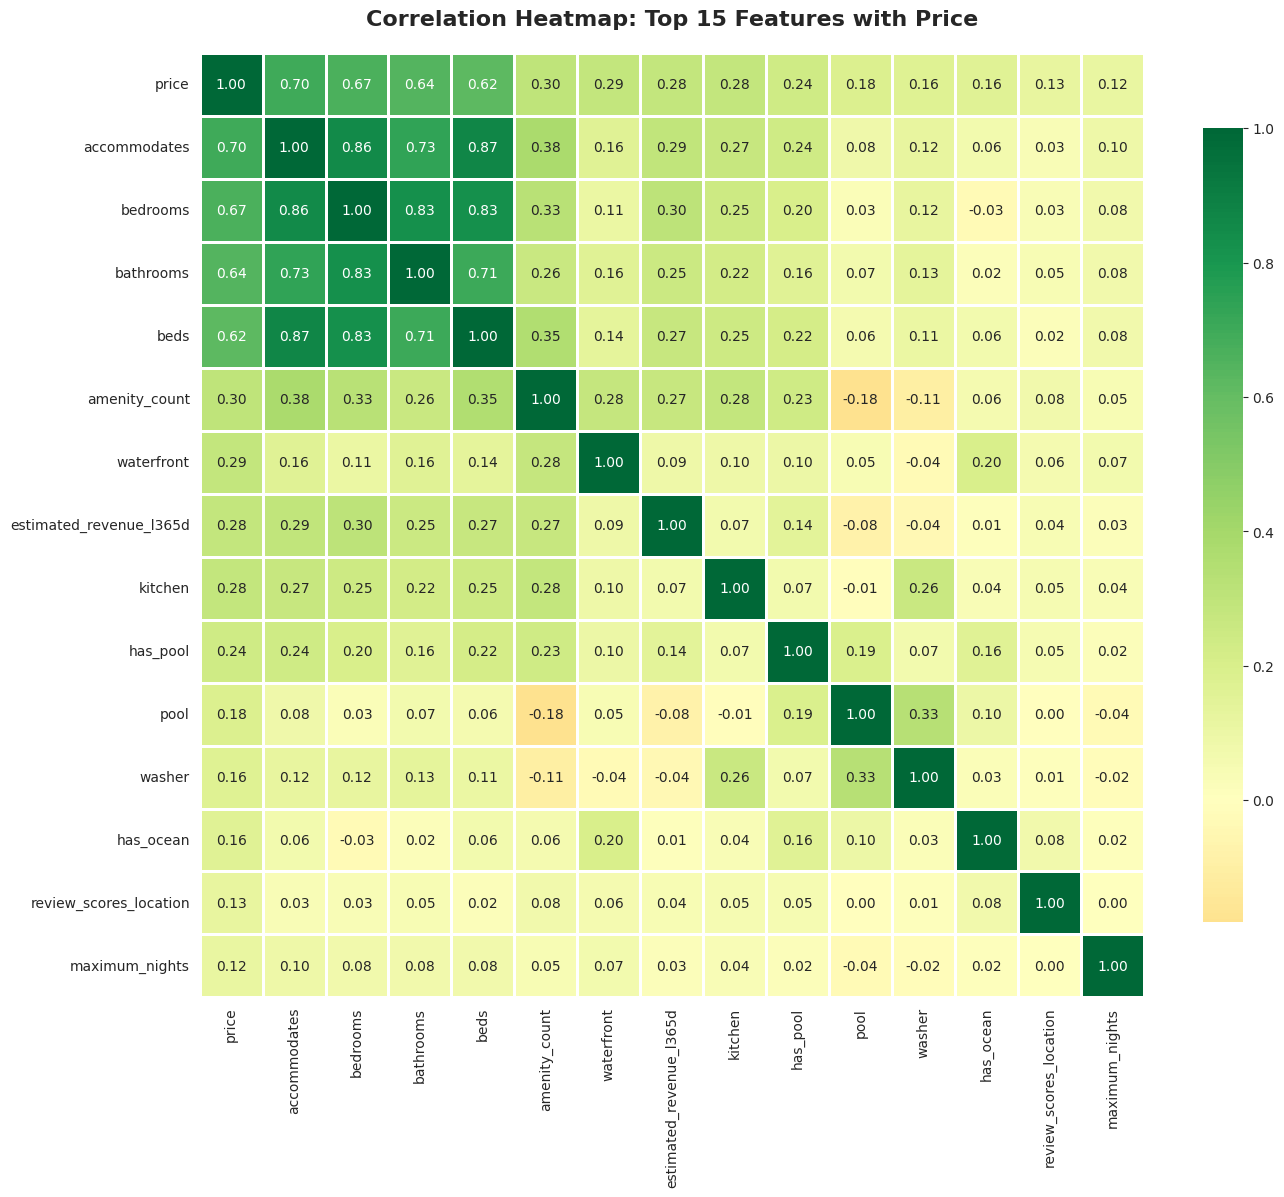


📊 Interpretation:
  • Accommodates, bedrooms, and beds show strongest positive correlations
  • Property characteristics (size) are primary price drivers
  • Review metrics show moderate positive correlation
  • Some engineered features (amenity_count) show promising correlations
  • Multicollinearity exists (bedrooms/beds/accommodates) - may need feature selection


In [55]:
# Visualize correlation heatmap
# Select top correlated features with price
top_features = price_correlations.head(15).index.tolist()
corr_subset = listings_df[top_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Top 15 Features with Price', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Accommodates, bedrooms, and beds show strongest positive correlations")
print("  • Property characteristics (size) are primary price drivers")
print("  • Review metrics show moderate positive correlation")
print("  • Some engineered features (amenity_count) show promising correlations")
print("  • Multicollinearity exists (bedrooms/beds/accommodates) - may need feature selection")

---
## 7. Geographic Analysis: Price by Neighborhood

In [56]:
# Calculate average price by neighborhood
neighborhood_prices = listings_df.groupby('neighbourhood_cleansed').agg({
    'actual_price': ['mean', 'median', 'count']
}).round(2)

neighborhood_prices.columns = ['avg_price', 'median_price', 'count']
neighborhood_prices = neighborhood_prices.sort_values('avg_price', ascending=False)

print("="*80)
print("TOP 10 MOST EXPENSIVE NEIGHBORHOODS")
print("="*80)
display(neighborhood_prices.head(10))

print("\n" + "="*80)
print("TOP 10 MOST AFFORDABLE NEIGHBORHOODS")
print("="*80)
display(neighborhood_prices.tail(10))

TOP 10 MOST EXPENSIVE NEIGHBORHOODS


avg_price  median_price  count
neighbourhood_cleansed                                
Southwest Ranches          393.46         225.0     35
Plantation                 302.50         195.5     96
Parkland                   265.07         120.0     15
Lighthouse Point           232.91         216.0     57
Cooper City                230.57          79.5     36
Coral Springs              223.74         139.0     59
Hollywood                  196.14         154.0   3083
Davie                      194.17         105.0    131
Hillsboro Beach            192.07         175.5     28
Weston                     191.56         149.5     66


TOP 10 MOST AFFORDABLE NEIGHBORHOODS


avg_price  median_price  count
neighbourhood_cleansed                                
Sunrise                    122.45          86.0    184
Tamarac                    121.07          69.5     74
Lauderhill                 115.38          92.5    104
Dania Beach                111.23          86.0    375
Margate                    105.42          75.0     76
North Lauderdale            92.71          83.0     79
Sea Ranch Lakes             80.50          80.0      4
West Park                   76.18          61.0     67
Lauderdale Lakes            75.91          66.0     47
Pembroke Park               75.33          61.0     15

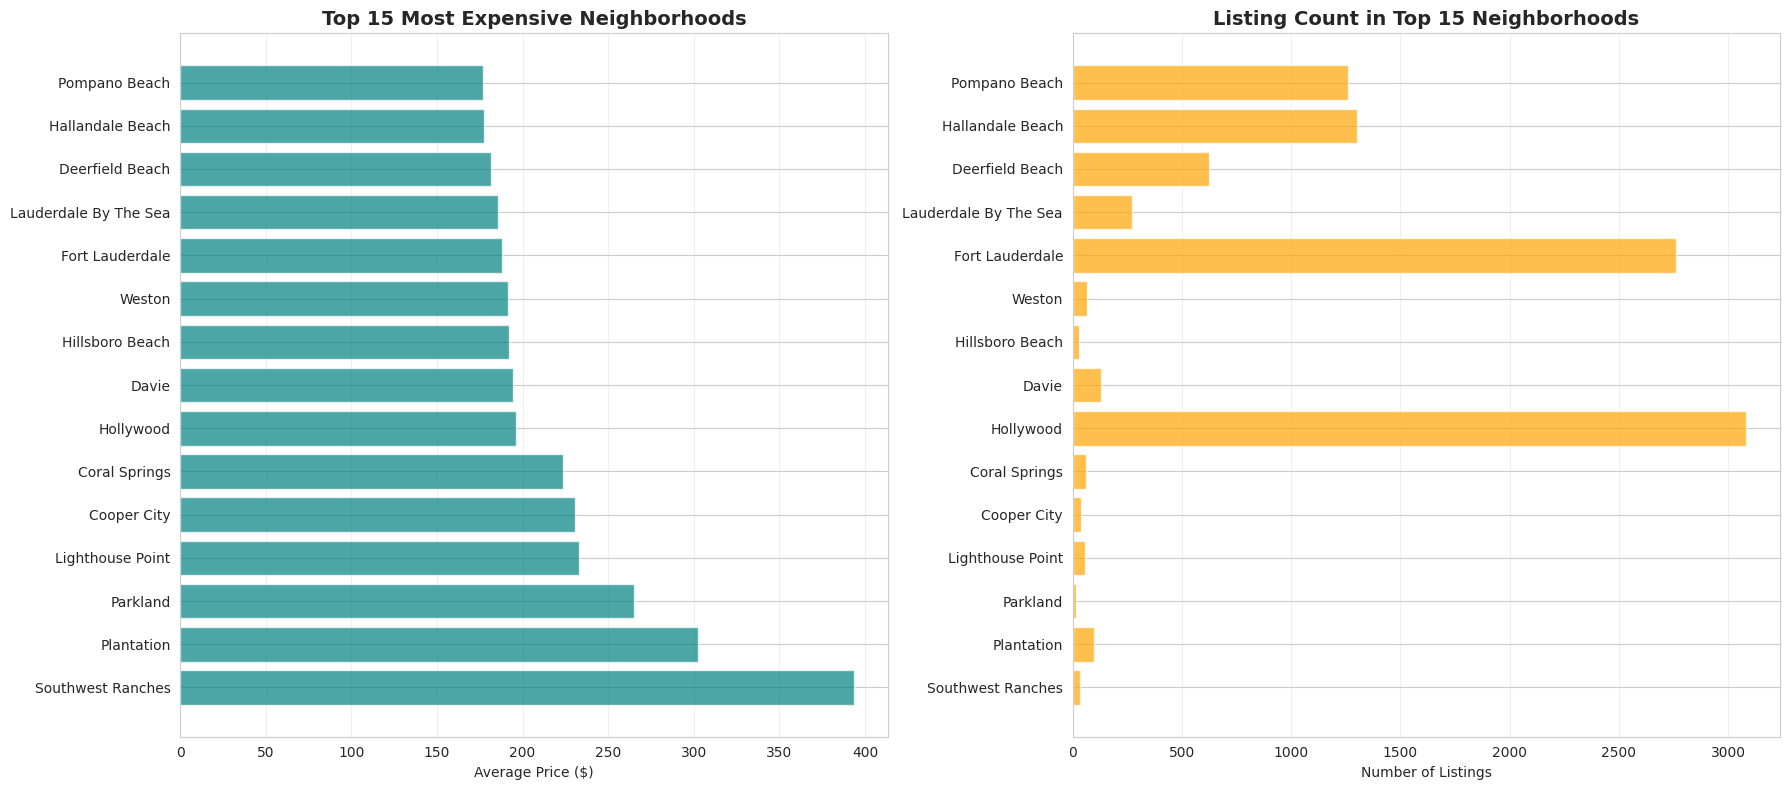


📊 Interpretation:
  • Significant price variation across neighborhoods (coastal vs. inland)
  • Beachfront cities (Fort Lauderdale, Hollywood) command premium prices
  • Location is clearly a key feature for modeling
  • Neighborhood will need one-hot encoding or target encoding for ML


In [57]:
# Visualize top 15 neighborhoods by price
top_15_neighborhoods = neighborhood_prices.head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Average price by neighborhood
axes[0].barh(range(len(top_15_neighborhoods)), top_15_neighborhoods['avg_price'], color='teal', alpha=0.7)
axes[0].set_yticks(range(len(top_15_neighborhoods)))
axes[0].set_yticklabels(top_15_neighborhoods.index)
axes[0].set_xlabel('Average Price ($)')
axes[0].set_title('Top 15 Most Expensive Neighborhoods', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Listing count by neighborhood
axes[1].barh(range(len(top_15_neighborhoods)), top_15_neighborhoods['count'], color='orange', alpha=0.7)
axes[1].set_yticks(range(len(top_15_neighborhoods)))
axes[1].set_yticklabels(top_15_neighborhoods.index)
axes[1].set_xlabel('Number of Listings')
axes[1].set_title('Listing Count in Top 15 Neighborhoods', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Significant price variation across neighborhoods (coastal vs. inland)")
print("  • Beachfront cities (Fort Lauderdale, Hollywood) command premium prices")
print("  • Location is clearly a key feature for modeling")
print("  • Neighborhood will need one-hot encoding or target encoding for ML")

---
## 8. Amenities and Features Impact

In [58]:
# Analyze engineered amenity features
amenity_features = ['pool', 'waterfront', 'parking', 'kitchen', 'washer', 'air_conditioning']

print("="*80)
print("IMPACT OF AMENITIES ON PRICE")
print("="*80)

amenity_impact = {}
for amenity in amenity_features:
    if amenity in listings_df.columns:
        with_amenity = listings_df[listings_df[amenity] == 1]['actual_price'].mean()
        without_amenity = listings_df[listings_df[amenity] == 0]['actual_price'].mean()
        diff = with_amenity - without_amenity
        pct_diff = (diff / without_amenity) * 100
        amenity_impact[amenity] = {'with': with_amenity, 'without': without_amenity,
                                   'diff': diff, 'pct_diff': pct_diff}
        print(f"\n{amenity.upper()}:")
        print(f"  With: ${with_amenity:.2f}")
        print(f"  Without: ${without_amenity:.2f}")
        print(f"  Difference: ${diff:.2f} ({pct_diff:+.1f}%)")

IMPACT OF AMENITIES ON PRICE

POOL:
  With: $217.29
  Without: $161.52
  Difference: $55.77 (+34.5%)

WATERFRONT:
  With: $271.31
  Without: $157.90
  Difference: $113.41 (+71.8%)

PARKING:
  With: $nan
  Without: $178.83
  Difference: $nan (+nan%)

KITCHEN:
  With: $191.83
  Without: $102.71
  Difference: $89.12 (+86.8%)

WASHER:
  With: $201.57
  Without: $161.20
  Difference: $40.37 (+25.0%)

AIR_CONDITIONING:
  With: $178.13
  Without: $180.13
  Difference: $-2.00 (-1.1%)


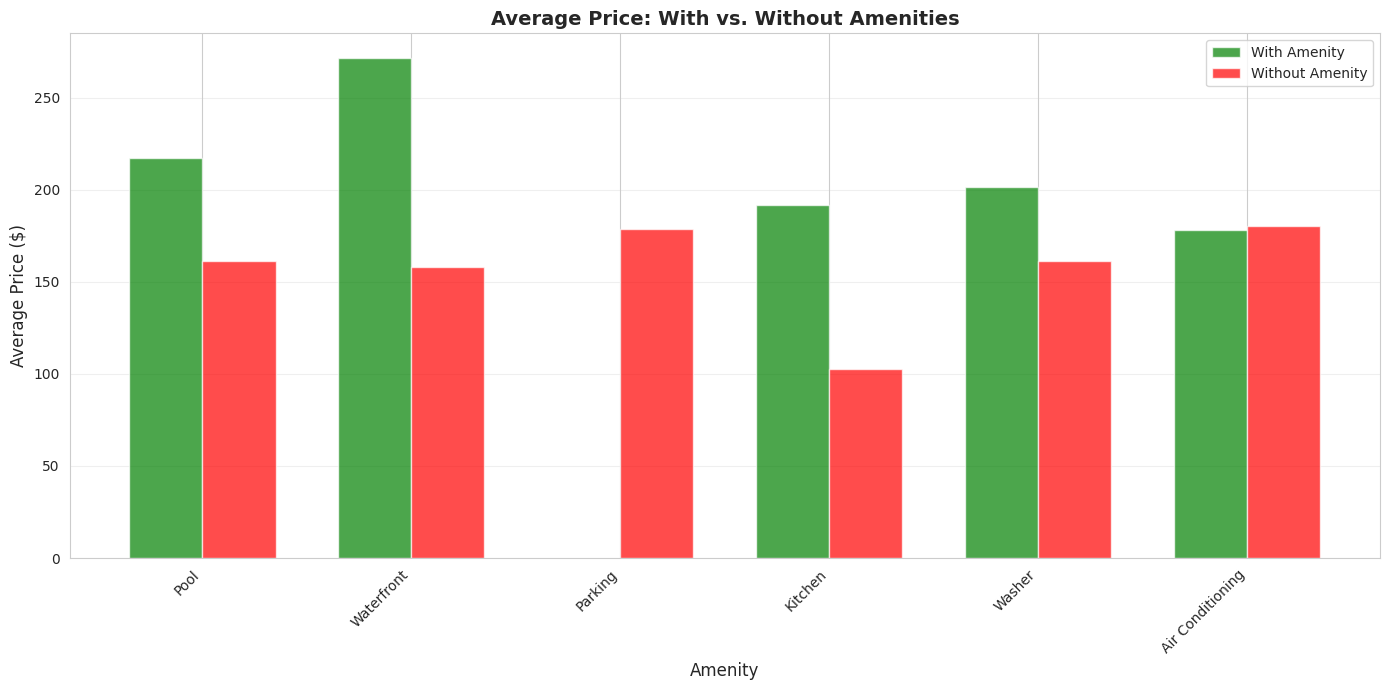


📊 Interpretation:
  • Pool and waterfront amenities show highest price premiums
  • Essential amenities (kitchen, AC) are nearly universal - less discriminating
  • Parking shows moderate impact - important for Broward County (car-dependent)
  • Luxury amenities (pool, waterfront) will be strong features in our model


In [59]:
# Visualize amenity impact
amenities = list(amenity_impact.keys())
price_with = [amenity_impact[a]['with'] for a in amenities]
price_without = [amenity_impact[a]['without'] for a in amenities]

x = np.arange(len(amenities))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
bars1 = ax.bar(x - width/2, price_with, width, label='With Amenity', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, price_without, width, label='Without Amenity', color='red', alpha=0.7)

ax.set_xlabel('Amenity', fontsize=12)
ax.set_ylabel('Average Price ($)', fontsize=12)
ax.set_title('Average Price: With vs. Without Amenities', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([a.replace('_', ' ').title() for a in amenities], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Pool and waterfront amenities show highest price premiums")
print("  • Essential amenities (kitchen, AC) are nearly universal - less discriminating")
print("  • Parking shows moderate impact - important for Broward County (car-dependent)")
print("  • Luxury amenities (pool, waterfront) will be strong features in our model")

---
## 9. Host Characteristics Analysis

SUPERHOST IMPACT ON PRICE AND REVIEWS


avg_price  median_price  avg_rating  avg_reviews  count
host_is_superhost                                                         
0                     178.59         124.0        4.68        30.30   7231
1                     179.18         138.0        4.87        66.51   4713

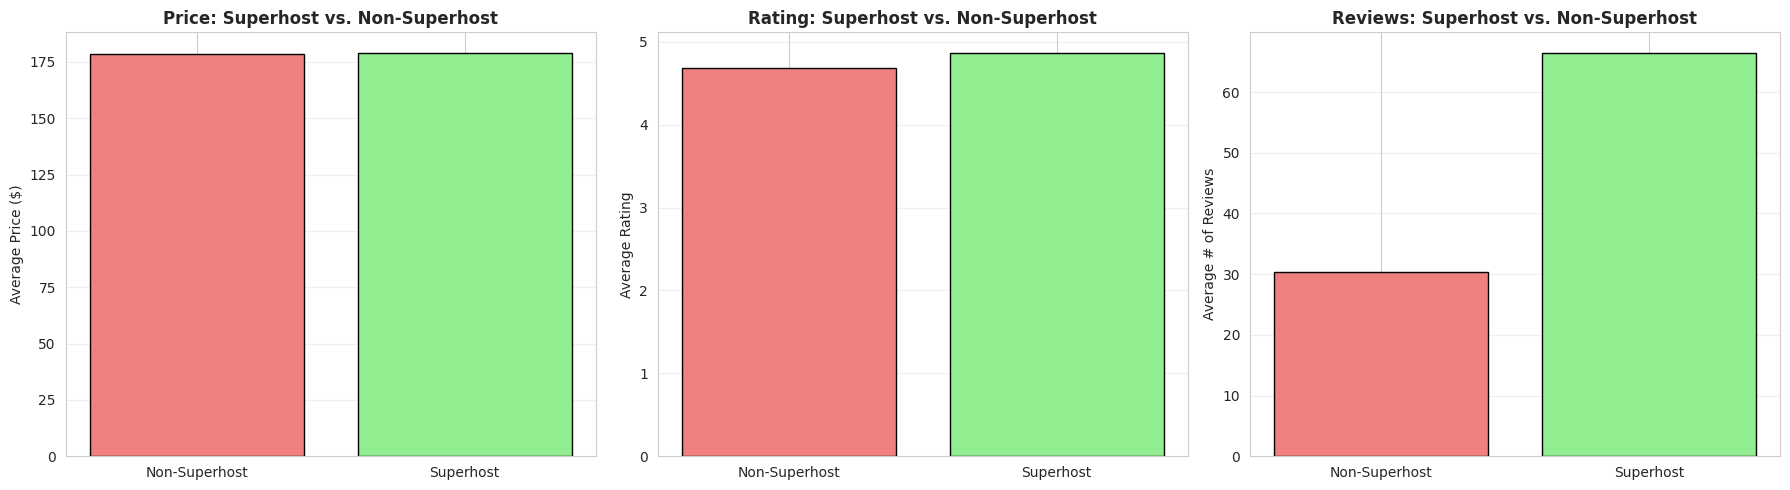


📊 Interpretation:
  • Superhosts command slightly higher prices (quality signal)
  • Superhosts have significantly higher ratings (by design)
  • Superhosts have more reviews (established presence)
  • Superhost status is a valuable feature for modeling


In [60]:
# Analyze superhost impact
print("="*80)
print("SUPERHOST IMPACT ON PRICE AND REVIEWS")
print("="*80)

superhost_stats = listings_df.groupby('host_is_superhost').agg({
    'actual_price': ['mean', 'median'],
    'review_scores_rating': 'mean',
    'number_of_reviews': 'mean',
    'id': 'count'
}).round(2)

superhost_stats.columns = ['avg_price', 'median_price', 'avg_rating', 'avg_reviews', 'count']
display(superhost_stats)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Price comparison
axes[0].bar(['Non-Superhost', 'Superhost'],
            [superhost_stats.loc[0, 'avg_price'], superhost_stats.loc[1, 'avg_price']],
            color=['lightcoral', 'lightgreen'], edgecolor='black')
axes[0].set_ylabel('Average Price ($)')
axes[0].set_title('Price: Superhost vs. Non-Superhost', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Rating comparison
axes[1].bar(['Non-Superhost', 'Superhost'],
            [superhost_stats.loc[0, 'avg_rating'], superhost_stats.loc[1, 'avg_rating']],
            color=['lightcoral', 'lightgreen'], edgecolor='black')
axes[1].set_ylabel('Average Rating')
axes[1].set_title('Rating: Superhost vs. Non-Superhost', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Review count comparison
axes[2].bar(['Non-Superhost', 'Superhost'],
            [superhost_stats.loc[0, 'avg_reviews'], superhost_stats.loc[1, 'avg_reviews']],
            color=['lightcoral', 'lightgreen'], edgecolor='black')
axes[2].set_ylabel('Average # of Reviews')
axes[2].set_title('Reviews: Superhost vs. Non-Superhost', fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Superhosts command slightly higher prices (quality signal)")
print("  • Superhosts have significantly higher ratings (by design)")
print("  • Superhosts have more reviews (established presence)")
print("  • Superhost status is a valuable feature for modeling")

---
## 10. Review Analysis

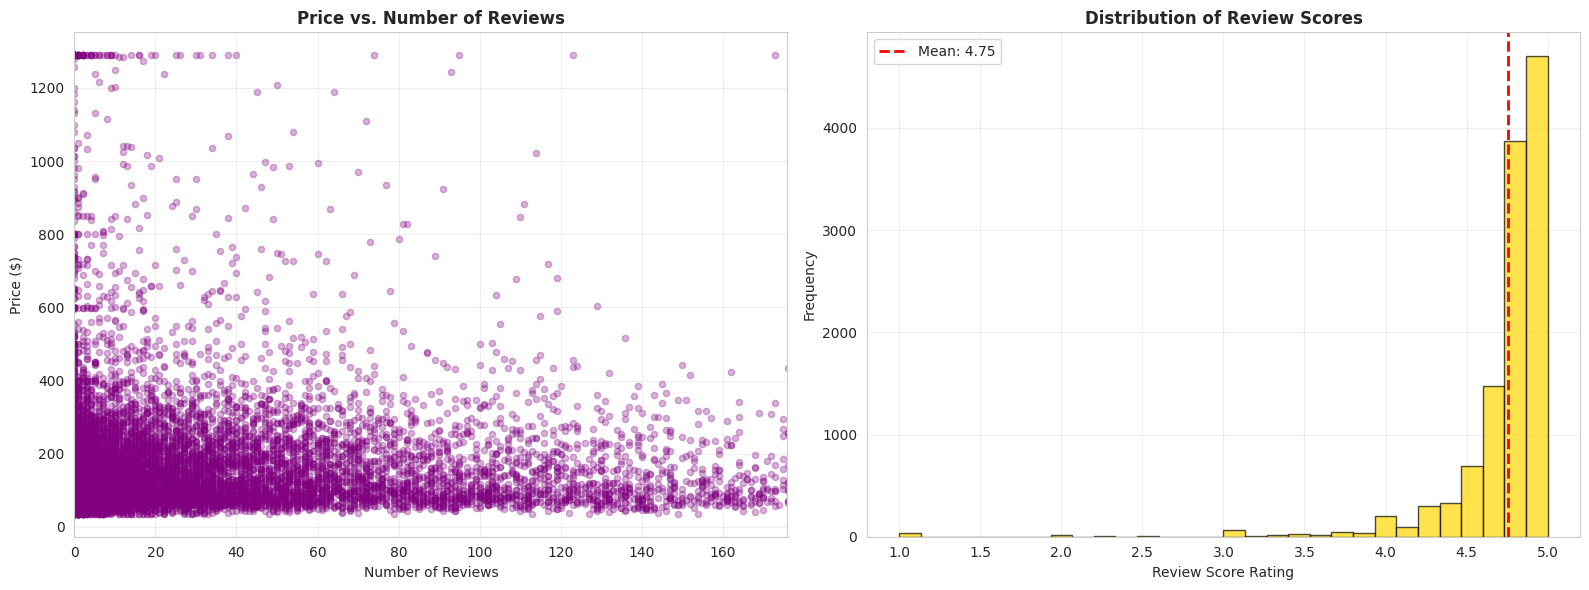


📊 Interpretation:
  • Weak correlation between number of reviews and price
  • Review scores are heavily skewed toward high ratings (positive bias)
  • Most listings have excellent reviews (4.5+)
  • Low review scores are rare but might be strong negative signals


In [61]:
# Analyze relationship between reviews and price
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Price vs number of reviews
axes[0].scatter(listings_df['number_of_reviews'], listings_df['actual_price'],
                alpha=0.3, s=20, color='purple')
axes[0].set_xlabel('Number of Reviews')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Price vs. Number of Reviews', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, listings_df['number_of_reviews'].quantile(0.95))  # Focus on main distribution

# Distribution of review scores
review_scores_clean = listings_df['review_scores_rating'].dropna()
axes[1].hist(review_scores_clean, bins=30, edgecolor='black', color='gold', alpha=0.7)
axes[1].set_xlabel('Review Score Rating')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Review Scores', fontweight='bold')
axes[1].axvline(review_scores_clean.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {review_scores_clean.mean():.2f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Weak correlation between number of reviews and price")
print("  • Review scores are heavily skewed toward high ratings (positive bias)")
print("  • Most listings have excellent reviews (4.5+)")
print("  • Low review scores are rare but might be strong negative signals")

---
## 11. Availability and Occupancy Patterns

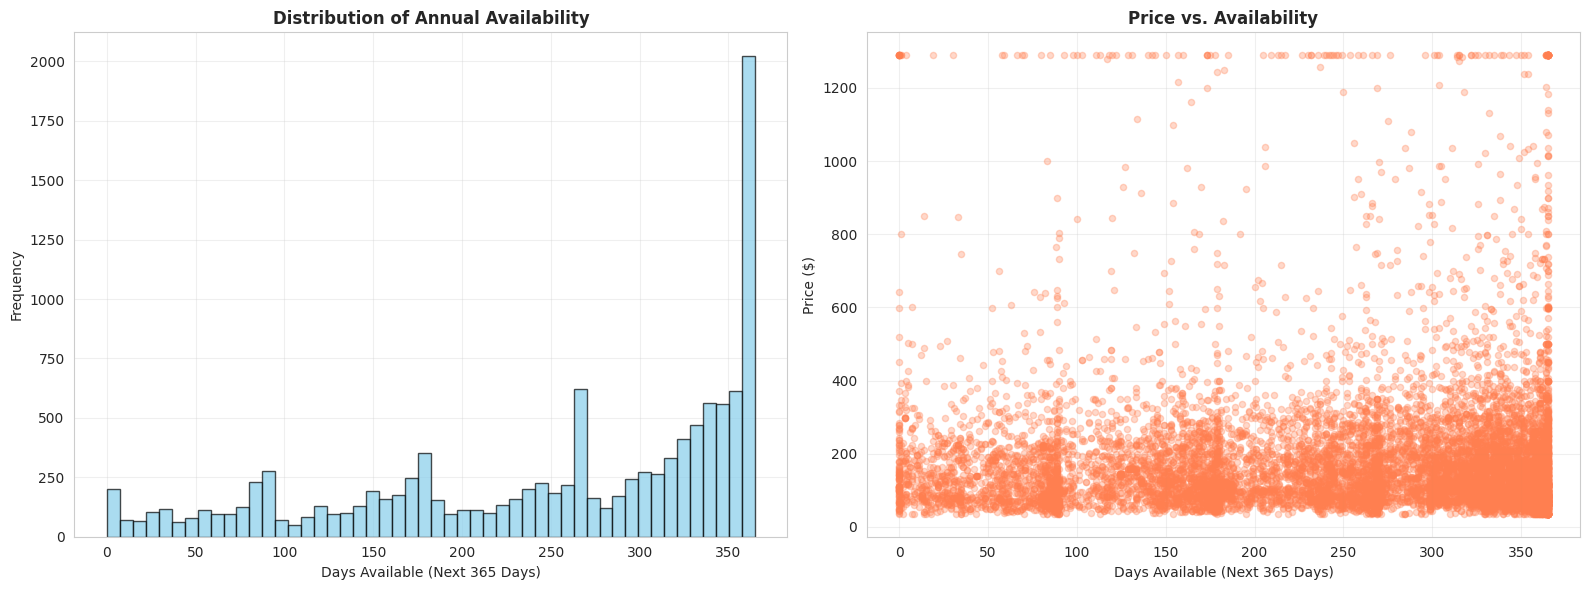


📊 Interpretation:
  • Bimodal distribution - some hosts block availability, others keep it open
  • Properties with very high availability might be struggling to book
  • Low availability might indicate high demand OR owner use
  • Availability could be feature but requires careful interpretation


In [62]:
# Analyze availability patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of availability_365
axes[0].hist(listings_df['availability_365'], bins=50, edgecolor='black', color='skyblue', alpha=0.7)
axes[0].set_xlabel('Days Available (Next 365 Days)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Annual Availability', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Price vs availability
axes[1].scatter(listings_df['availability_365'], listings_df['actual_price'],
                alpha=0.3, s=20, color='coral')
axes[1].set_xlabel('Days Available (Next 365 Days)')
axes[1].set_ylabel('Price ($)')
axes[1].set_title('Price vs. Availability', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Bimodal distribution - some hosts block availability, others keep it open")
print("  • Properties with very high availability might be struggling to book")
print("  • Low availability might indicate high demand OR owner use")
print("  • Availability could be feature but requires careful interpretation")

# SUMMARY STATISTICS

In [63]:
# Create summary statistics dictionary for report
summary_stats = {
    'Dataset': {
        'Total Listings': len(listings_df),
        'Total Features': len(listings_df.columns),
        'Engineered Features': 40,
        'Missing Values': listings_df.isnull().sum().sum()
    },
    'Price': {
        'Mean': f"${listings_df['actual_price'].mean():.2f}",
        'Median': f"${listings_df['actual_price'].median():.2f}",
        'Min': f"${listings_df['actual_price'].min():.2f}",
        'Max': f"${listings_df['actual_price'].max():.2f}"
    },
    'Top Correlations with Price': dict(price_correlations.head(5)),
    'Room Types': dict(listings_df['room_type'].value_counts()),
    'Neighborhoods': listings_df['neighbourhood_cleansed'].nunique()
}


In [64]:
from pprint import pprint
pprint(summary_stats)


{'Dataset': {'Engineered Features': 40,
             'Missing Values': np.int64(25563),
             'Total Features': 124,
             'Total Listings': 11944},
 'Neighborhoods': 33,
 'Price': {'Max': '$1289.42',
           'Mean': '$178.83',
           'Median': '$130.00',
           'Min': '$36.00'},
 'Room Types': {'entire home/apt': np.int64(9989),
                'other': np.int64(99),
                'private room': np.int64(1856)},
 'Top Correlations with Price': {'accommodates': np.float64(0.6960665053124955),
                                 'bathrooms': np.float64(0.6407744733751882),
                                 'bedrooms': np.float64(0.6689301056572351),
                                 'beds': np.float64(0.6187402794755116),
                                 'price': np.float64(1.0)}}


## **PRICE PREDICTION MODELING**

## 1. Setup and Imports

## 2. Data Preparation

In [65]:
# Use existing dataframe
df_model = listings_df.copy()
print(f"Dataset: {df_model.shape[0]:,} rows")
print(f"Price stats:{df_model['price'].describe()}")

Dataset: 11,944 rows
Price stats:count    11944.000000
mean         4.932175
std          0.665727
min          3.610918
25%          4.442651
50%          4.875197
75%          5.342334
max          7.162723
Name: price, dtype: float64


## 3. Feature Selection

In [66]:
# Select features
numerical_features = []
potential_num = ['accommodates', 'bedrooms', 'bathrooms', 'beds',
                 'minimum_nights', 'number_of_reviews', 'review_scores_rating',
                 'reviews_per_month', 'calculated_host_listings_count',
                 'latitude', 'longitude', 'availability_365']

for col in potential_num:
    if col in df_model.columns:
        numerical_features.append(col)

categorical_features = []
potential_cat = ['room_type', 'property_type', 'neighbourhood_cleansed',
                 'host_is_superhost', 'instant_bookable']

for col in potential_cat:
    if col in df_model.columns:
        categorical_features.append(col)

print(f"Numerical ({len(numerical_features)}): {numerical_features}")
print(f"Categorical ({len(categorical_features)}): {categorical_features}")

all_features = numerical_features + categorical_features
X = df_model[all_features].copy()
y = df_model['price'].copy()
print(f"\nX: {X.shape}, y: {y.shape}")

Numerical (12): ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month', 'calculated_host_listings_count', 'latitude', 'longitude', 'availability_365']
Categorical (5): ['room_type', 'property_type', 'neighbourhood_cleansed', 'host_is_superhost', 'instant_bookable']

X: (11944, 17), y: (11944,)


In [67]:
# Handle missing & encode
for col in numerical_features:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

for col in categorical_features:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].mode()[0], inplace=True)

if len(categorical_features) > 0:
    X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
else:
    X_encoded = X.copy()

print(f"Encoded: {X_encoded.shape[1]} features")

Encoded: 58 features


## 4. Train-Test Split

In [68]:
# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape[0]:,}")
print(f"Test: {X_test.shape[0]:,}")

Train: 9,555
Test: 2,389


In [69]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Scaled!")

Scaled!


# **BASELINE MODEL: LINEAR REGRESSION**
## 5. Linear Regression Baseline

In [70]:
# Train LR
print('Training Linear Regression...')
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)
print('Trained!')

Training Linear Regression...
Trained!


In [71]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name, set_name='Test'):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{'='*60}")
    print(f"{model_name} - {set_name} Set")
    print(f"{'='*60}")
    print(f"MAE:  ${mae:,.2f}")
    print(f"MSE:  ${mse:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R²:   {r2:.4f}")
    print(f"{'='*60}")
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

lr_train_metrics = evaluate_model(y_train, y_train_pred_lr, 'Linear Regression', 'Training')
lr_test_metrics = evaluate_model(y_test, y_test_pred_lr, 'Linear Regression', 'Test')

Linear Regression - Training Set
MAE:  $0.30
MSE:  $0.16
RMSE: $0.40
R²:   0.6392
Linear Regression - Test Set
MAE:  $0.31
MSE:  $0.18
RMSE: $0.43
R²:   0.5960


### Baseline Visualizations

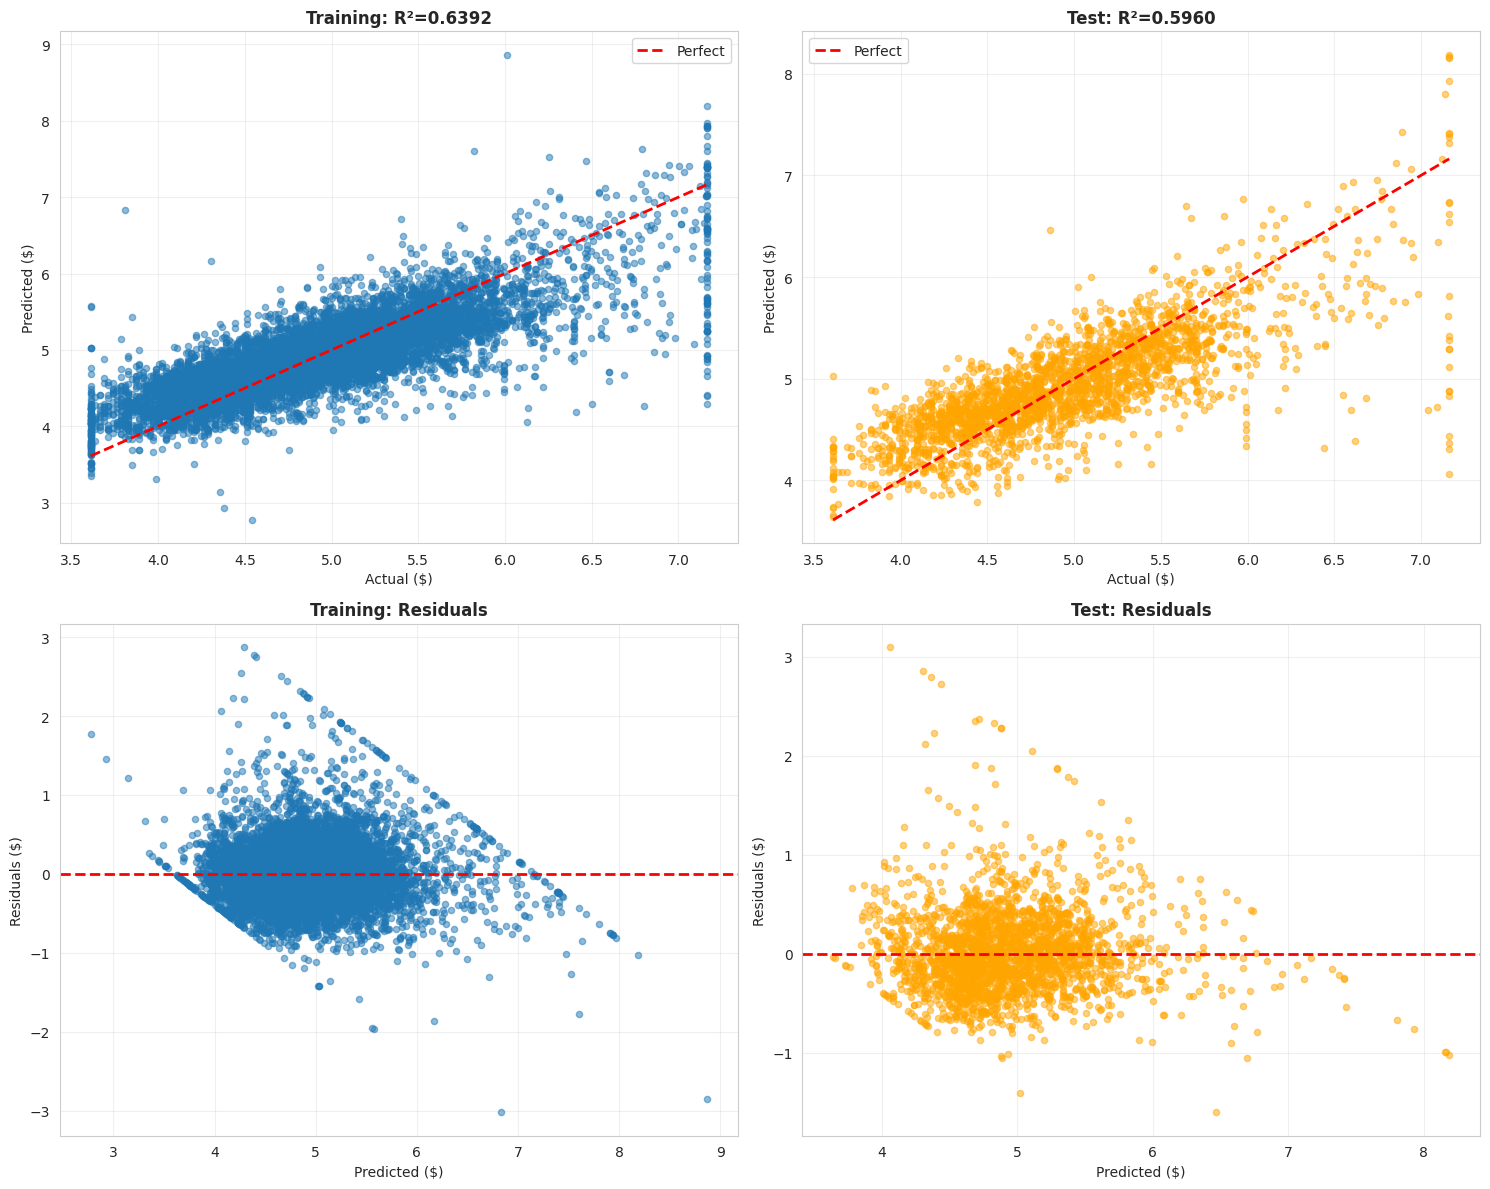

In [72]:
# Visualize LR
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(y_train, y_train_pred_lr, alpha=0.5, s=20)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect')
axes[0, 0].set_xlabel('Actual ($)')
axes[0, 0].set_ylabel('Predicted ($)')
axes[0, 0].set_title(f'Training: R²={lr_train_metrics["R2"]:.4f}', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_test, y_test_pred_lr, alpha=0.5, s=20, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect')
axes[0, 1].set_xlabel('Actual ($)')
axes[0, 1].set_ylabel('Predicted ($)')
axes[0, 1].set_title(f'Test: R²={lr_test_metrics["R2"]:.4f}', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

residuals_train = y_train - y_train_pred_lr
axes[1, 0].scatter(y_train_pred_lr, residuals_train, alpha=0.5, s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted ($)')
axes[1, 0].set_ylabel('Residuals ($)')
axes[1, 0].set_title('Training: Residuals', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

residuals_test = y_test - y_test_pred_lr
axes[1, 1].scatter(y_test_pred_lr, residuals_test, alpha=0.5, s=20, color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted ($)')
axes[1, 1].set_ylabel('Residuals ($)')
axes[1, 1].set_title('Test: Residuals', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

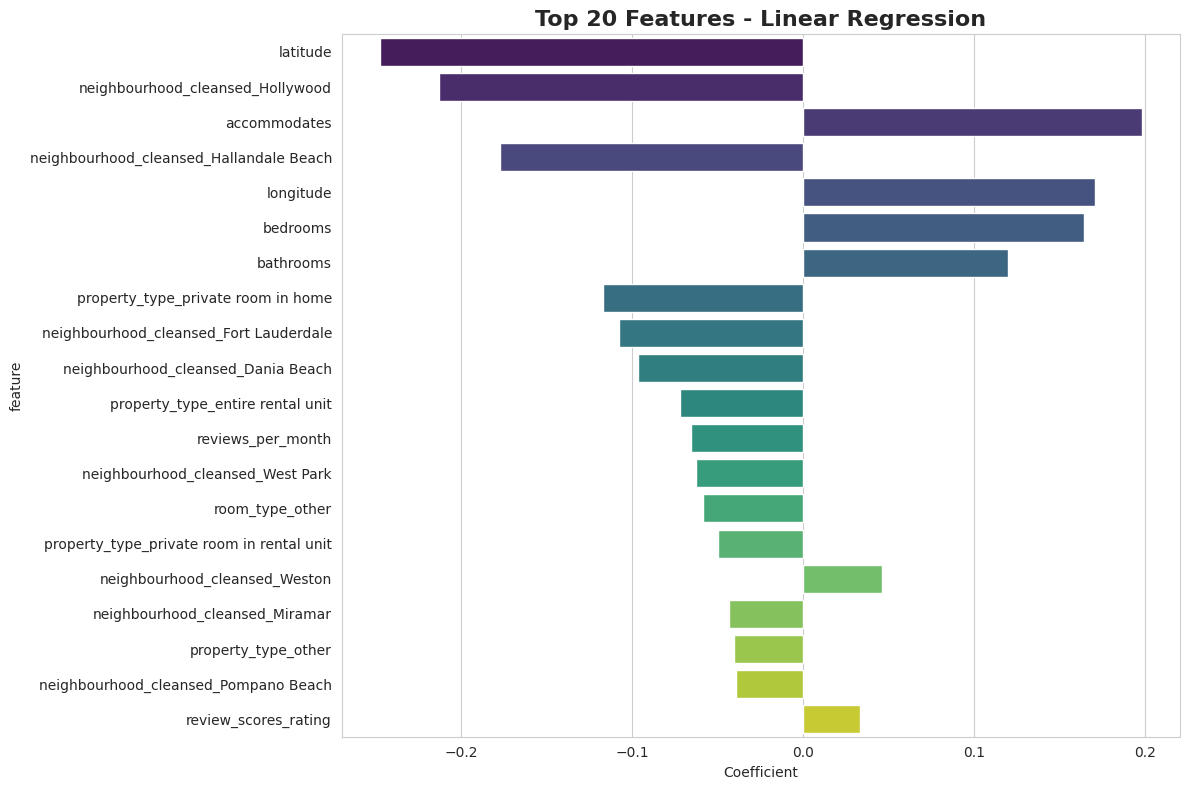

Top 10:
                                feature  coefficient
                               latitude    -0.247502
       neighbourhood_cleansed_Hollywood    -0.213034
                           accommodates     0.198196
neighbourhood_cleansed_Hallandale Beach    -0.177430
                              longitude     0.170662
                               bedrooms     0.164306
                              bathrooms     0.119920
     property_type_private room in home    -0.116857
 neighbourhood_cleansed_Fort Lauderdale    -0.107320
     neighbourhood_cleansed_Dania Beach    -0.096277


In [73]:
# Feature importance
feat_imp = pd.DataFrame({'feature': X_encoded.columns, 'coefficient': lr_model.coef_}).sort_values('coefficient', key=abs, ascending=False)

plt.figure(figsize=(12, 8))
top_n = min(20, len(feat_imp))
sns.barplot(data=feat_imp.head(top_n), x='coefficient', y='feature', palette='viridis')
plt.title('Top 20 Features - Linear Regression', fontsize=16, fontweight='bold')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.show()

print('Top 10:'); print(feat_imp.head(10).to_string(index=False))

### **FEATURE ENGINEERING**
## 6. Create Advanced Features

In [74]:
# Feature engineering
X_eng = X.copy()

if 'accommodates' in X.columns and 'bedrooms' in X.columns:
    X_eng['accom_per_bedroom'] = X['accommodates'] / (X['bedrooms'] + 1)

if 'bathrooms' in X.columns and 'bedrooms' in X.columns:
    X_eng['bath_bed_ratio'] = X['bathrooms'] / (X['bedrooms'] + 1)

if 'beds' in X.columns and 'accommodates' in X.columns:
    X_eng['beds_per_accom'] = X['beds'] / (X['accommodates'] + 1)

space_cols = [c for c in ['bedrooms', 'bathrooms', 'beds'] if c in X.columns]
if space_cols:
    X_eng['total_space'] = X[space_cols].sum(axis=1)

if 'number_of_reviews' in X.columns and 'reviews_per_month' in X.columns:
    X_eng['listing_age'] = X['number_of_reviews'] / (X['reviews_per_month'] + 0.1)

if 'review_scores_rating' in X.columns and 'number_of_reviews' in X.columns:
    X_eng['weighted_rating'] = X['review_scores_rating'] * np.log1p(X['number_of_reviews'])

if 'availability_365' in X.columns:
    X_eng['high_avail'] = (X['availability_365'] > 180).astype(int)
    X_eng['low_avail'] = (X['availability_365'] < 90).astype(int)

if 'latitude' in X.columns and 'longitude' in X.columns:
    center_lat = X['latitude'].median()
    center_lon = X['longitude'].median()
    X_eng['dist_center'] = np.sqrt((X['latitude'] - center_lat)**2 + (X['longitude'] - center_lon)**2)

print(f'Original: {X.shape[1]}, Engineered: {X_eng.shape[1]}, New: {X_eng.shape[1] - X.shape[1]}')

Original: 17, Engineered: 26, New: 9


In [75]:
# Prepare engineered
X_eng.fillna(X_eng.median(numeric_only=True), inplace=True)

if len(categorical_features) > 0:
    X_eng_encoded = pd.get_dummies(X_eng, columns=categorical_features, drop_first=True)
else:
    X_eng_encoded = X_eng.copy()

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng_encoded, y, test_size=0.2, random_state=42)

scaler_eng = StandardScaler()
X_train_eng_scaled = scaler_eng.fit_transform(X_train_eng)
X_test_eng_scaled = scaler_eng.transform(X_test_eng)

print(f'Engineered: {X_eng_encoded.shape}')

Engineered: (11944, 67)


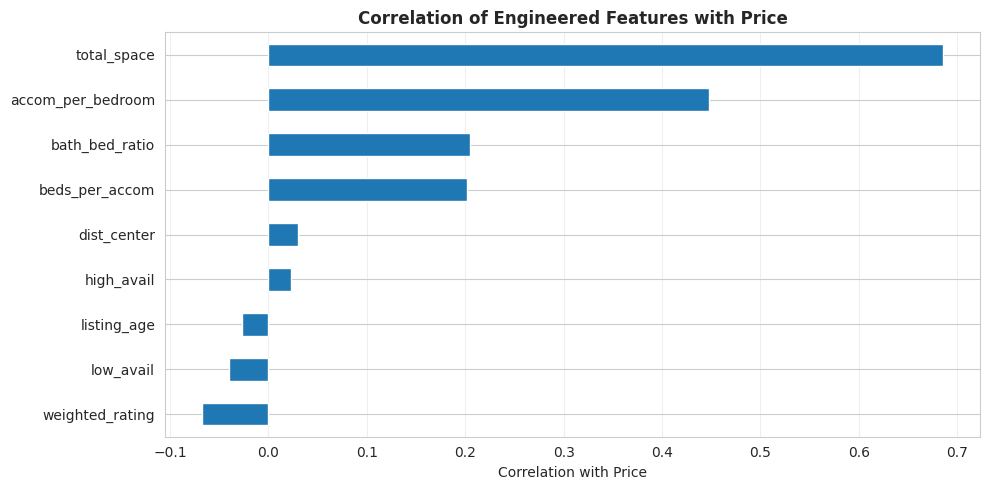

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Identify engineered columns
engineered_cols = [c for c in X_eng.columns if c not in X.columns]

# Correlation with target
corrs = X_eng[engineered_cols].join(y).corr()['price'].drop('price')  # replace 'price' if your target column is named differently

plt.figure(figsize=(10, 5))
corrs.sort_values().plot(kind='barh')
plt.title('Correlation of Engineered Features with Price', fontweight='bold')
plt.xlabel('Correlation with Price')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## **ADVANCED MODEL: RANDOM FOREST**
7. Random Forest with Cross-Validation

In [77]:
# Train RF
print('Training Random Forest...')
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', random_state=42, n_jobs=-1, verbose=1)

rf_model.fit(X_train_eng_scaled, y_train_eng)

y_train_pred_rf = rf_model.predict(X_train_eng_scaled)
y_test_pred_rf = rf_model.predict(X_test_eng_scaled)
print('RF trained!')

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


RF trained!


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


### Cross-Validation

In [78]:
# 5-fold CV
print('5-fold cross-validation...')
cv_scores = cross_val_score(rf_model, X_train_eng_scaled, y_train_eng, cv=5, scoring='r2', n_jobs=-1)
print(f'CV R²: {cv_scores}')
print(f'Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')

cv_mae = -cross_val_score(rf_model, X_train_eng_scaled, y_train_eng, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
print(f'Mean MAE: ${cv_mae.mean():,.2f} (+/- ${cv_mae.std() * 2:,.2f})')

5-fold cross-validation...
CV R²: [0.71842727 0.72507301 0.7302592  0.76201086 0.71936828]
Mean: 0.7310 (+/- 0.0321)
Mean MAE: $0.25 (+/- $0.01)


In [79]:
# Evaluate RF
rf_train_metrics = evaluate_model(y_train_eng, y_train_pred_rf, 'Random Forest', 'Training')
rf_test_metrics = evaluate_model(y_test_eng, y_test_pred_rf, 'Random Forest', 'Test')

Random Forest - Training Set
MAE:  $0.19
MSE:  $0.07
RMSE: $0.27
R²:   0.8397
Random Forest - Test Set
MAE:  $0.26
MSE:  $0.14
RMSE: $0.37
R²:   0.6929


### Random Forest Visualizations

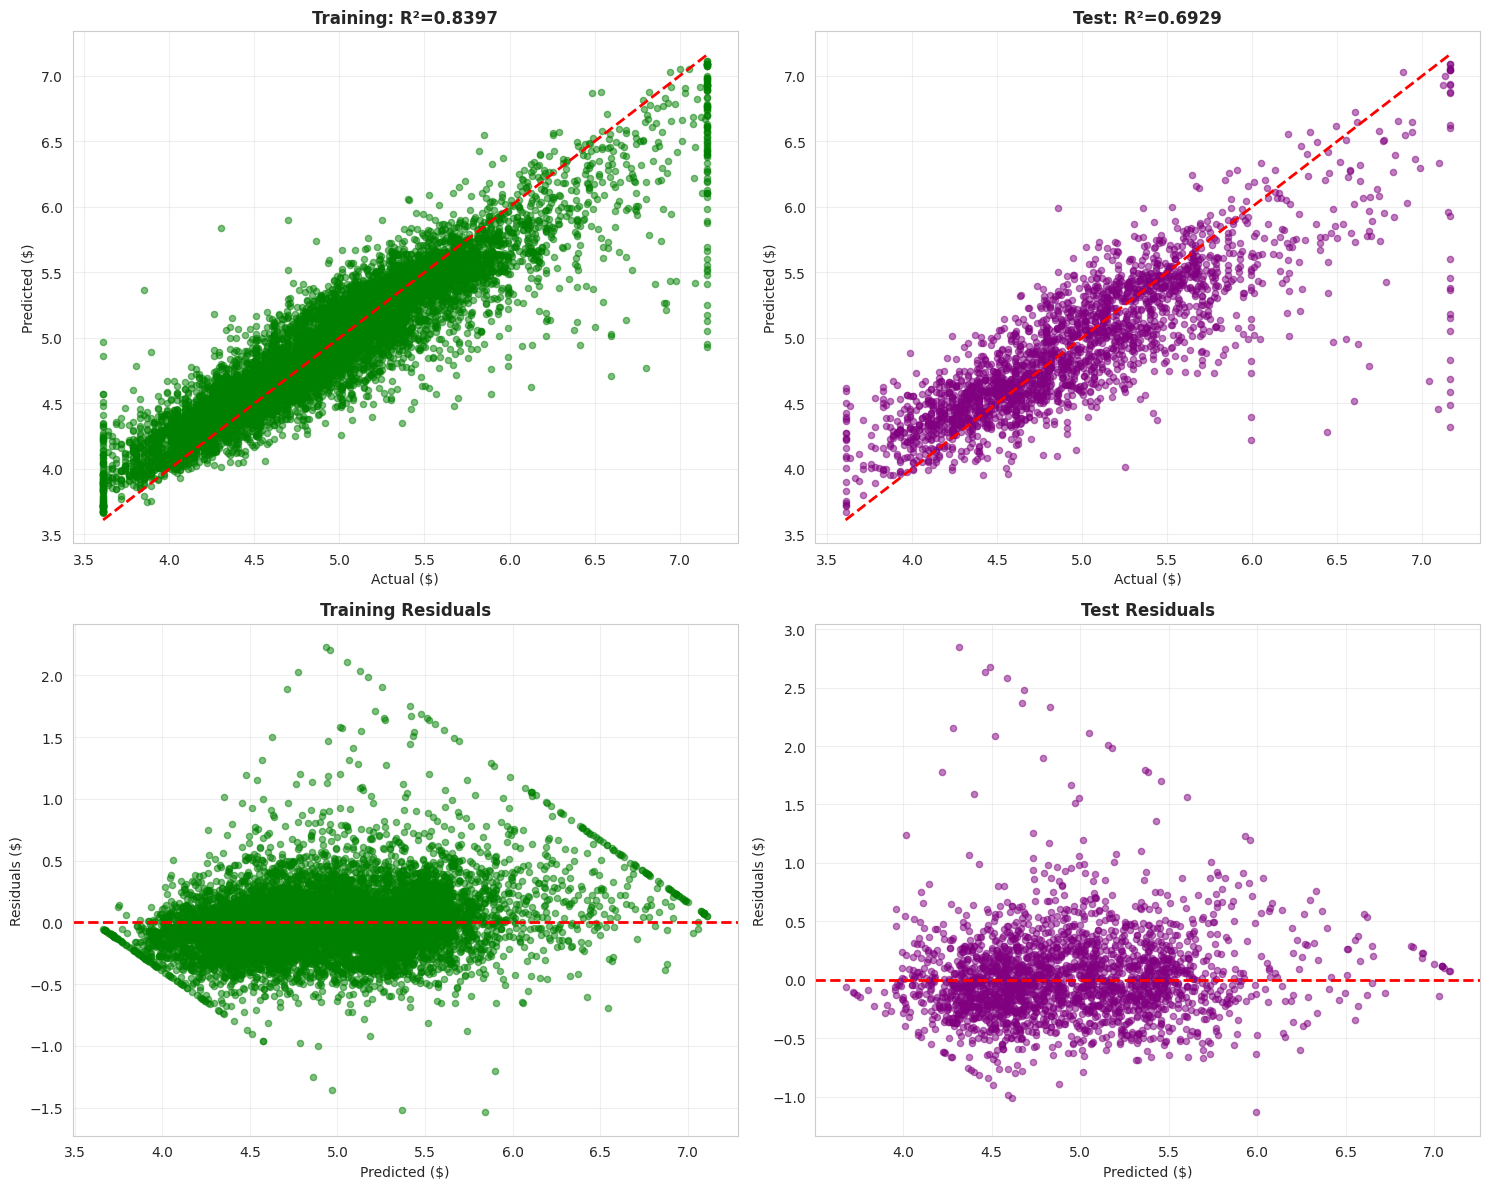

In [80]:
# RF visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(y_train_eng, y_train_pred_rf, alpha=0.5, s=20, color='green')
axes[0, 0].plot([y_train_eng.min(), y_train_eng.max()], [y_train_eng.min(), y_train_eng.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual ($)')
axes[0, 0].set_ylabel('Predicted ($)')
axes[0, 0].set_title(f'Training: R²={rf_train_metrics["R2"]:.4f}', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_test_eng, y_test_pred_rf, alpha=0.5, s=20, color='purple')
axes[0, 1].plot([y_test_eng.min(), y_test_eng.max()], [y_test_eng.min(), y_test_eng.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual ($)')
axes[0, 1].set_ylabel('Predicted ($)')
axes[0, 1].set_title(f'Test: R²={rf_test_metrics["R2"]:.4f}', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

residuals_train_rf = y_train_eng - y_train_pred_rf
axes[1, 0].scatter(y_train_pred_rf, residuals_train_rf, alpha=0.5, s=20, color='green')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted ($)')
axes[1, 0].set_ylabel('Residuals ($)')
axes[1, 0].set_title('Training Residuals', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

residuals_test_rf = y_test_eng - y_test_pred_rf
axes[1, 1].scatter(y_test_pred_rf, residuals_test_rf, alpha=0.5, s=20, color='purple')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted ($)')
axes[1, 1].set_ylabel('Residuals ($)')
axes[1, 1].set_title('Test Residuals', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

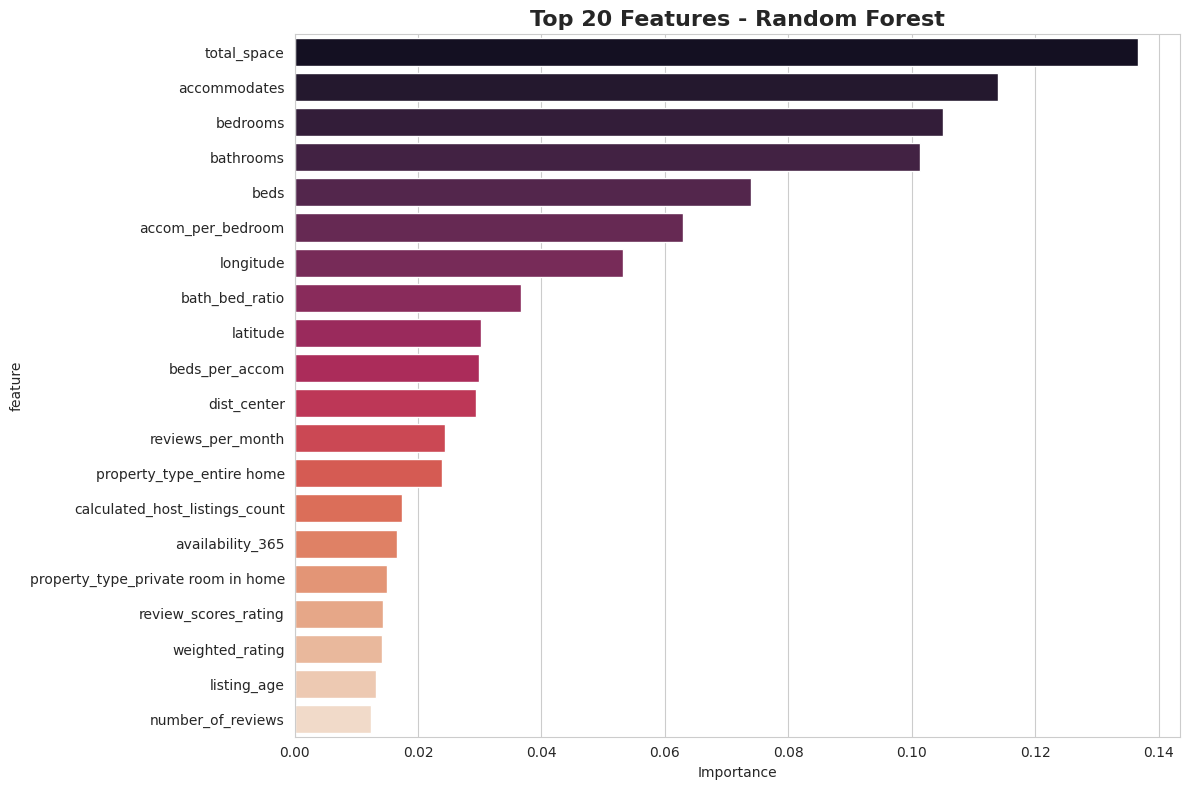

Top 15:
                       feature  importance
                   total_space    0.136597
                  accommodates    0.114019
                      bedrooms    0.104991
                     bathrooms    0.101301
                          beds    0.073999
             accom_per_bedroom    0.062994
                     longitude    0.053210
                bath_bed_ratio    0.036672
                      latitude    0.030240
                beds_per_accom    0.029811
                   dist_center    0.029422
             reviews_per_month    0.024371
     property_type_entire home    0.023902
calculated_host_listings_count    0.017447
              availability_365    0.016564


In [81]:
# RF Feature importance
feat_imp_rf = pd.DataFrame({'feature': X_eng_encoded.columns, 'importance': rf_model.feature_importances_}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
top_n = min(20, len(feat_imp_rf))
sns.barplot(data=feat_imp_rf.head(top_n), x='importance', y='feature', palette='rocket')
plt.title('Top 20 Features - Random Forest', fontsize=16, fontweight='bold')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print('Top 15:'); print(feat_imp_rf.head(15).to_string(index=False))

## 8. Gradient Boosting

In [82]:
# Train GB
print('Training Gradient Boosting...')
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, min_samples_split=10, min_samples_leaf=4, subsample=0.8, random_state=42, verbose=1)

gb_model.fit(X_train_eng_scaled, y_train_eng)

y_train_pred_gb = gb_model.predict(X_train_eng_scaled)
y_test_pred_gb = gb_model.predict(X_test_eng_scaled)
print('GB trained!')

Training Gradient Boosting...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.3824           0.0534            7.54s
         2           0.3422           0.0577            8.37s
         3           0.3023           0.0199            8.94s
         4           0.2763           0.0465            8.34s
         5           0.2531           0.0309            7.98s
         6           0.2314           0.0161            8.37s
         7           0.2091          -0.0040            8.12s
         8           0.2009           0.0418            8.09s
         9           0.1921           0.0237            8.06s
        10           0.1760          -0.0108            8.11s
        20           0.1263          -0.0088            7.31s
        30           0.1085          -0.0109            6.74s
        40           0.1010           0.0070            6.10s
        50           0.0931          -0.0052            4.84s
        60           0.0890          -0

In [83]:
# Evaluate GB
gb_train_metrics = evaluate_model(y_train_eng, y_train_pred_gb, 'Gradient Boosting', 'Training')
gb_test_metrics = evaluate_model(y_test_eng, y_test_pred_gb, 'Gradient Boosting', 'Test')

print('CV...')
cv_gb = cross_val_score(gb_model, X_train_eng_scaled, y_train_eng, cv=5, scoring='r2', n_jobs=-1)
print(f'Mean CV R²: {cv_gb.mean():.4f} (+/- {cv_gb.std() * 2:.4f})')

Gradient Boosting - Training Set
MAE:  $0.21
MSE:  $0.08
RMSE: $0.28
R²:   0.8260
Gradient Boosting - Test Set
MAE:  $0.25
MSE:  $0.13
RMSE: $0.36
R²:   0.7166
CV...
Mean CV R²: 0.7568 (+/- 0.0305)


# **MODEL COMPARISON**
## 9. Compare All Models

In [84]:
# Comparison table
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'Train R²': [lr_train_metrics['R2'], rf_train_metrics['R2'], gb_train_metrics['R2']],
    'Test R²': [lr_test_metrics['R2'], rf_test_metrics['R2'], gb_test_metrics['R2']],
    'Train MAE': [lr_train_metrics['MAE'], rf_train_metrics['MAE'], gb_train_metrics['MAE']],
    'Test MAE': [lr_test_metrics['MAE'], rf_test_metrics['MAE'], gb_test_metrics['MAE']],
    'Train RMSE': [lr_train_metrics['RMSE'], rf_train_metrics['RMSE'], gb_train_metrics['RMSE']],
    'Test RMSE': [lr_test_metrics['RMSE'], rf_test_metrics['RMSE'], gb_test_metrics['RMSE']],
})

print('' + '='*100)
print('MODEL COMPARISON')
print('='*100)
print(comparison.to_string(index=False))
print('='*100)

best_idx = comparison['Test R²'].idxmax()
best = comparison.loc[best_idx, 'Model']
print(f'BEST MODEL: {best}')
print(f'  Test R²: {comparison.loc[best_idx, "Test R²"]:.4f}')
print(f'  Test MAE: ${comparison.loc[best_idx, "Test MAE"]:,.2f}')

MODEL COMPARISON
            Model  Train R²  Test R²  Train MAE  Test MAE  Train RMSE  Test RMSE
Linear Regression  0.639155 0.595993   0.295371  0.310622    0.398352   0.429295
    Random Forest  0.839699 0.692857   0.188387  0.259487    0.265506   0.374310
Gradient Boosting  0.825975 0.716556   0.205330  0.251288    0.276638   0.359579
BEST MODEL: Gradient Boosting
  Test R²: 0.7166
  Test MAE: $0.25


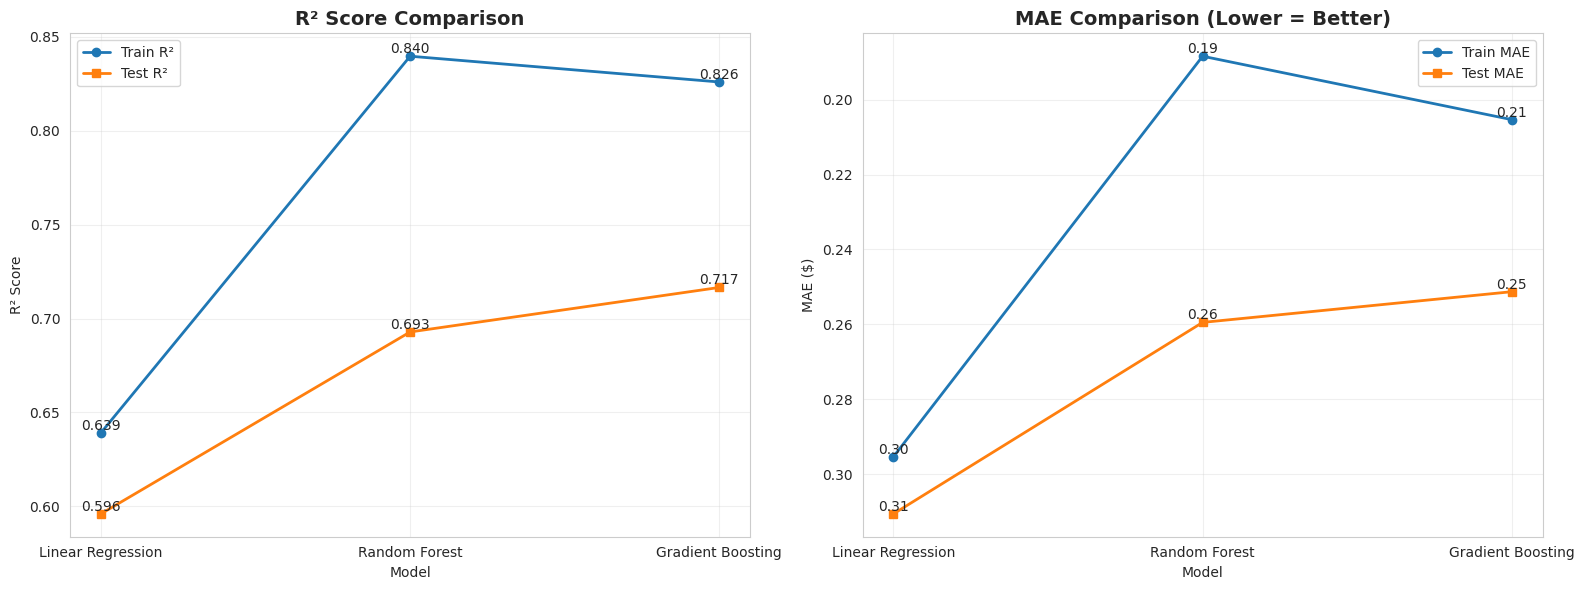

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- R2 Line Plot ----------
axes[0].plot(comparison['Model'], comparison['Train R²'], marker='o', label='Train R²', linewidth=2)
axes[0].plot(comparison['Model'], comparison['Test R²'], marker='s', label='Test R²', linewidth=2)

# Add data labels
for i, v in enumerate(comparison['Train R²']):
    axes[0].text(i, v, f"{v:.3f}", fontsize=10, ha='center', va='bottom')

for i, v in enumerate(comparison['Test R²']):
    axes[0].text(i, v, f"{v:.3f}", fontsize=10, ha='center', va='bottom')

axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend()


# ---------- MAE Line Plot ----------
axes[1].plot(comparison['Model'], comparison['Train MAE'], marker='o', label='Train MAE', linewidth=2)
axes[1].plot(comparison['Model'], comparison['Test MAE'], marker='s', label='Test MAE', linewidth=2)

# Add data labels
for i, v in enumerate(comparison['Train MAE']):
    axes[1].text(i, v, f"{v:.2f}", fontsize=10, ha='center', va='bottom')

for i, v in enumerate(comparison['Test MAE']):
    axes[1].text(i, v, f"{v:.2f}", fontsize=10, ha='center', va='bottom')

axes[1].set_title('MAE Comparison (Lower = Better)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('MAE ($)')
axes[1].invert_yaxis()   # highlights better performance as higher on graph
axes[1].grid(True, alpha=0.3)
axes[1].legend()


plt.tight_layout()
plt.show()


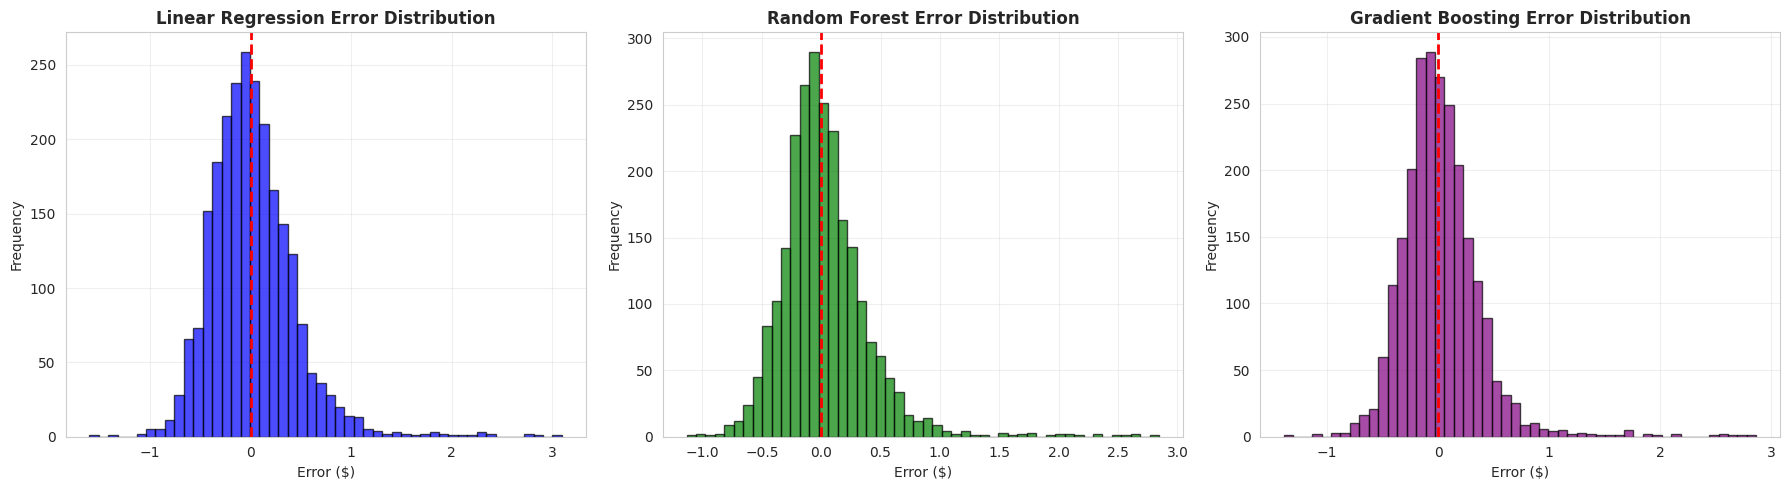

In [86]:
# Error distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(residuals_test, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Error ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Linear Regression Error Distribution', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals_test_rf, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Error ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Random Forest Error Distribution', fontweight='bold')
axes[1].grid(True, alpha=0.3)

residuals_test_gb = y_test_eng - y_test_pred_gb
axes[2].hist(residuals_test_gb, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Error ($)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Gradient Boosting Error Distribution', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **Review Modeling**

# 1. Load data and text preprocessing

1.1 Import libraries and load data

In [87]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [88]:
# import Broward county reviews datasets
reviews_url = 'https://data.insideairbnb.com/united-states/fl/broward-county/2025-06-24/data/reviews.csv.gz'

# Load the datasets into DataFrames
reviews_df = pd.read_csv(reviews_url, compression='gzip')

In [89]:
#check the shape of the dataframe
reviews_df.shape

(647226, 6)

1.2 Text Cleaning Function

- **Clean raw text** by removing URLs, non‑alphabetic characters, and converting everything to lowercase.  
- **Tokenize words** into individual units for easier processing.  
- **Filter out stopwords and punctuation** to keep only meaningful words.  
- **Lemmatize tokens** to reduce words to their base form, ensuring consistency across variations.  


In [90]:
# pre- processing function

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isnull(text):
        return ''
    # Remove URLs, non-letters, and convert to lowercase
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()

    # Tokenize and remove stopwords - word_tokenize() would be more accurate but slow
    tokens = text.split()
    stop_words = set(stopwords.words('english'))

    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]

    return ' '.join(tokens)

1.3 Filter and Preprocess Reviews

- **Convert dates to proper format** to ensure the date column is usable for time‑based analysis.
- Sample **5,000 reviews** from the dataset for efficient processing and reproducibility.
- **Detect and translate languages** : Perform language detection and translation so every comment is standardized into English.
- **Clean and preprocess text** by applying your custom function (removing noise, stopwords, lemmatizing) to prepare reviews for sentiment or topic modeling.


In [91]:
# Ensure the 'date' column is in datetime format
reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')

In [92]:
# Sample 5,000 reviews from reviews_df
filtered_reviews = reviews_df.sample(n=5000, random_state=42)

In [93]:


# Initialize translator
translator = Translator()

def detect_and_translate(text):
    try:
        lang = detect(text)
        if lang != "en":  # If not English, translate to English

            return translator.translate(text, src=lang, dest="en").text
        else:
            return text   # If already English, return as-is

    except:
        return text # In case of error (e.g., empty string), return original text


In [94]:
filtered_reviews["english_comments"] = filtered_reviews["comments"].astype(str).apply(detect_and_translate)

In [95]:
# Clean the translated comments using your custom preprocessing function

filtered_reviews["cleaned_comments"] = filtered_reviews["english_comments"].apply(preprocess_text)

In [96]:
# Display original, translated, and cleaned comments for the first 10 entries

filtered_reviews[["comments", "english_comments", "cleaned_comments"]].head(10)

comments  \
108825                           Great place for a night!   
453910  This airbnb is perfectly/centrally located, be...   
63326   This place was perfect for our family!  We wer...   
421587  Nice house. Not a bad area. Seems to be lackin...   
490146                          Everything was excellent!   
298505  Great place to stay if you want to be close to...   
170530  Great and privat spot for a few nights. Bed wa...   
587894  Excelente lugar con una gran vista! Los mueble...   
209557        Great host, great location, great vacation!   
618667  El apartamento esta muy lindo, en un condomini...   

                                         english_comments  \
108825                           Great place for a night!   
453910  This airbnb is perfectly/centrally located, be...   
63326   This place was perfect for our family!  We wer...   
421587  Nice house. Not a bad area. Seems to be lackin...   
490146                          Everything was excellent!   
298505  Great place to stay if you want to be close to...   
170530  Great and privat spot for a few nights. Bed wa...   
587894  Excellent place with a great view!The furnitur...   
209557        Great host, great location, great vacation!   
618667  The apartment is very nice, in a safe condomin...   

                                         cleaned_comments  
108825                                  great place night  
453910  airbnb perfectlycentrally located beach pier l...  
63326   place perfect family able stay near beach quai...  
421587  nice house bad area seems lacking bit quality ...  
490146                               everything excellent  
298505  great place stay want close wilton manner rest...  
170530            great privat spot night bed really good  
587894  excellent place great viewthe furniture descri...  
209557           great host great location great vacation  
618667  apartment nice safe condominium easy accessthe...

# 2. Text Vectorization: Representing Words as Numeric Features

**Bag‑of‑Words (BoW):**  
- Represents text as word frequency counts and ignoring grammar and word order.  
- Simple and effective, but treats all words equally without considering importance.  

**TF‑IDF (Term Frequency–Inverse Document Frequency):**  
- Weighs words by how often they appear in a document versus across all documents.  
- Highlights distinctive terms, reducing the impact of common words like “the” or “and.”  


In [97]:

# Common parameters for both vectorizers
vectorizer_params = {
    "min_df": 5,               # ignore very rare words
    "max_df": 0.90,            # ignore overly common words
    "stop_words": "english",   # remove English stopwords
    "max_features": 5000,      # cap vocabulary size for efficiency
    "ngram_range": (1, 2)      # include unigrams + bigrams
}

# Bag-of-Words
bow_vectorizer = CountVectorizer(**vectorizer_params)
X_bow = bow_vectorizer.fit_transform(filtered_reviews["cleaned_comments"].astype(str))
bow_feature_names = bow_vectorizer.get_feature_names_out()
print("BoW matrix shape:", X_bow.shape)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(**vectorizer_params)
X_tfidf = tfidf_vectorizer.fit_transform(filtered_reviews["cleaned_comments"].astype(str))
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print("TF-IDF matrix shape:", X_tfidf.shape)

BoW matrix shape: (5000, 3487)
TF-IDF matrix shape: (5000, 3487)


In [98]:

# Function to plot the top words for each topic
def plot_top_words(model, feature_names, n_top_words=10, title='Top Words per Topic'):
    n_topics = model.n_components
    fig, axes = plt.subplots(1, n_topics, figsize=(4 * n_topics, 5), sharex=False)

    # Handle single-topic case
    if n_topics == 1:
        axes = [axes]

    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_features = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color="skyblue", edgecolor="black")
        ax.set_title(f'Topic {topic_idx+1}', fontsize=12, weight="bold")
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)

    plt.suptitle(title, fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Function to generate word clouds for each topic
def plot_word_clouds(model, feature_names, n_top_words=30, max_words=100):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_features = {feature_names[i]: topic[i] for i in top_indices}

        wordcloud = WordCloud(
            width=600, height=300, background_color='white',
            max_words=max_words, max_font_size=50, colormap="viridis"
        ).generate_from_frequencies(top_features)

        plt.figure(figsize=(8, 4))  # smaller figure size
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic_idx+1} Word Cloud', fontsize=14, weight="bold")
        plt.show()

# 3. Topic Modelling:
* It is an unsupervised machine learning technique used to automatically discover hidden themes or “topics” within a large collection of text documents.
 * It groups words that frequently occur together into clusters, helping us understand the main subjects being discussed without manually reading every document.


**Latent Dirichlet Allocation (LDA)**
- Helps uncover hidden thematic structures in reviews, grouping words into interpretable topics.
- In sentiment analysis, it reveals dominant themes driving positive or negative opinions.

**Non-Negative Matrix Factorization (NMF**)
- Decomposes text into additive parts, producing clear, non-overlapping topics.
- Useful in sentiment analysis for highlighting distinct aspects (e.g., cleanliness vs. pricing) that influence sentiment.

**Latent Semantic Analysis (LSA)**
- Captures semantic relationships by reducing dimensionality with SVD.
- In sentiment analysis, it identifies underlying concepts and reduces noise, improving context understanding.


3.1  Latent Dirichlet Allocation (LDA)

In [99]:

# Parameters
n_topics = 10
n_top_words = 10

# Fit the LDA model
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch",   # more stable for large datasets
    max_iter=20                # increase iterations for better convergence
)
lda_model.fit(X_tfidf)

# Extract feature names
terms = tfidf_vectorizer.get_feature_names_out()

# Collect topics
lda_topics = {}
for idx, topic in enumerate(lda_model.components_):
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_words = [terms[i] for i in top_indices]
    lda_topics[f"Topic {idx+1}"] = top_words

# Print the LDA topics
print("LDA Topics (TF-IDF):")
for topic, words in lda_topics.items():
    print(f"{topic}: {', '.join(words)}")

LDA Topics (TF-IDF):
Topic 1: stay, definitely, place, clean, nice, great, host, recommend, definitely stay, location
Topic 2: great, stay, great place, place, great stay, place stay, excellent, host, recommend, place great
Topic 3: perfect, wilton, manor, beautiful, wilton manor, spot, beautiful place, quick, place, located
Topic 4: nice, location, great, time, great location, excellent, clean, thanks, great time, place
Topic 5: loved, place, close, nice, place close, clean, loved place, nice clean, house, great
Topic 6: great, great location, good, location, muy, awesome, recommended, amazing, home, highly
Topic 7: like, good, really, fee, longer, bag, sheet, concern, host, good experience
Topic 8: beach, great, view, location, restaurant, stay, place, beautiful, enjoyed, easy
Topic 9: recommend, highly, cozy, highly recommend, cozy place, beautiful, clean, et, nice cozy, amazing
Topic 10: beach, pool, house, great, place, home, stay, clean, room, bed


# **TOPIC LABELLING**
Topic labelling is used to provide meaningful labels to the topics.

The labels used for LDA are :

* Smooth Check-in & Host Experience
* Comfortable & Beautiful Homes
* Highly Rated Cozy Stays
* Cleanliness & Visual Appeal
* Scenic & Pleasant Locations
* Romantic Getaways & Quick Responses
* Beach Access & Quiet Retreats
* Highly Recommended Hosts & Stays
* Functional Amenities & Clean Rooms
* Prime Location & Clean Apartments

In [100]:
# Topic Labeling for LDA Model
lda_topic_labels = {
    "Topic 1": "Smooth Check-in & Host Experience",
    "Topic 2": "Comfortable & Beautiful Homes",
    "Topic 3": "Highly Rated Cozy Stays",
    "Topic 4": "Cleanliness & Visual Appeal",
    "Topic 5": "Scenic & Pleasant Locations",
    "Topic 6": "Romantic Getaways & Quick Responses",
    "Topic 7": "Beach Access & Quiet Retreats",
    "Topic 8": "Highly Recommended Hosts & Stays",
    "Topic 9": "Functional Amenities & Clean Rooms",
    "Topic 10": "Prime Location & Clean Apartments"
}
import pandas as pd
# Combine topic numbers, labels, and top words into a DataFrame
lda_labels_df = pd.DataFrame({
    "Topic Number": list(lda_topic_labels.keys()),
    "Label": list(lda_topic_labels.values()),
    "Top Words": list(lda_topics.values())
})
lda_labels_df

Topic Number                                Label  \
0      Topic 1    Smooth Check-in & Host Experience   
1      Topic 2        Comfortable & Beautiful Homes   
2      Topic 3              Highly Rated Cozy Stays   
3      Topic 4          Cleanliness & Visual Appeal   
4      Topic 5          Scenic & Pleasant Locations   
5      Topic 6  Romantic Getaways & Quick Responses   
6      Topic 7        Beach Access & Quiet Retreats   
7      Topic 8     Highly Recommended Hosts & Stays   
8      Topic 9   Functional Amenities & Clean Rooms   
9     Topic 10    Prime Location & Clean Apartments   

                                           Top Words  
0  [stay, definitely, place, clean, nice, great, ...  
1  [great, stay, great place, place, great stay, ...  
2  [perfect, wilton, manor, beautiful, wilton man...  
3  [nice, location, great, time, great location, ...  
4  [loved, place, close, nice, place close, clean...  
5  [great, great location, good, location, muy, a...  
6  [like, good, really, fee, longer, bag, sheet, ...  
7  [beach, great, view, location, restaurant, sta...  
8  [recommend, highly, cozy, highly recommend, co...  
9  [beach, pool, house, great, place, home, stay,...

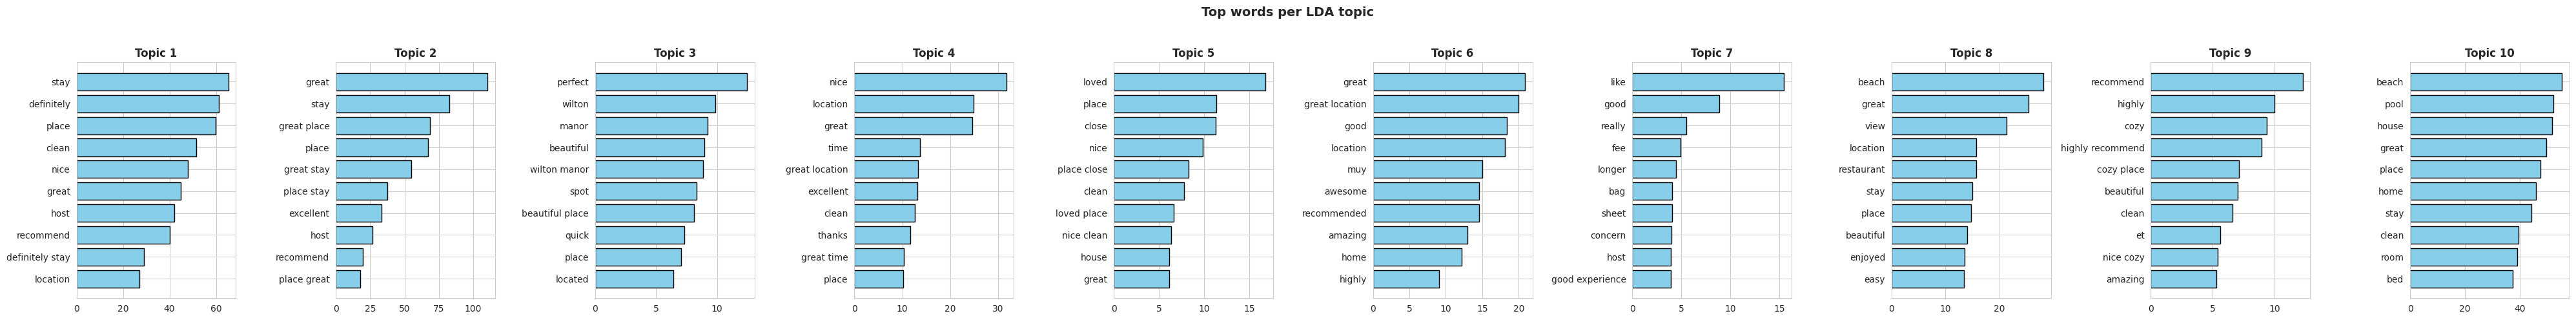

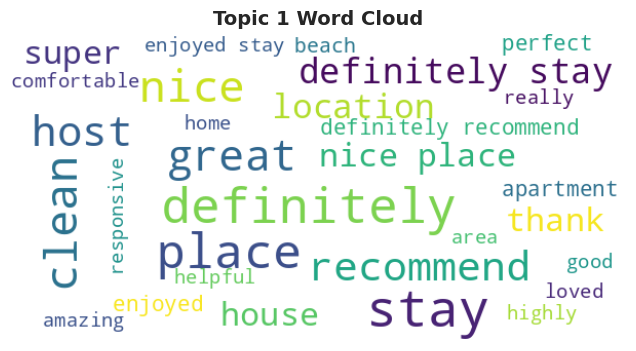

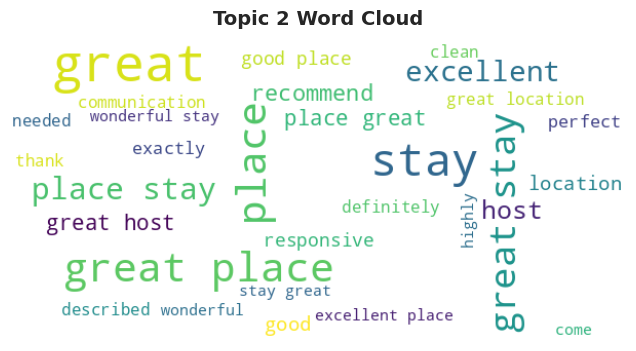

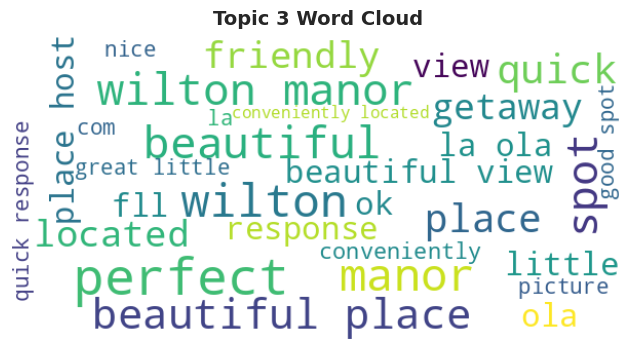

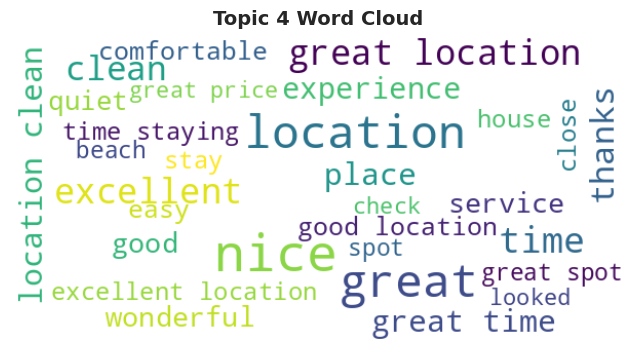

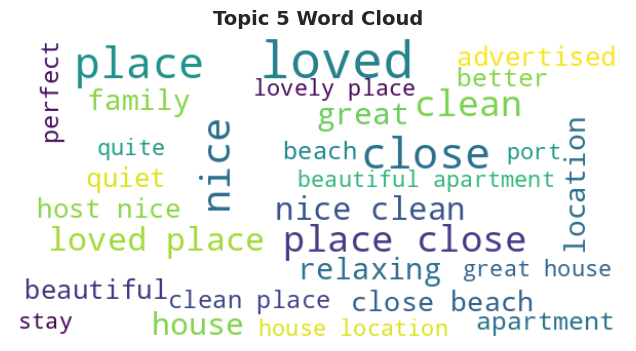

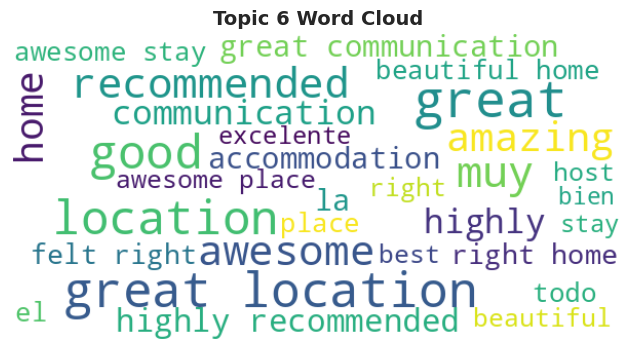

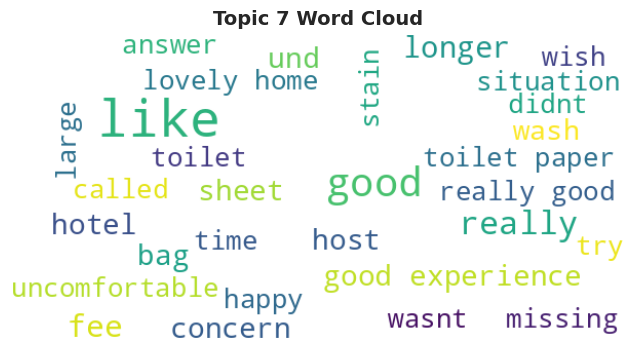

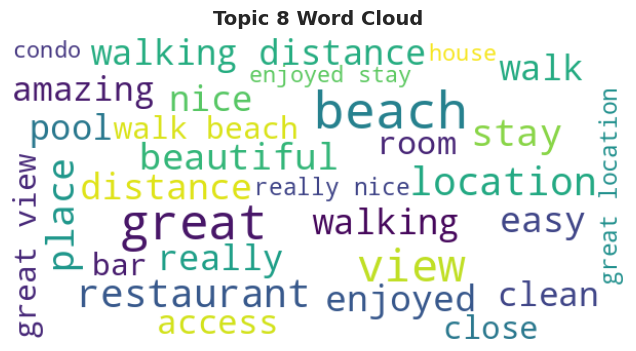

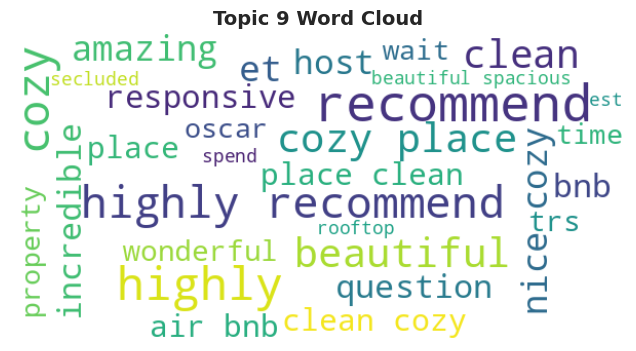

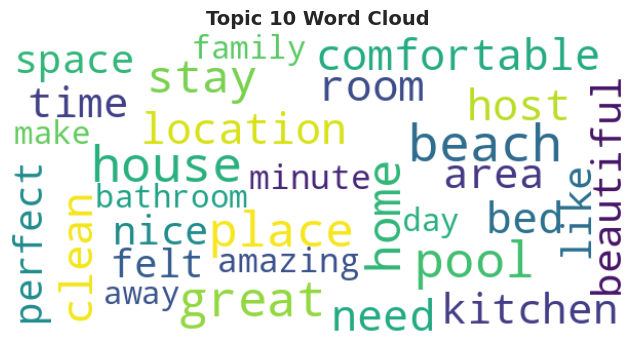

In [101]:
#Topic plots for LDA

plot_top_words(lda_model, terms, n_top_words=10, title='Top words per LDA topic')
plot_word_clouds(lda_model, terms)

# **3.2  Non-negative Matrix Factorization (NMF)**

In [102]:

# Parameters
n_topics = 10
n_top_words = 10

# Fit the NMF model (TF-IDF is usually best for NMF)
nmf_model = NMF(
    n_components=n_topics,
    random_state=42,
    max_iter=200,       # allow more iterations for convergence
    init="nndsvd"       # good initialization for sparse data
)
nmf_model.fit(X_tfidf)

# Extract feature names
terms = tfidf_vectorizer.get_feature_names_out()

# Collect topics
nmf_topics = {}
for idx, topic in enumerate(nmf_model.components_):
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_words = [terms[i] for i in top_indices]
    nmf_topics[f"Topic {idx+1}"] = top_words

# Print the NMF topics
print("NMF Topics (TF-IDF):")
for topic, words in nmf_topics.items():
    print(f"{topic}: {', '.join(words)}")

NMF Topics (TF-IDF):
Topic 1: great, place great, great host, communication, great time, great communication, location great, time, great view, great spot
Topic 2: beach, clean, house, perfect, home, pool, beautiful, comfortable, loved, close
Topic 3: great place, place, place stay, stay, place great, nice place, place clean, great, good place, beautiful place
Topic 4: great stay, stay, definitely stay, place stay, definitely, enjoyed stay, enjoyed, great, stay definitely, thanks
Topic 5: nice, nice place, place, nice clean, really nice, really, clean, nice location, place nice, clean nice
Topic 6: good, good place, good location, good stay, apartment, place good, location good, good spot, spot, clean good
Topic 7: host, great host, amazing, responsive, helpful, host responsive, friendly, responsive host, definitely, amazing host
Topic 8: location, great location, location great, location clean, location close, perfect location, beach, place great, good location, clean
Topic 9: excelle

**TOPIC LABELLING**

The labels used for NMF are :

* Exceptional Hosts & Communication
* Beautiful & Comfortable Homes
* Highly Rated Places to Stay
* Positive Stay Experiences
* Clean & Nice Locations
* Good Value & Location
* Strong Recommendations
* Prime Location & Cleanliness
* Excellent Service & Hosts
* Beach Access & Nearby Attractions

In [103]:
# Topic Labeling for NMF Model

nmf_topic_labels = {
    "Topic 1": "Exceptional Hosts & Communication",
    "Topic 2": "Beautiful & Comfortable Homes",
    "Topic 3": "Highly Rated Places to Stay",
    "Topic 4": "Positive Stay Experiences",
    "Topic 5": "Clean & Nice Locations",
    "Topic 6": "Good Value & Location",
    "Topic 7": "Strong Recommendations",
    "Topic 8": "Prime Location & Cleanliness",
    "Topic 9": "Excellent Service & Hosts",
    "Topic 10": "Beach Access & Nearby Attractions"
}
import pandas as pd
# Combine topic numbers, labels, and top words into a DataFrame
nmf_labels_df = pd.DataFrame({
    "Topic Number": list(nmf_topic_labels.keys()),
    "Label": list(nmf_topic_labels.values()),
    "Top Words": list(nmf_topics.values())
})
nmf_labels_df

Topic Number                              Label  \
0      Topic 1  Exceptional Hosts & Communication   
1      Topic 2      Beautiful & Comfortable Homes   
2      Topic 3        Highly Rated Places to Stay   
3      Topic 4          Positive Stay Experiences   
4      Topic 5             Clean & Nice Locations   
5      Topic 6              Good Value & Location   
6      Topic 7             Strong Recommendations   
7      Topic 8       Prime Location & Cleanliness   
8      Topic 9          Excellent Service & Hosts   
9     Topic 10  Beach Access & Nearby Attractions   

                                           Top Words  
0  [great, place great, great host, communication...  
1  [beach, clean, house, perfect, home, pool, bea...  
2  [great place, place, place stay, stay, place g...  
3  [great stay, stay, definitely stay, place stay...  
4  [nice, nice place, place, nice clean, really n...  
5  [good, good place, good location, good stay, a...  
6  [host, great host, amazing, responsive, helpfu...  
7  [location, great location, location great, loc...  
8  [excellent, excellent location, excellent plac...  
9  [recommend, highly, highly recommend, definite...

In [104]:

# Define custom colormap
colors = ["red", "orange", "pink", "darkorange", "brown", "maroon", "crimson"]# Changed colors from previous LDA word cloud colors
custom_cmap = LinearSegmentedColormap.from_list("custom_nmf", colors)

def plot_nmf_word_clouds(model, feature_names, n_top_words=30, max_words=100):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_features = {feature_names[i]: topic[i] for i in top_indices}

        wordcloud = WordCloud(
            width=600, height=300, background_color="white",
            max_words=max_words, max_font_size=50, colormap=custom_cmap
        ).generate_from_frequencies(top_features)

        plt.figure(figsize=(8,4))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Topic {topic_idx+1} Word Cloud", fontsize=16, weight="bold")
        plt.show()



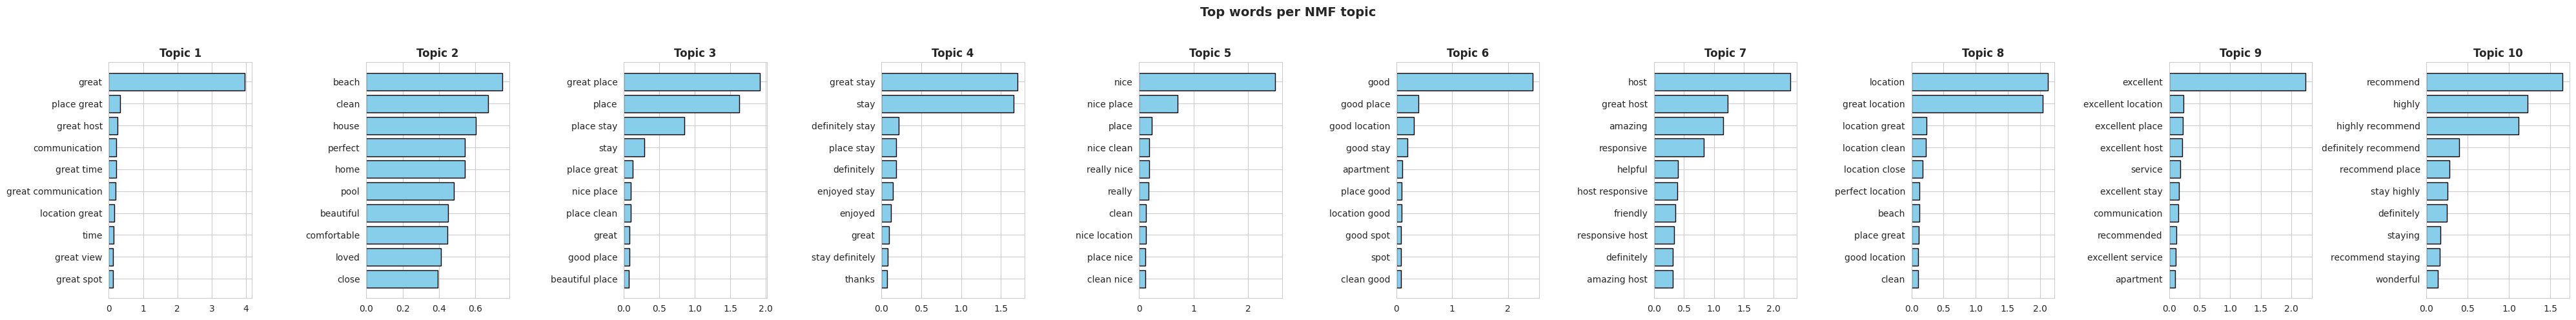

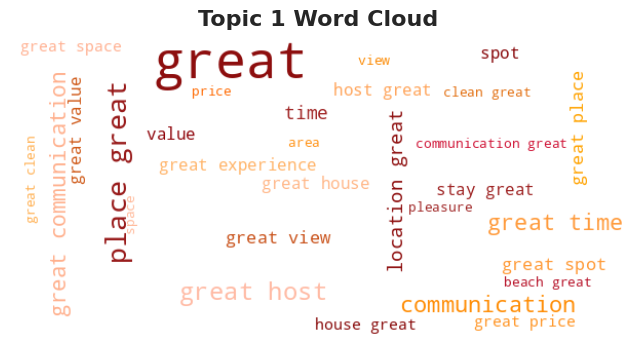

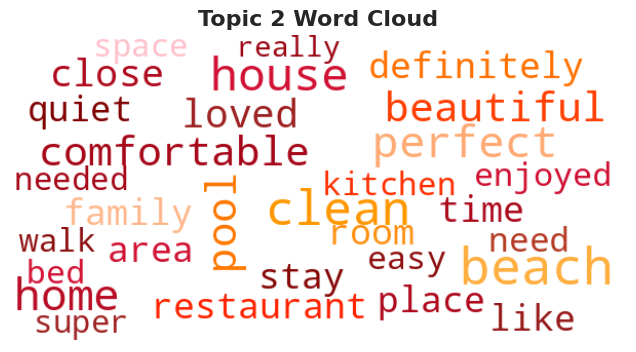

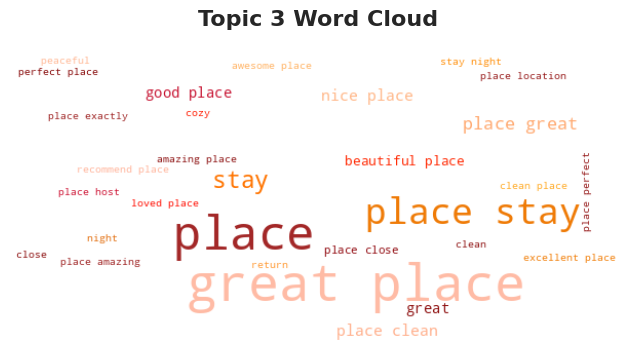

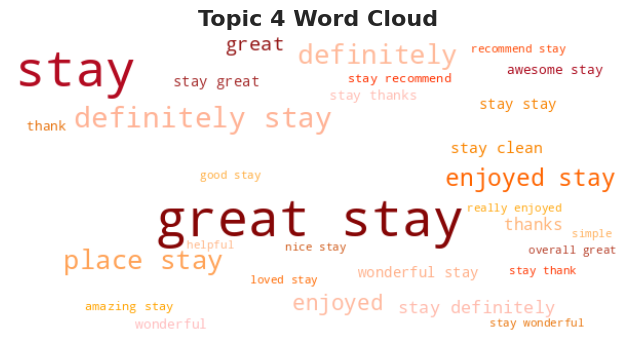

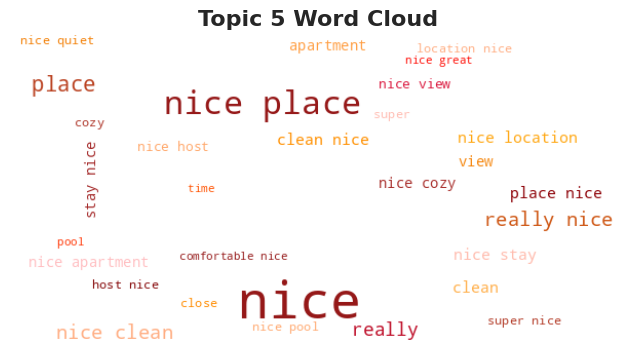

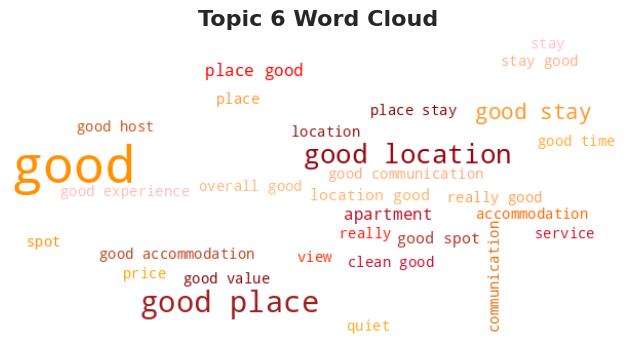

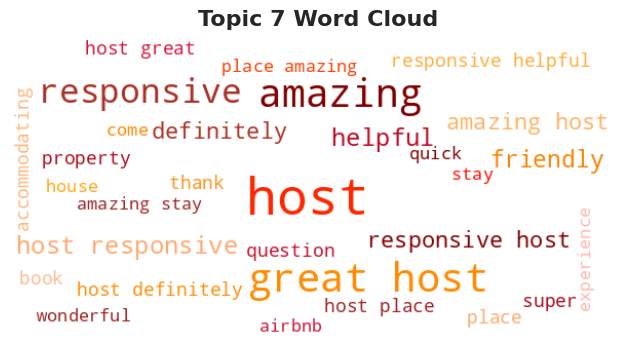

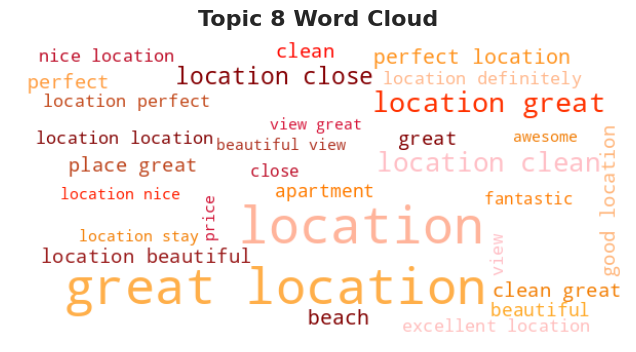

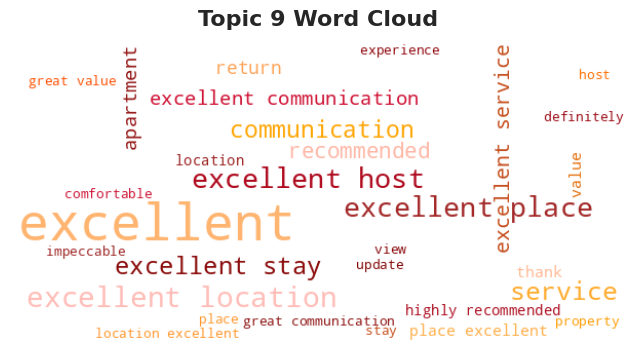

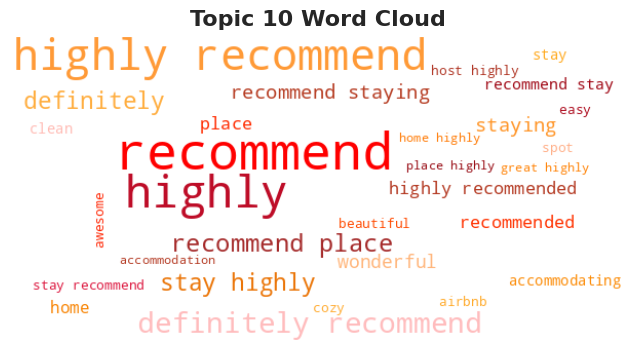

In [105]:
#Topic plots for NMF

plot_top_words(nmf_model, terms, n_top_words=10, title='Top words per NMF topic')
plot_nmf_word_clouds(nmf_model, terms)

# **3) Latent Semantic Analysis (LSA)**

In [106]:

# Parameters
n_topics = 10
n_top_words = 10

# Fit the LSA model (TF-IDF is usually best for LSA)
lsa_model = TruncatedSVD(
    n_components=n_topics,
    random_state=42
)
lsa_model.fit(X_tfidf)

# Extract feature names
terms = tfidf_vectorizer.get_feature_names_out()

# Collect topics
lsa_topics = {}
for idx, topic in enumerate(lsa_model.components_):
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_words = [terms[i] for i in top_indices]
    lsa_topics[f"Topic {idx+1}"] = top_words

# Print the LSA topics
print("LSA Topics (TF-IDF):")
for topic, words in lsa_topics.items():
    print(f"{topic}: {', '.join(words)}")

LSA Topics (TF-IDF):
Topic 1: great, place, stay, great place, location, host, great stay, clean, nice, beach
Topic 2: great, great place, great stay, place, place stay, great location, place great, great host, location great, stay great
Topic 3: place, great place, nice, place stay, nice place, good, good place, place clean, place great, place close
Topic 4: stay, great stay, place stay, definitely stay, definitely, place, enjoyed stay, enjoyed, nice, recommend
Topic 5: nice, nice place, great stay, great location, great, location, nice clean, really nice, really, nice location
Topic 6: good, good place, location, good location, place stay, stay, great location, good stay, beach, apartment
Topic 7: recommend, host, good, excellent, highly, highly recommend, great host, definitely recommend, nice, great
Topic 8: location, excellent, great location, stay, recommend, place stay, highly, highly recommend, definitely, place
Topic 9: excellent, beach, host, excellent location, close, excell

**TOPIC LABELLING:**

The labels used for LSA are :

* Great Hosts & Memorable Stays
* Highly Rated Locations & Hosts
* Nice & Quiet Places to Stay
* Enjoyable & Recommended Stays
* Nice Homes & Pleasant Locations
* Good Value Apartments & Locations
* Excellent Hosts & Strong Recommendations
* Prime Location & Beach Access
* Excellent Service & Beachside Hosts
* Beachside Dining & Relaxation

In [107]:
# Topic Labeling for LSA Model
lsa_topic_labels = {
    "Topic 1": "Great Hosts & Memorable Stays",
    "Topic 2": "Highly Rated Locations & Hosts",
    "Topic 3": "Nice & Quiet Places to Stay",
    "Topic 4": "Enjoyable & Recommended Stays",
    "Topic 5": "Nice Homes & Pleasant Locations",
    "Topic 6": "Good Value Apartments & Locations",
    "Topic 7": "Excellent Hosts & Strong Recommendations",
    "Topic 8": "Prime Location & Beach Access",
    "Topic 9": "Excellent Service & Beachside Hosts",
    "Topic 10": "Beachside Dining & Relaxation"
}

import pandas as pd
# Combine topic numbers, labels, and top words into a DataFrame
lsa_labels_df = pd.DataFrame({
    "Topic Number": list(lsa_topic_labels.keys()),
    "Label": list(lsa_topic_labels.values()),
    "Top Words": list(lsa_topics.values())
})
lsa_labels_df

Topic Number                                     Label  \
0      Topic 1             Great Hosts & Memorable Stays   
1      Topic 2            Highly Rated Locations & Hosts   
2      Topic 3               Nice & Quiet Places to Stay   
3      Topic 4             Enjoyable & Recommended Stays   
4      Topic 5           Nice Homes & Pleasant Locations   
5      Topic 6         Good Value Apartments & Locations   
6      Topic 7  Excellent Hosts & Strong Recommendations   
7      Topic 8             Prime Location & Beach Access   
8      Topic 9       Excellent Service & Beachside Hosts   
9     Topic 10             Beachside Dining & Relaxation   

                                           Top Words  
0  [great, place, stay, great place, location, ho...  
1  [great, great place, great stay, place, place ...  
2  [place, great place, nice, place stay, nice pl...  
3  [stay, great stay, place stay, definitely stay...  
4  [nice, nice place, great stay, great location,...  
5  [good, good place, location, good location, pl...  
6  [recommend, host, good, excellent, highly, hig...  
7  [location, excellent, great location, stay, re...  
8  [excellent, beach, host, excellent location, c...  
9  [beach, highly, recommend, highly recommend, g...

For Custom Color

In [108]:

# Define custom colormap for LSA (purple/pink with a couple of bright accents)
lsa_colors = ["black", "red", "blue", "yellow", "brown", "grey", "firebrick"]

custom_cmap_lsa = LinearSegmentedColormap.from_list("custom_lsa", lsa_colors)

def plot_lsa_word_clouds(model, feature_names, n_top_words=30, max_words=100):

    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_features = {feature_names[i]: topic[i] for i in top_indices}

        wordcloud = WordCloud(
            width=600, height=300, background_color="white",
            max_words=max_words, max_font_size=50, colormap=custom_cmap_lsa
        ).generate_from_frequencies(top_features)

        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"LSA Topic {topic_idx+1} Word Cloud", fontsize=16, weight="bold")
        plt.show()

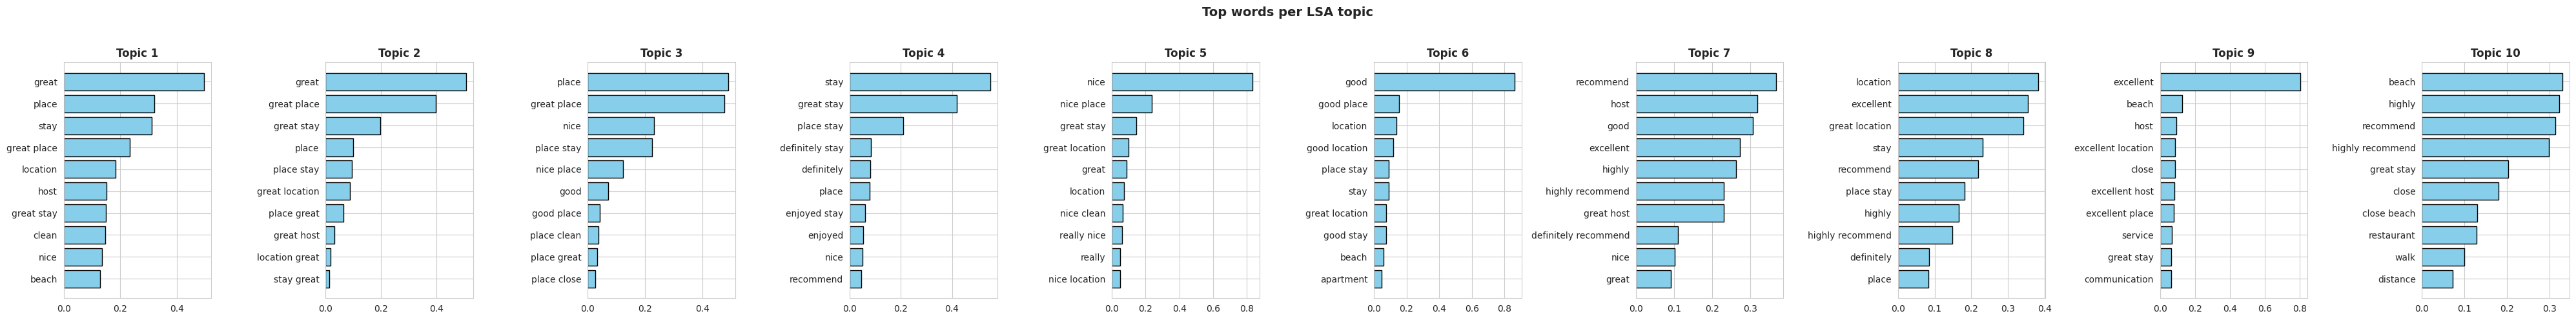

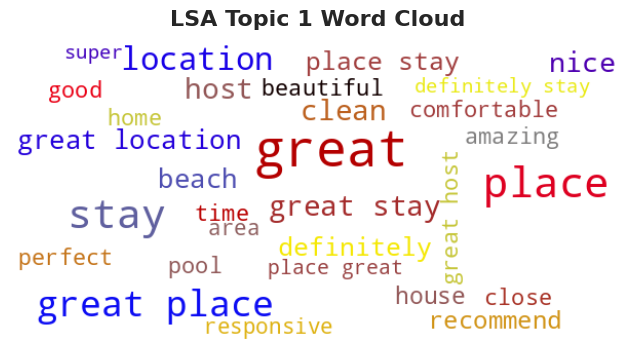

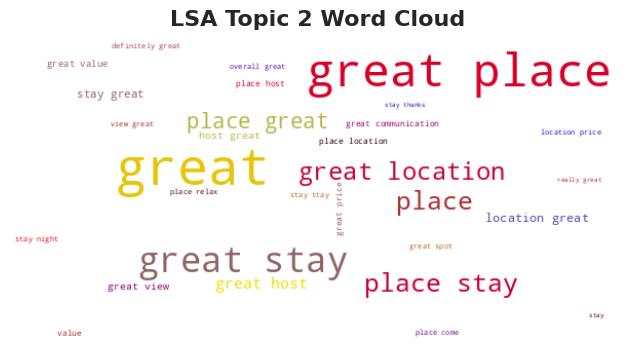

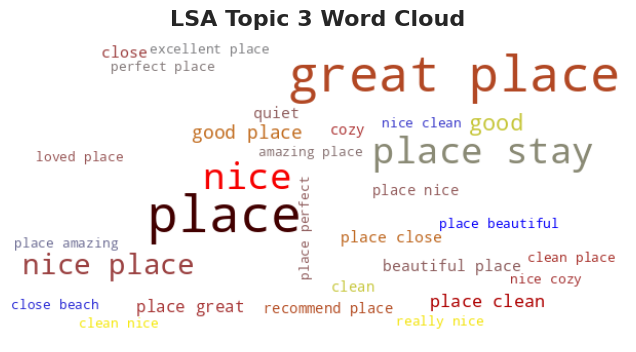

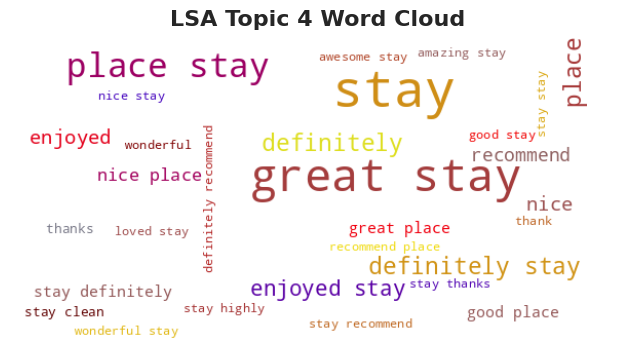

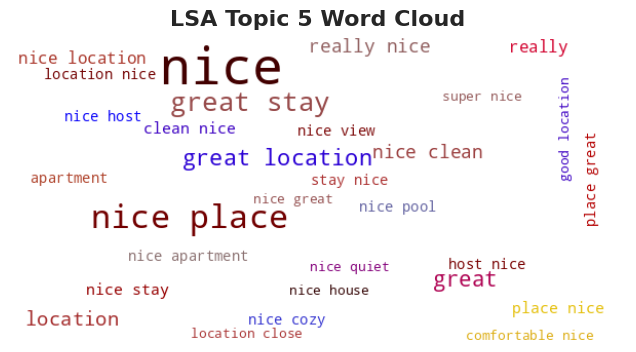

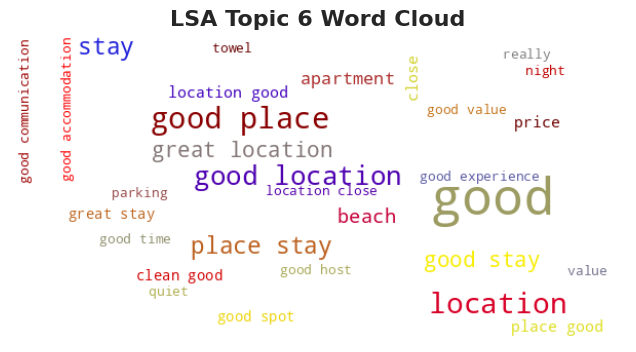

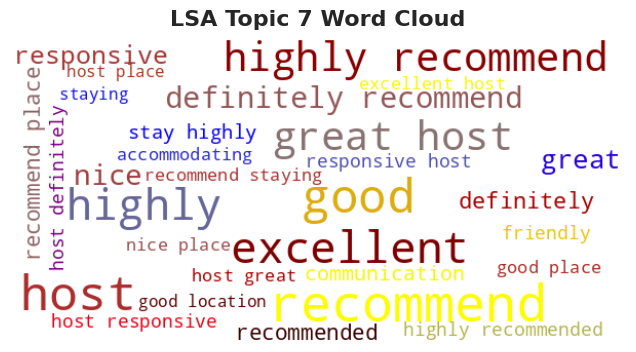

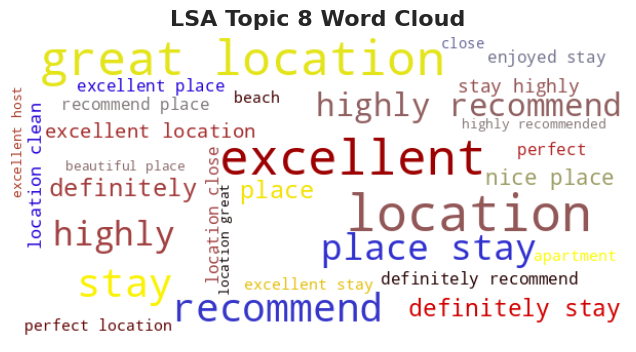

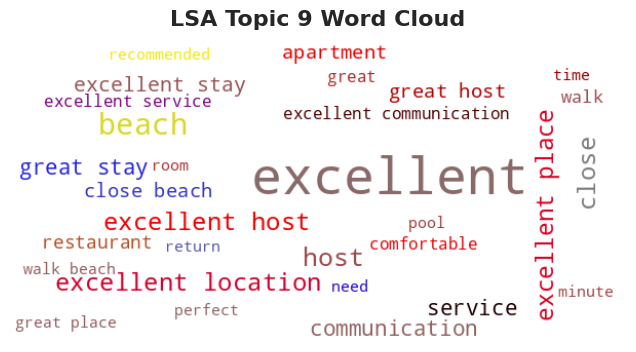

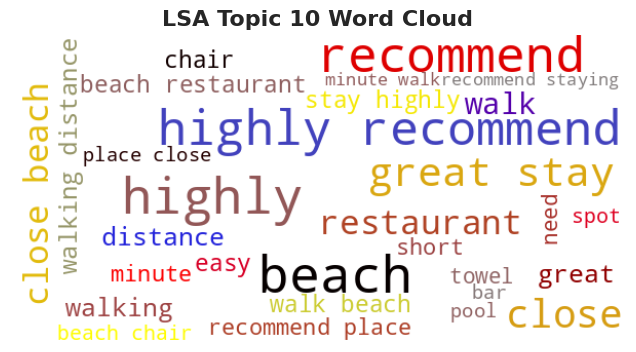

In [109]:
#Topic plots for LSA

plot_top_words(lsa_model, terms, n_top_words=10, title='Top words per LSA topic')
plot_lsa_word_clouds(lsa_model, terms)

# TOPIC DISTANCE

In [110]:
#Let's check the topic distance


# Function to plot topic distances using PCA
def plot_topic_distance_pca(model, title='Topic Distance (PCA)'):
    # Get the topic-word matrix (components_) from the model
    topic_word_matrix = model.components_

    # Apply PCA to reduce the topic-word matrix to 2 dimensions
    pca = PCA(n_components=2)
    topic_pca = pca.fit_transform(topic_word_matrix)

    # Plot the topics in 2D space
    plt.figure(figsize=(8, 6))
    plt.scatter(topic_pca[:, 0], topic_pca[:, 1], c='blue', edgecolor='k', s=100)

    # Annotate the topics with text labels
    for i in range(len(topic_pca)):
        plt.text(topic_pca[i, 0], topic_pca[i, 1], f'Topic {i+1}', fontsize=12)

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

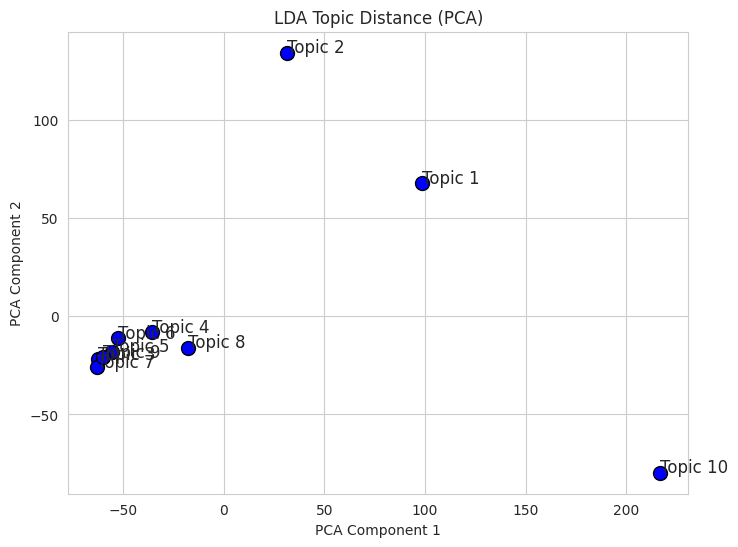

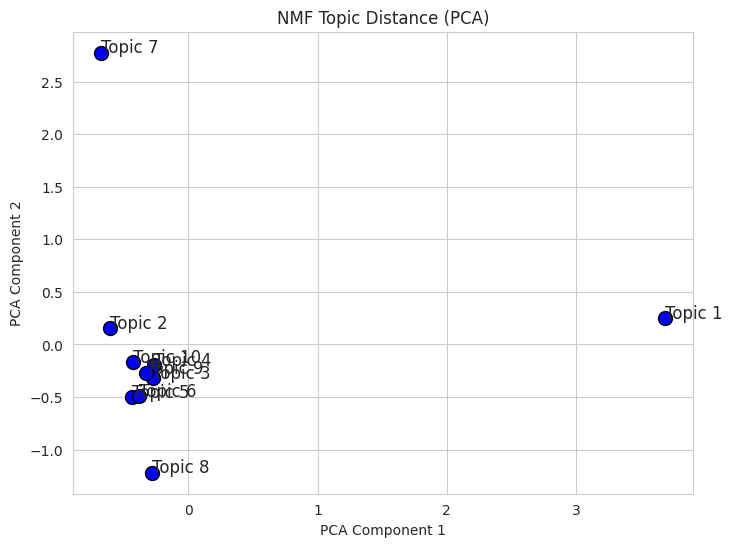

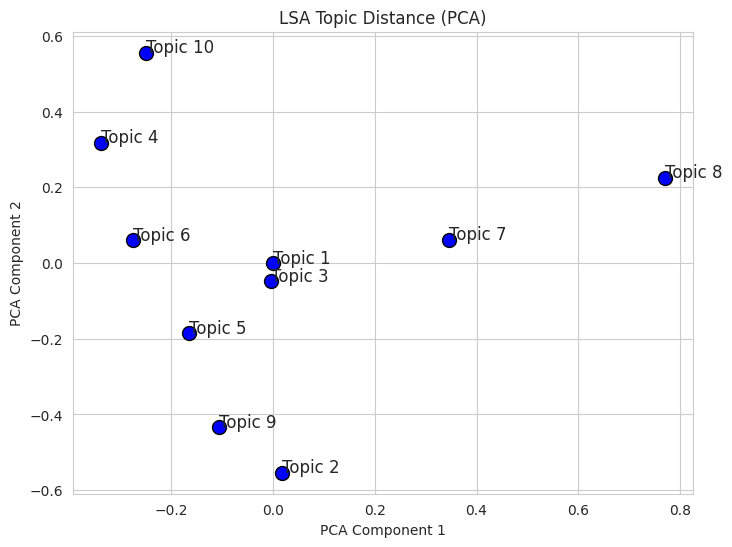

In [111]:
# compare topic distance of all models

# LDA
plot_topic_distance_pca(lda_model, title='LDA Topic Distance (PCA)')
# NMF
plot_topic_distance_pca(nmf_model, title='NMF Topic Distance (PCA)')
# LSA
plot_topic_distance_pca(lsa_model, title='LSA Topic Distance (PCA)')

Here are some insights based on teh topic distance plots:

•	**LDA** shows the strongest topic separation, producing highly distinct and well-differentiated topics across the PCA space.

•	**NMF** produces moderately separated topics, with a couple of clearly distinct themes like Topic 1, Topic 2 and Topic 7  while the rest form a compact but interpretable cluster.

•	**LSA** topics cluster tightly, indicating strong similarity and less thematic distinction. Only topic 1 , topic 9 and topic 4 are meaningfully separated.


# 4) **Sentiment Analysis with VADER (Valence Aware Dictionary and sEntiment Reasoner)**  

It is a sentiment analysis tool that uses a lexicon and a set of rules to analyze the emotional tone of text

It provides four key scores:

* Positive
* Neutral
* Negative
* Compound (an overall sentiment score ranging from -1 to +1)

In [112]:

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Define function to extract sentiment scores
def get_vader_scores(text):
    if pd.isna(text) or not str(text).strip():
        return pd.Series([None, None, None, None])  # handle empty/missing text
    scores = analyzer.polarity_scores(str(text))
    return pd.Series([
        round(scores['compound'], 4),
        round(scores['pos'], 4),
        round(scores['neu'], 4),
        round(scores['neg'], 4)
    ])

# Apply VADER to review comments
filtered_reviews[['compound', 'positive', 'neutral', 'negative']] = (
    filtered_reviews['comments'].apply(get_vader_scores)
)

# Categorize sentiment
def categorize_sentiment(score):
    if pd.isna(score):
        return 'UNKNOWN'
    elif score >= 0.05:
        return 'POSITIVE'
    elif score <= -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

filtered_reviews['sentiment'] = filtered_reviews['compound'].apply(categorize_sentiment)

# Optional: reorder columns for clarity
cols_to_show = [
    'comments', 'compound', 'positive', 'neutral', 'negative', 'sentiment'
]
filtered_reviews[cols_to_show].head()

comments  compound  positive  \
108825                           Great place for a night!    0.6588     0.523   
453910  This airbnb is perfectly/centrally located, be...    0.6808     0.237   
63326   This place was perfect for our family!  We wer...    0.9926     0.445   
421587  Nice house. Not a bad area. Seems to be lackin...    0.8820     0.360   
490146                          Everything was excellent!    0.6114     0.666   

        neutral  negative sentiment  
108825    0.477       0.0  POSITIVE  
453910    0.763       0.0  POSITIVE  
63326     0.555       0.0  POSITIVE  
421587    0.640       0.0  POSITIVE  
490146    0.334       0.0  POSITIVE

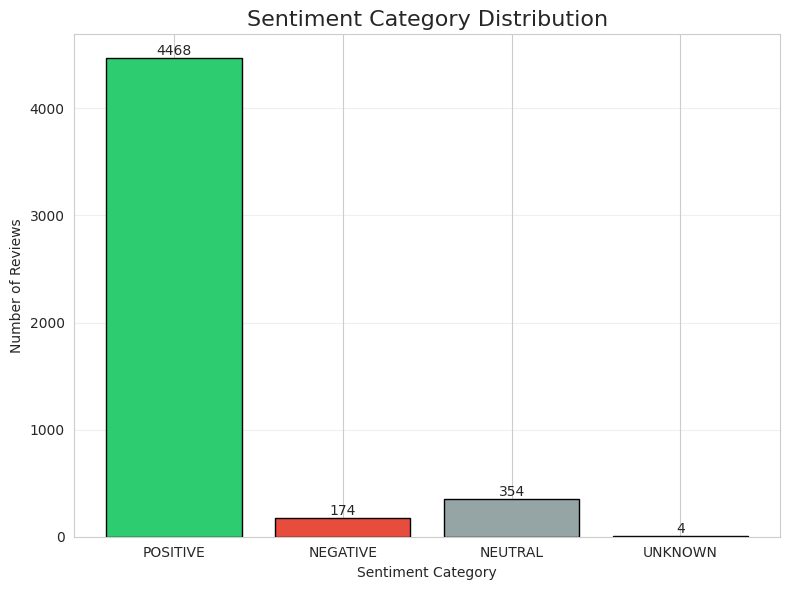

In [113]:

# Count sentiment categories in your DataFrame
sentiment_counts = filtered_reviews['sentiment'].value_counts().reindex(
    ['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'UNKNOWN'], fill_value=0
)

# Define distinct colors for each category
colors = {
    'POSITIVE': '#2ECC71',  # green
    'NEGATIVE': '#E74C3C',  # red
    'NEUTRAL':  '#95A5A6',  # gray
    'UNKNOWN':  '#CCCCCC'   # light gray
}
sentiment_colors = [colors[label] for label in sentiment_counts.index]

# Plot bar chart
plt.figure(figsize=(8,6))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=sentiment_colors, edgecolor='black')

# Add counts on top of each bar
for bar, count in zip(bars, sentiment_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontsize=10)

plt.title("Sentiment Category Distribution", fontsize=16)
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Here are some insights based on the Sentiment Category Distribution chart:
- **Positive reviews**: Out of 5,000 sampled Airbnb reviews,     4,468 (≈89%) are labeled as POSITIVE, indicating strong guest satisfaction.
- **Neutral sentiment**: Only 354 reviews (≈7%) are marked as NEUTRAL, suggesting VADER tends to favor polarized sentiment or that guests rarely leave neutral/mixed feedback.
- **Negative reviews**: Just 174 reviews (≈3.5%) are classified as NEGATIVE, which may reflect either genuinely good experiences or polite phrasing that VADER doesn’t flag as harsh.
- **Minimal data issues**: Only 4 reviews fall under UNKNOWN, showing that the dataset is clean and well-processed with very few unusable entries.

# 5) Sentiment Analysis using Hugging Face Transformers

Hugging Face Transformers is an open-source Python library that provides thousands of pre-trained machine learning models for natural language processing, computer vision, and audio tasks.

It:
- Uses pre‑trained transformer models for accurate sentiment classification.  
- Captures context better than simple lexicon methods.  
- Handles multiple languages with translation support.  
- Outputs confidence scores for positive, negative, or neutral sentiment.  


In [114]:

# Initialize the default sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [115]:

# Initialize pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Filter valid comments
valid_reviews = filtered_reviews[filtered_reviews['comments'].notna()]
valid_reviews = valid_reviews[valid_reviews['comments'].str.strip() != '']
texts = valid_reviews['comments'].astype(str).tolist()

# Chunked sentiment analysis
def chunked_sentiment_analysis(texts, batch_size=32):
    results = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Analyzing sentiment"):
        batch = texts[i:i+batch_size]
        batch_results = sentiment_analyzer(batch, truncation=True)
        results.extend(batch_results)
    return results

hf_results = chunked_sentiment_analysis(texts, batch_size=32)

# Convert to DataFrame and align with original indices
hf_sentiment_df = pd.DataFrame(hf_results)
hf_sentiment_df.index = valid_reviews.index  # align indices
filtered_reviews[['hf_label', 'hf_score']] = hf_sentiment_df
filtered_reviews.head()

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
Analyzing sentiment: 100%|██████████| 157/157 [00:34<00:00,  4.54it/s]


listing_id                  id       date  reviewer_id  \
108825            28229334           425935222 2019-03-19    176096831   
453910  675950125733876702  755875471509539912 2022-11-08    277894337   
63326              9297229           224594083 2018-01-03     44292701   
421587            54405781  728255954391738527 2022-10-01    369573743   
490146  770870053021893477  916016482437313379 2023-06-17    237203194   

       reviewer_name                                           comments  \
108825        Kaylen                           Great place for a night!   
453910      Stardust  This airbnb is perfectly/centrally located, be...   
63326      Christine  This place was perfect for our family!  We wer...   
421587        Ashley  Nice house. Not a bad area. Seems to be lackin...   
490146      Meredith                          Everything was excellent!   

                                         english_comments  \
108825                           Great place for a night!   
453910  This airbnb is perfectly/centrally located, be...   
63326   This place was perfect for our family!  We wer...   
421587  Nice house. Not a bad area. Seems to be lackin...   
490146                          Everything was excellent!   

                                         cleaned_comments  compound  positive  \
108825                                  great place night    0.6588     0.523   
453910  airbnb perfectlycentrally located beach pier l...    0.6808     0.237   
63326   place perfect family able stay near beach quai...    0.9926     0.445   
421587  nice house bad area seems lacking bit quality ...    0.8820     0.360   
490146                               everything excellent    0.6114     0.666   

        neutral  negative sentiment  hf_label  hf_score  
108825    0.477       0.0  POSITIVE  POSITIVE  0.999876  
453910    0.763       0.0  POSITIVE  POSITIVE  0.999529  
63326     0.555       0.0  POSITIVE  POSITIVE  0.999870  
421587    0.640       0.0  POSITIVE  NEGATIVE  0.998459  
490146    0.334       0.0  POSITIVE  POSITIVE  0.999872

In [116]:
#normalize labels

def normalize_label(label):
    if pd.isna(label):
        return 'UNKNOWN'
    label = str(label).upper()
    if label == 'POSITIVE':
        return 'POSITIVE'
    elif label == 'NEGATIVE':
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

filtered_reviews['hf_sentiment'] = filtered_reviews['hf_label'].apply(normalize_label)

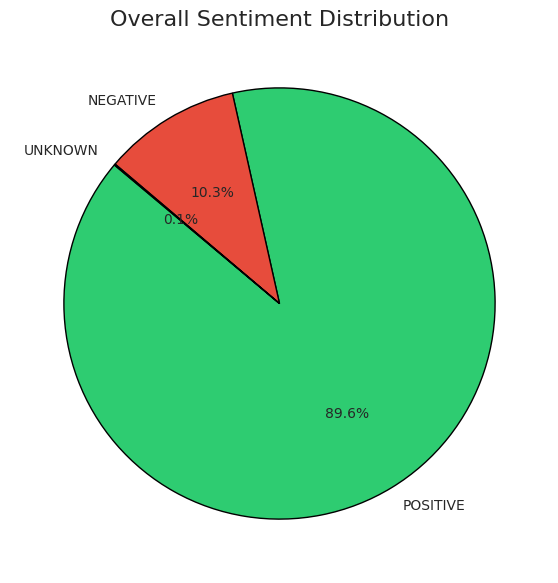

In [117]:

# Count the normalized sentiment labels
sentiment_counts = filtered_reviews['hf_sentiment'].value_counts()

# Define colors for each sentiment
colors = {
    'POSITIVE': '#2ECC71',  # green
    'NEGATIVE': '#E74C3C',  # red
    'NEUTRAL':  '#95A5A6',  # gray
    'UNKNOWN':  '#CCCCCC'   # light gray
}

# Match colors to sentiment order
sentiment_colors = [colors[label] for label in sentiment_counts.index]

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sentiment_colors,
    wedgeprops={'edgecolor':'black'}
)
plt.title("Overall Sentiment Distribution", fontsize=16)
plt.show()

# Here are some insights based on the Hugging Face Transformers sentiment analysis pie chart:

- **Positive reviews**: 89.6% show strong satisfaction across the dataset which means majority of the reviews are positive.  
- **Negative sentiment is higher than VADER’s output**: 10.3%, which suggests that Hugging Face is more sensitive to critical tone.  
- **No neutral category detected**: The model forces polarity, unlike VADER which allows neutrality.  
- **Minimal unknowns**: Only 0.1%, indicating robust language handling and clean preprocessing.  



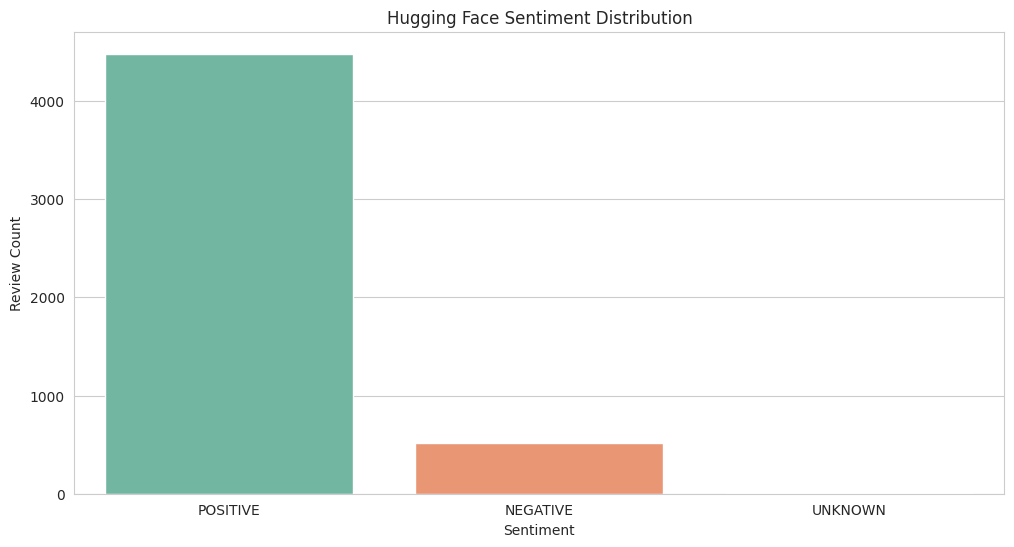

In [118]:
# Plot a bar chart of Hugging Face sentiment predictions (positive, negative, unknown) with labels and title


sns.countplot(data=filtered_reviews, x='hf_sentiment', palette='Set2')
plt.title("Hugging Face Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Review Count")
plt.show()

# 6) Sentiment Comparison: VADER vs Hugging Face

In [119]:
# Add a column 'sentiment_agreement' showing True if VADER and Hugging Face predictions match, else False

filtered_reviews['sentiment_agreement'] = (
    filtered_reviews['sentiment'] == filtered_reviews['hf_sentiment']
)

In [120]:
# Calculate and print the overall percentage of reviews where VADER and Hugging Face agree

agreement_rate = filtered_reviews['sentiment_agreement'].mean()
print(f"Agreement rate: {agreement_rate:.2%}")

Agreement rate: 88.98%


CONFUSION MATRIX

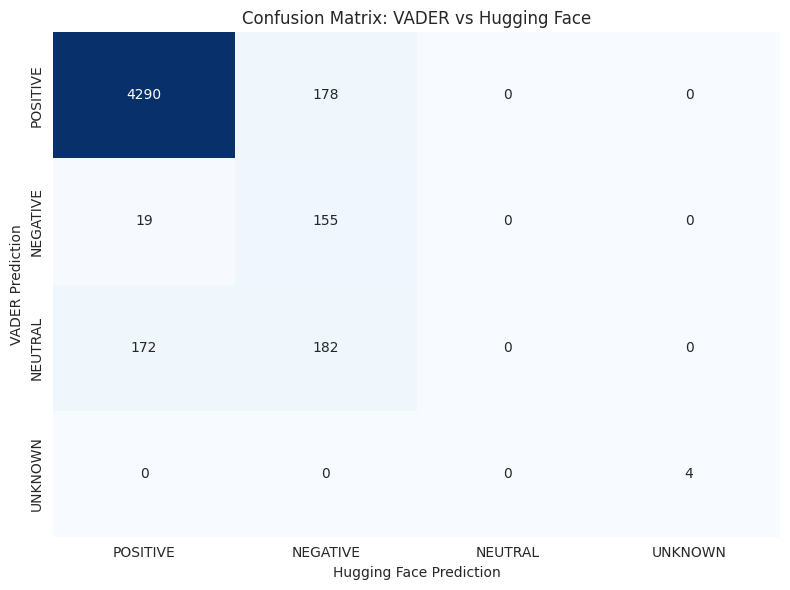

In [121]:

# Define label order
labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'UNKNOWN']

# Compute confusion matrix
cm = confusion_matrix(
    filtered_reviews['sentiment'],
    filtered_reviews['hf_sentiment'],
    labels=labels
)

# Convert to DataFrame for better labeling
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix: VADER vs Hugging Face")
plt.xlabel("Hugging Face Prediction")
plt.ylabel("VADER Prediction")
plt.tight_layout()
plt.show()

Here are some insights based on the Confusion Matrix:

- **Strong agreement on positive reviews**: 4,290 reviews were labeled Positive by both models, showing high alignment on positive sentiment.
- **Disagreement on neutral cases**: VADER marked 354 reviews as Neutral, but Hugging Face assigned Positive to 172 and Negatuve to 182,which suggests that  Hugging Face forces polarity where VADER stays cautious.
- **Minor mismatches in negative sentiment**: 19 reviews labeled Negative by VADER were seen as Positive by Hugging Face, indicating some optimism bias in the transformer model.
- **Perfect match on unknowns**: All 4 Unknown cases were consistently labeled by both models, confirming clean handling of edge cases.


#What did we do differently?
* What sets our work apart is that we did far more than train models on raw
Airbnb features.
*  We designed rich engineered features that captured space efficiency, host behavior, location proximity, demand signals, and review-based sentiment, giving the model deeper context that most teams overlook.
* Instead of relying on a single train and test split, we used cross-validation to ensure generalization and implemented hyperparameter tuning to reduce overfitting and optimize model performance.
* Our approach combined structured data, engineered features, and sentiment analytics into a unified modeling pipeline, enabling more accurate and interpretable price predictions than a standard feature-only or model-only workflow.
